In [ ]:
!pip install eli5

In [4]:
import eli5
import shutil
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, tnrange
from sklearn.metrics import accuracy_score, roc_curve, auc, plot_confusion_matrix, classification_report, precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
np.set_printoptions(suppress=True)

# Functions

In [5]:
def encode(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    OH_encoder = OneHotEncoder()
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[object_cols]).toarray(), columns=OH_encoder.get_feature_names(object_cols))
    num_data = df.drop(object_cols, axis=1)
    data_new = pd.concat([num_data, OH_cols], axis=1)

    return data_new

In [6]:
def cv(model, cv_train_list, cv_val_list, precision=False):
    assert len(cv_train_list) == len(cv_val_list), "Length of training set cv list and validation set cv list must be the same"

    scores = []
    for i in range(len(cv_train_list)):
        X_train = cv_train_list[i][0]
        y_train = cv_train_list[i][1]
        X_val = cv_val_list[i][0]
        y_val = cv_val_list[i][1]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        if precision:
            acc = precision_score(y_val, y_pred, average='macro', zero_division=0)
        else:
            acc = accuracy_score(y_val, y_pred)
        scores.append(acc)

    return scores

In [7]:
def train_and_test(model, X_train, y_train, X_test, y_test, precision=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if precision:
        acc = precision_score(y_test, y_pred, average='macro', zero_division=0)
    else:
        acc = accuracy_score(y_test, y_pred)
    return acc, y_pred

In [8]:
def produce_roc(model_pred_probs):
    y_test_bin = label_binarize(y_test, classes=np.arange(3))
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure(figsize=(10, 8))
    colors = ['darkorange', 'darkviolet', 'navy']
    for i, color in zip(range(3), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                color=color,
                lw=2,
                label='ROC curve of {0} class (area = {1:0.2f})'
                ''.format(class_dict[i], roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.legend(loc="lower right")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    plt.show()

In [33]:
def print_metrics(model, X_train, y_train, y_pred, X_test, y_test):
    model.fit(X_train, y_train)
    print(classification_report(y_test, y_pred))
    fig, axs = plt.subplots(figsize=(10, 8))
    disp = plot_confusion_matrix(model, X_test, y_test,
                                display_labels=class_names,
                                cmap=plt.cm.Blues,
                                normalize=None,
                                ax=axs)
    axs.set_title('Normalized confusion matrix', fontsize=20)
    axs.set_xlabel('Predicted label', fontsize=16)
    axs.set_ylabel('True label', fontsize=16)
    print('Normalized confusion matrix:')
    print(disp.confusion_matrix)
    plt.show()

In [34]:
def one_loop(x, precision=False, print_results=False):
    results_list = []
    pred_list = []
    data_train_raw = pd.read_csv('/content/content/data/data_train_full_new.csv')
    data_test_raw = pd.read_csv('/content/content/data/data_test_new.csv')

    # Preprocessing
    y_train_cat = data_train_raw['category'].to_numpy()
    y_test_cat = data_test_raw['category'].to_numpy()
    le = LabelEncoder()
    le.fit(y_train_cat)
    y_train = le.transform(y_train_cat)
    y_test = le.transform(y_test_cat)
    X_train = encode(data_train_raw.drop(columns=['ID', 'slope', 'r2', 'category']))
    X_test_raw = encode(data_test_raw.drop(columns=['ID', 'slope', 'r2', 'category']))
    col_list = list(X_train.columns.values)
    X_test = X_test_raw.reindex(columns=col_list).fillna(0)
    X_test = X_test[col_list]
    data_train_list, data_val_list = [], []
    for i in range(5):
        train_raw = pd.read_csv('/content/content/data/data_cv_train_' + str(i+1) + '.csv')
        val_raw = pd.read_csv('/content/content/data/data_cv_val_' + str(i+1) + '.csv')
        y_train_cat = train_raw['category'].to_numpy()
        y_val_cat = val_raw['category'].to_numpy()
        y_train = le.transform(y_train_cat)
        y_val = le.transform(y_val_cat)
        X_train = encode(train_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)
        X_val = encode(val_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)
        X_train = X_train[col_list]
        X_val = X_val[col_list]
        data_train_list.append((X_train, y_train))
        data_val_list.append((X_val, y_val))
    
    # Training and testing
    class_dict = {0: 'Fast', 1: 'Other', 2: 'Slow'}
    class_names = list(le.inverse_transform([0, 1, 2]))

    # Gaussian Process
    model = GaussianProcessClassifier(random_state=1, n_jobs=-1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # KNN
    k_vals = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
    knn_accuracies = []
    for k in tqdm(k_vals):
        model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', n_jobs=-1)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        knn_accuracies.append(np.mean(scores))
    knn_best_index = np.argmax(knn_accuracies)
    knn_best_k = k_vals[knn_best_index]
    model = KNeighborsClassifier(n_neighbors=knn_best_k, algorithm='ball_tree', n_jobs=-1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # Logistic Regression
    lr_C_vals = np.logspace(-1, 5, num=7)
    lr_accuracies = []
    for c in tqdm(lr_C_vals):
        model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=c)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        lr_accuracies.append(np.mean(scores))
    lr_best_index = np.argmax(lr_accuracies)
    lr_best_c = lr_C_vals[lr_best_index]
    model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=lr_best_c)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # Random Forest
    rf_n_estimators_list= [100, 200, 300, 400, 500]
    rf_accuracies = []
    for n in tqdm(rf_n_estimators_list):
        model = RandomForestClassifier(n_estimators=n, criterion='gini', random_state=1, n_jobs=-1)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        rf_accuracies.append(np.mean(scores))
    rf_best_index = np.argmax(rf_accuracies)
    rf_best_n = rf_n_estimators_list[rf_best_index]
    model = RandomForestClassifier(n_estimators=rf_best_n, criterion='gini', random_state=1, n_jobs=-1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # SVC (poly)
    svc_C_vals = np.logspace(-1, 3, num=5)
    svc_degree_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    params = []
    best_score = 0.0
    for i in svc_C_vals:
        for j in svc_degree_vals:
            params.append((i, j))
    for i in tnrange(len(params)):
        model = SVC(C=params[i][0], kernel='poly', degree=params[i][1], random_state=1)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        if np.mean(scores) > best_score:
            best_score = np.mean(scores)
            best_params = (params[i][0], params[i][1])
    model = SVC(C=best_params[0], degree=best_params[1], random_state=1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # SVC (rbf)
    svc_C_vals = np.logspace(-1, 5, num=7)
    svc_accuracies = []
    for c in tqdm(svc_C_vals):
        model = SVC(C=c, random_state=1)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        svc_accuracies.append(np.mean(scores))
    svc_best_index = np.argmax(svc_accuracies)
    svc_best_c = svc_C_vals[svc_best_index]
    model = SVC(C=svc_best_c, random_state=1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # XGBoost
    eta = [0.1, 0.3, 0.5]
    max_depth = [1, 2, 3, 5, 10]
    min_child_weight = [0.5, 1, 2, 3, 5]
    params = []
    best_score = 0.0
    for i in eta:
        for j in max_depth:
            for k in min_child_weight:
                params.append((i, j, k))
    for i in tnrange(len(params)):
        model = XGBClassifier(eta=params[i][0], max_depth=params[i][1], min_child_weight=params[i][2], random_state=1, use_label_encoder=False, n_jobs=-1)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        if np.mean(scores) > best_score:
            best_score = np.mean(scores)
            best_params = (params[i][0], params[i][1], params[i][2])
    model = XGBClassifier(max_depth=best_params[1], eta=best_params[0], min_child_weight=best_params[2], random_state=1, use_label_encoder=False, n_jobs=-1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # Adaboost
    adbst_n_estimators_list= [50, 100, 200, 300]
    adbst_accuracies = []
    for n in tqdm(adbst_n_estimators_list):
        model = AdaBoostClassifier(n_estimators=n, random_state=1)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        adbst_accuracies.append(np.mean(scores))
    adbst_best_index = np.argmax(adbst_accuracies)
    adbst_best_n = adbst_n_estimators_list[adbst_best_index]
    model = AdaBoostClassifier(n_estimators=adbst_best_n, random_state=1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    # Neural Network
    hidden_layer_sizes = [(100,), (200,), (500,), (1000,)]
    learning_rate_init = [0.1, 0.05, 0.01, 0.005, 0.001]
    params = []
    best_score = 0.0
    for i in hidden_layer_sizes:
        for j in learning_rate_init:
            params.append((i, j))
    for i in tnrange(len(params)):
        model = MLPClassifier(hidden_layer_sizes=params[i][0], learning_rate_init=params[i][1], max_iter=1000, random_state=1)
        scores = cv(model, data_train_list, data_val_list, precision=precision)
        if np.mean(scores) > best_score:
            best_score = np.mean(scores)
            best_params = (params[i][0], params[i][1])
    model = MLPClassifier(hidden_layer_sizes=best_params[0], learning_rate_init=best_params[1], random_state=1)
    acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
    results_list.append(acc)
    pred_list.append((y_pred, y_test))
    if print_results:
        print_metrics(model, X_train, y_train, y_pred, X_test, y_test)

    return results_list, pred_list

In [11]:
def full_process(working_directory, precision=False):
    x = None
    final_results_list = []
    final_pred_list = []
    os.chdir(working_directory)
    for file in tqdm(os.listdir(working_directory)):
        if zipfile.is_zipfile(file):
            with zipfile.ZipFile(file) as item:
                item.extractall()
            results_list, pred_list = one_loop(x, precision=precision)
            final_results_list.append(np.array(results_list))
            final_pred_list.append(pred_list)
    final_array = np.vstack(final_results_list)
    return final_array, final_pred_list

# 10 percentile

## Data preprocessing

In [12]:
!unzip 1.zip
data_train_raw = pd.read_csv('content/data/data_train_full_new.csv')
data_test_raw = pd.read_csv('content/data/data_test_new.csv')

# y values
y_train_cat = data_train_raw['category'].to_numpy()
y_test_cat = data_test_raw['category'].to_numpy()
le = LabelEncoder()
le.fit(y_train_cat)
y_train = le.transform(y_train_cat)
y_test = le.transform(y_test_cat)

# One-hot encode categorical features
X_train = encode(data_train_raw.drop(columns=['ID', 'slope', 'r2', 'category']))
X_test_raw = encode(data_test_raw.drop(columns=['ID', 'slope', 'r2', 'category']))

# Fix missing values
col_list = list(X_train.columns.values)
X_test = X_test_raw.reindex(columns=col_list).fillna(0)
X_test = X_test[col_list]

data_train_list, data_val_list = [], []
for i in range(5):
    train_raw = pd.read_csv('content/data/data_cv_train_' + str(i+1) + '.csv')
    val_raw = pd.read_csv('content/data/data_cv_val_' + str(i+1) + '.csv')

    y_train_cat = train_raw['category'].to_numpy()
    y_val_cat = val_raw['category'].to_numpy()
    y_train = le.transform(y_train_cat)
    y_val = le.transform(y_val_cat)

    X_train = encode(train_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)
    X_val = encode(val_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)

    X_train = X_train[col_list]
    X_val = X_val[col_list]

    data_train_list.append((X_train, y_train))
    data_val_list.append((X_val, y_val))

Archive:  1.zip
   creating: content/data/
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  


In [13]:
data_train_raw.groupby(['category']).size()

category
Fast      41
Other    182
Slow     364
dtype: int64

In [14]:
data_test_raw.groupby(['category']).size()

category
Fast      6
Other    42
Slow     86
dtype: int64

## Hyperparameter tuning

In [ ]:
k_vals = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
knn_accuracies = []
knn_std = []

# Peform stratified 5-fold CV
for k in tqdm(k_vals):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    knn_accuracies.append(np.mean(scores))
    knn_std.append(np.std(scores))
    
# Best value and accuracy
knn_best_index = np.argmax(knn_accuracies)
knn_best_k = k_vals[knn_best_index]
knn_best_accuracy = knn_accuracies[knn_best_index]
knn_best_std = knn_std[knn_best_index]
print('Best k: ', knn_best_k)
print('Best cross-validation accuracy: %0.4f' % (knn_best_accuracy))
print('Standard deviation: %0.4f' % (knn_best_std))

  0%|          | 0/15 [00:00<?, ?it/s]

Best k:  30
Best cross-validation accuracy: 0.6440
Standard deviation: 0.0197


In [ ]:
# Regularisation values
lr_C_vals = np.logspace(-1, 5, num=7)
lr_accuracies = []
lr_std = []

# Peform stratified 5-fold CV
for c in tqdm(lr_C_vals):
    model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=c)
    scores = cv(model, data_train_list, data_val_list)
    lr_accuracies.append(np.mean(scores))
    lr_std.append(np.std(scores))
    
# Best value and accuracy
lr_best_index = np.argmax(lr_accuracies)
lr_best_c = lr_C_vals[lr_best_index]
lr_best_accuracy = lr_accuracies[lr_best_index]
lr_best_std = lr_std[lr_best_index]
print('Best c: ', lr_best_c)
print('Best cross-validation accuracy: %0.4f' % (lr_best_accuracy))
print('Standard deviation: %0.4f' % (lr_best_std))

  0%|          | 0/7 [00:00<?, ?it/s]

Best c:  0.1
Best cross-validation accuracy: 0.5997
Standard deviation: 0.0364


In [ ]:
rf_n_estimators_list= [100, 200, 300, 400, 500]
rf_accuracies = []
rf_std = []

# Peform stratified 5-fold CV
for n in tqdm(rf_n_estimators_list):
    model = RandomForestClassifier(n_estimators=n, criterion='gini', random_state=1, n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    rf_accuracies.append(np.mean(scores))
    rf_std.append(np.std(scores))
    
# Best value and accuracy
rf_best_index = np.argmax(rf_accuracies)
rf_best_n = rf_n_estimators_list[rf_best_index]
rf_best_accuracy = rf_accuracies[rf_best_index]
rf_best_std = rf_std[rf_best_index]
print('Best n_estimators: ', rf_best_n)
print('Best cross-validation accuracy: %0.4f' % (rf_best_accuracy))
print('Standard deviation: %0.4f' % (rf_best_std))

  0%|          | 0/5 [00:00<?, ?it/s]

Best n_estimators:  400
Best cross-validation accuracy: 0.6507
Standard deviation: 0.0169


In [ ]:
svc_C_vals = np.logspace(-1, 3, num=5)
svc_degree_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    
params = []
best_score = 0.0
best_score_std = 0.0
for i in svc_C_vals:
    for j in svc_degree_vals:
        params.append((i, j))
for i in tnrange(len(params)):
    model = SVC(C=params[i][0], kernel='poly', degree=params[i][1], random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/60 [00:00<?, ?it/s]

Best params:  (100.0, 7)
Best cross-validation accuracy: 0.6491
Standard deviation: 0.0138


In [ ]:
svc_C_vals = np.logspace(-1, 5, num=7)
svc_accuracies = []
svc_std = []

# Peform stratified 5-fold CV
for c in tqdm(svc_C_vals):
    model = SVC(C=c, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    svc_accuracies.append(np.mean(scores))
    svc_std.append(np.std(scores))
    
# Best value and accuracy
svc_best_index = np.argmax(svc_accuracies)
svc_best_c = svc_C_vals[svc_best_index]
svc_best_accuracy = svc_accuracies[svc_best_index]
svc_best_std = svc_std[svc_best_index]
print('Best C: ', svc_best_c)
print('Best cross-validation accuracy: %0.4f' % (svc_best_accuracy))
print('Standard deviation: %0.4f' % (svc_best_std))

  0%|          | 0/7 [00:00<?, ?it/s]

Best C:  1000.0
Best cross-validation accuracy: 0.6473
Standard deviation: 0.0176


In [ ]:
eta = [0.1, 0.3, 0.5]
max_depth = [1, 2, 3, 5, 10]
min_child_weight = [0.5, 1, 2, 3, 5]

params = []
best_score = 0.0
best_score_std = 0.0
for i in eta:
    for j in max_depth:
        for k in min_child_weight:
            params.append((i, j, k))
for i in tnrange(len(params)):
    model = XGBClassifier(eta=params[i][0], max_depth=params[i][1], min_child_weight=params[i][2], random_state=1, use_label_encoder=False, n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1], params[i][2])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/75 [00:00<?, ?it/s]

Best params:  (0.1, 1, 2)
Best cross-validation accuracy: 0.6474
Standard deviation: 0.0131


In [ ]:
adbst_n_estimators_list= [50, 100, 200, 300]
adbst_accuracies = []
adbst_std = []

# Peform stratified 5-fold CV
for n in tqdm(adbst_n_estimators_list):
    model = AdaBoostClassifier(n_estimators=n, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    adbst_accuracies.append(np.mean(scores))
    adbst_std.append(np.std(scores))
    
# Best value and accuracy
adbst_best_index = np.argmax(adbst_accuracies)
adbst_best_n = adbst_n_estimators_list[adbst_best_index]
adbst_best_accuracy = adbst_accuracies[adbst_best_index]
adbst_best_std = adbst_std[adbst_best_index]
print('Best n_estimators: ', adbst_best_n)
print('Best cross-validation accuracy: %0.4f' % (adbst_best_accuracy))
print('Standard deviation: %0.4f' % (adbst_best_std))

  0%|          | 0/4 [00:00<?, ?it/s]

Best n_estimators:  50
Best cross-validation accuracy: 0.5895
Standard deviation: 0.0561


In [ ]:
hidden_layer_sizes = [(100,), (200,), (500,), (1000,)]
learning_rate_init = [0.1, 0.05, 0.01, 0.005, 0.001]

params = []
best_score = 0.0
best_score_std = 0.0
for i in hidden_layer_sizes:
    for j in learning_rate_init:
        params.append((i, j))
for i in tnrange(len(params)):
    model = MLPClassifier(hidden_layer_sizes=params[i][0], learning_rate_init=params[i][1], max_iter=1000, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/20 [00:00<?, ?it/s]

Best params:  ((100,), 0.001)
Best cross-validation accuracy: 0.6440
Standard deviation: 0.0136


## Testing

In [15]:
class_dict = {0: 'Fast',
              1: 'Other',
              2: 'Slow'}
class_names = list(le.inverse_transform([0, 1, 2]))
print(class_names)

['Fast', 'Other', 'Slow']


0.6492537313432836


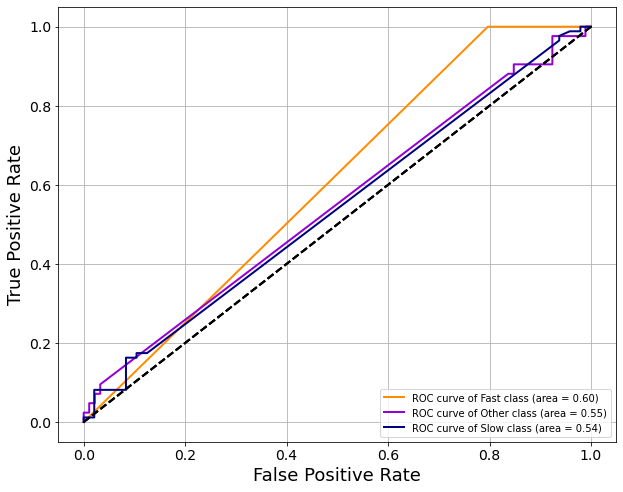

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.57      0.10      0.16        42
           2       0.65      0.97      0.78        86

    accuracy                           0.65       134
   macro avg       0.41      0.35      0.31       134
weighted avg       0.60      0.65      0.55       134

Normalized confusion matrix:
[[ 0  0  6]
 [ 0  4 38]
 [ 0  3 83]]


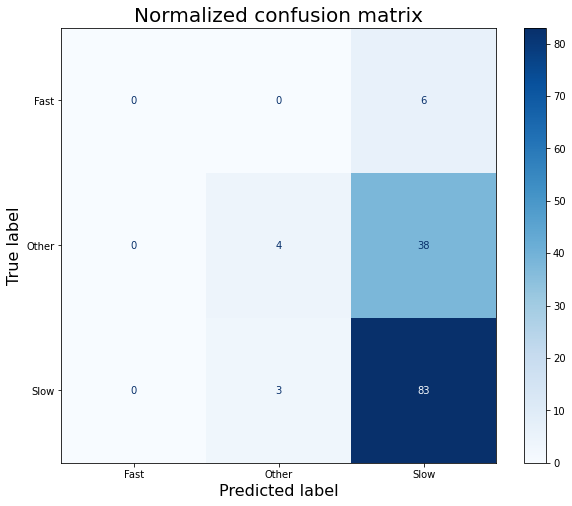

In [23]:
# Gaussian Process
model = GaussianProcessClassifier(random_state=1, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.6417910447761194


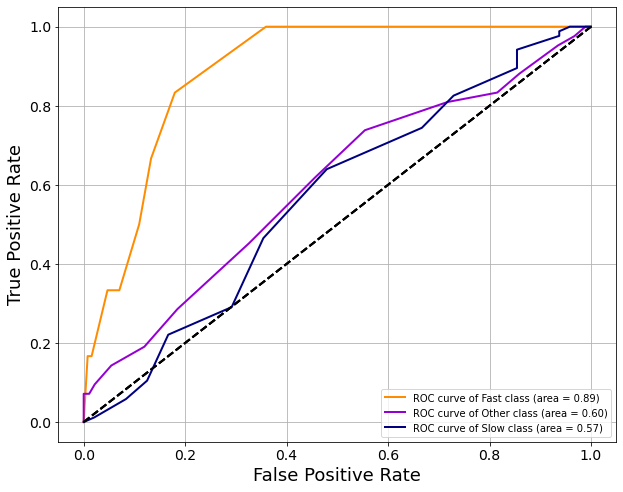

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.12      0.19        42
           2       0.65      0.94      0.77        86

    accuracy                           0.64       134
   macro avg       0.38      0.35      0.32       134
weighted avg       0.58      0.64      0.56       134

Normalized confusion matrix:
[[ 0  0  6]
 [ 0  5 37]
 [ 0  5 81]]


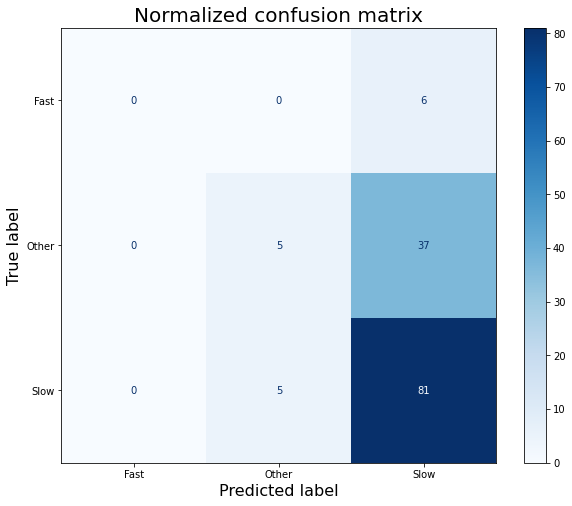

In [22]:
# KNN
model = KNeighborsClassifier(n_neighbors=30, algorithm='ball_tree', n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.6791044776119403


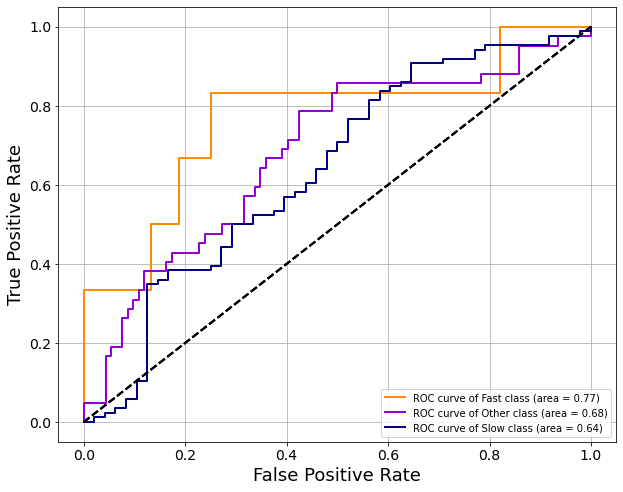

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.56      0.33      0.42        42
           2       0.70      0.87      0.78        86

    accuracy                           0.68       134
   macro avg       0.75      0.51      0.57       134
weighted avg       0.67      0.68      0.65       134

Normalized confusion matrix:
[[ 2  0  4]
 [ 0 14 28]
 [ 0 11 75]]


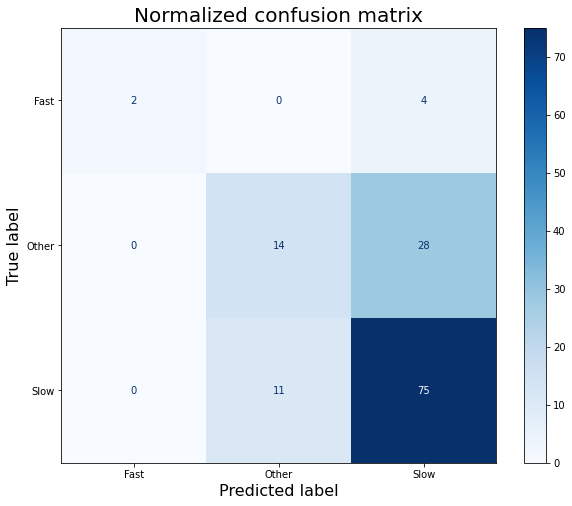

In [21]:
# Logistic Regression
model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=10000)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.664179104477612


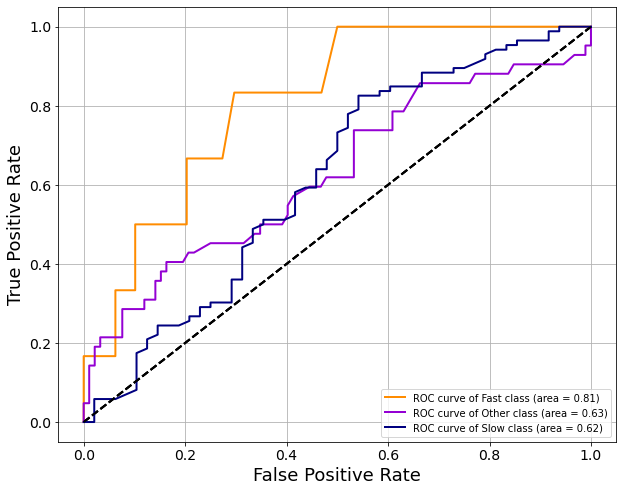

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.55      0.29      0.37        42
           2       0.69      0.90      0.78        86

    accuracy                           0.66       134
   macro avg       0.41      0.39      0.38       134
weighted avg       0.61      0.66      0.62       134

Normalized confusion matrix:
[[ 0  1  5]
 [ 0 12 30]
 [ 0  9 77]]


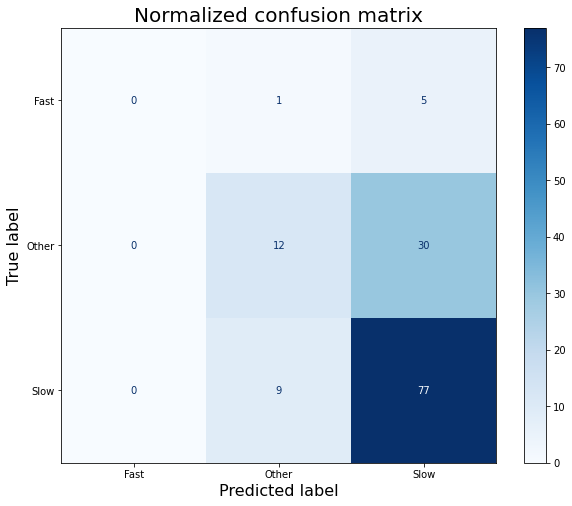

In [24]:
# Random Forest
model = RandomForestClassifier(n_estimators=400, criterion='gini', random_state=1, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.6044776119402985
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.20      0.02      0.04        42
           2       0.65      0.93      0.76        86

    accuracy                           0.60       134
   macro avg       0.28      0.32      0.27       134
weighted avg       0.48      0.60      0.50       134

Normalized confusion matrix:
[[ 0  1  5]
 [ 2  1 39]
 [ 3  3 80]]


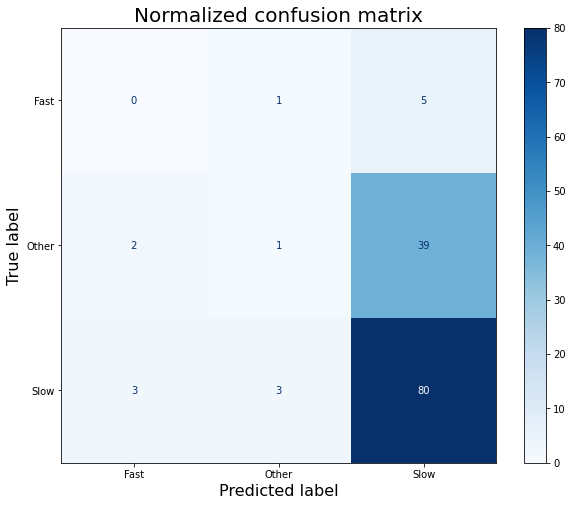

In [25]:
# SVC
model = SVC(C=100, kernel='poly', degree=7, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.6791044776119403
              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.75      0.21      0.33        42
           2       0.69      0.94      0.79        86

    accuracy                           0.68       134
   macro avg       0.56      0.44      0.44       134
weighted avg       0.69      0.68      0.62       134

Normalized confusion matrix:
[[ 1  0  5]
 [ 1  9 32]
 [ 2  3 81]]


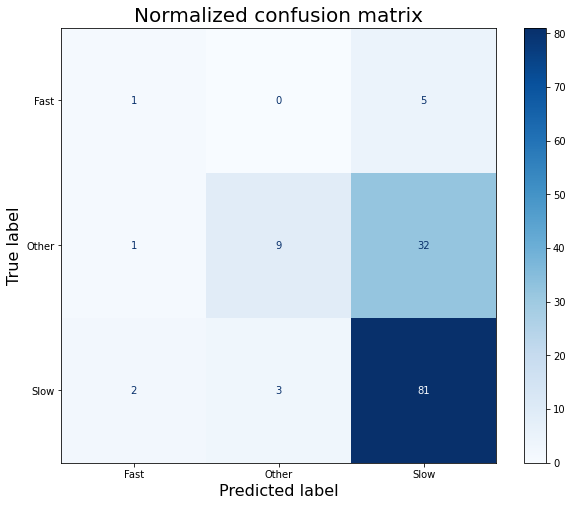

In [26]:
# SVC
model = SVC(C=1000, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.6716417910447762


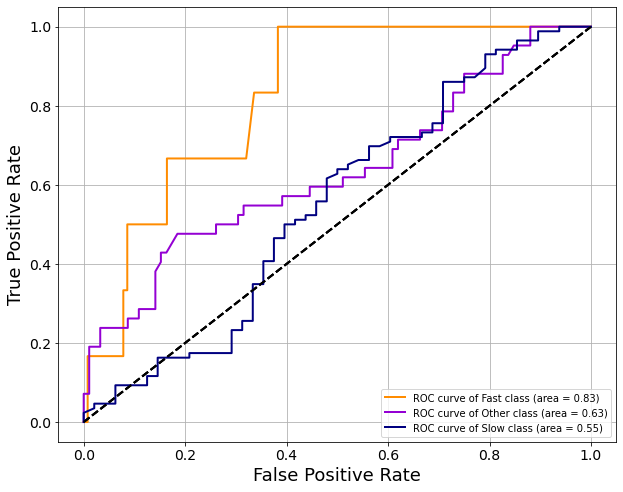

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.83      0.12      0.21        42
           2       0.66      0.99      0.79        86

    accuracy                           0.67       134
   macro avg       0.50      0.37      0.33       134
weighted avg       0.69      0.67      0.58       134

Normalized confusion matrix:
[[ 0  0  6]
 [ 0  5 37]
 [ 0  1 85]]


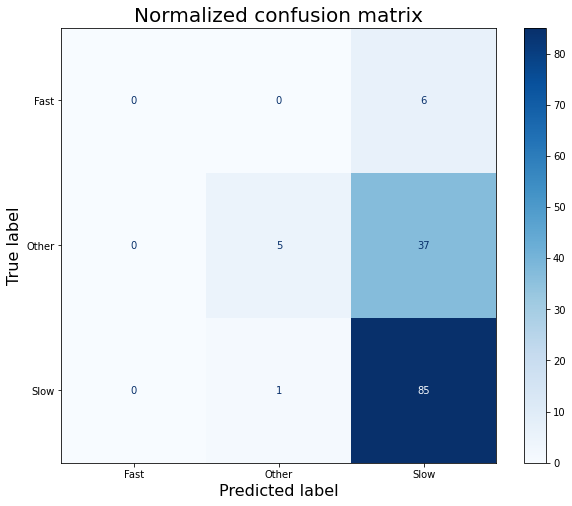

In [27]:
# XGBoost
model = XGBClassifier(max_depth=1, eta=0.1, min_child_weight=2, random_state=1, use_label_encoder=False, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.6194029850746269


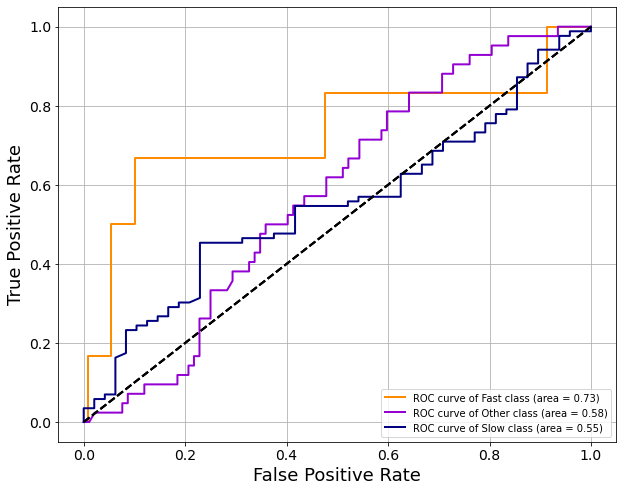

              precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.48      0.29      0.36        42
           2       0.67      0.81      0.74        86

    accuracy                           0.62       134
   macro avg       0.45      0.42      0.43       134
weighted avg       0.59      0.62      0.59       134

Normalized confusion matrix:
[[ 1  1  4]
 [ 0 12 30]
 [ 4 12 70]]


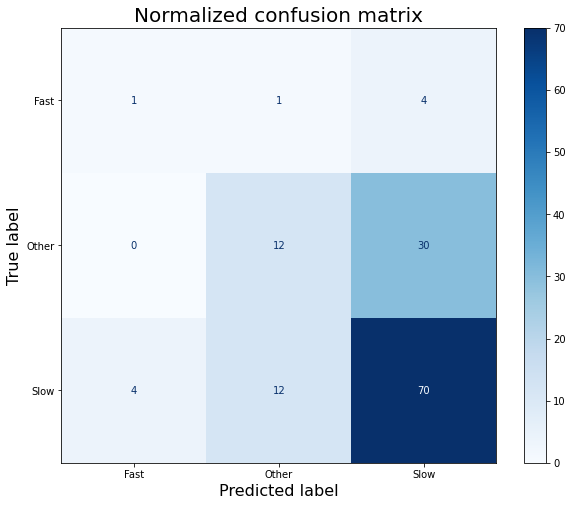

In [28]:
# Adaboost
model = AdaBoostClassifier(n_estimators=50, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.6567164179104478


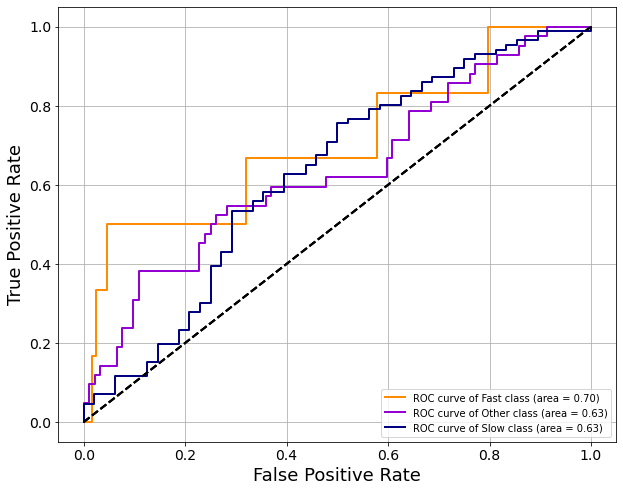

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.56      0.21      0.31        42
           2       0.68      0.92      0.78        86

    accuracy                           0.66       134
   macro avg       0.41      0.38      0.36       134
weighted avg       0.61      0.66      0.60       134

Normalized confusion matrix:
[[ 0  1  5]
 [ 0  9 33]
 [ 1  6 79]]


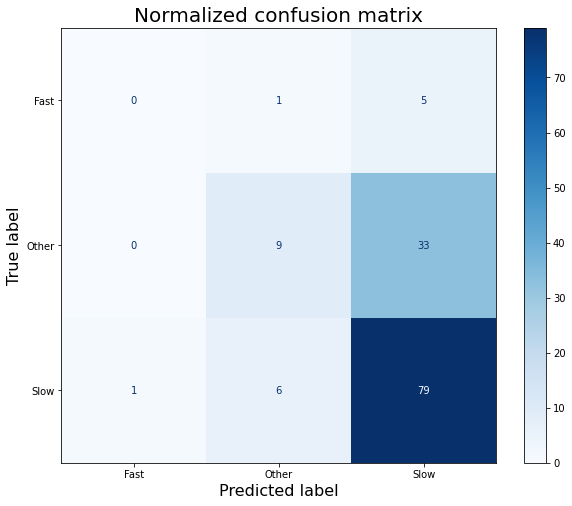

In [29]:
# Neural Network
model = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.001, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

## Additional runs

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.14      0.02      0.04        45
           2       0.56      0.92      0.70        78

    accuracy                           0.54       136
   macro avg       0.23      0.32      0.24       136
weighted avg       0.37      0.54      0.41       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0  1 44]
 [ 0  6 72]]


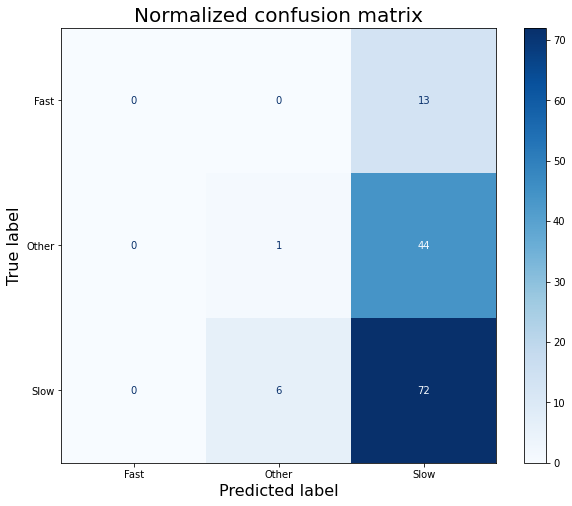

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.39      0.20      0.26        45
           2       0.61      0.88      0.72        78

    accuracy                           0.57       136
   macro avg       0.33      0.36      0.33       136
weighted avg       0.48      0.57      0.50       136

Normalized confusion matrix:
[[ 0  5  8]
 [ 0  9 36]
 [ 0  9 69]]


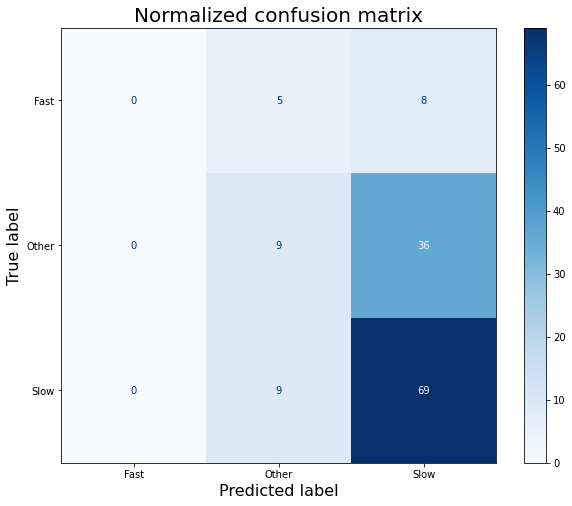

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      0.29      0.39        45
           2       0.61      0.88      0.72        78

    accuracy                           0.60       136
   macro avg       0.40      0.39      0.37       136
weighted avg       0.55      0.60      0.54       136

Normalized confusion matrix:
[[ 0  1 12]
 [ 0 13 32]
 [ 1  8 69]]


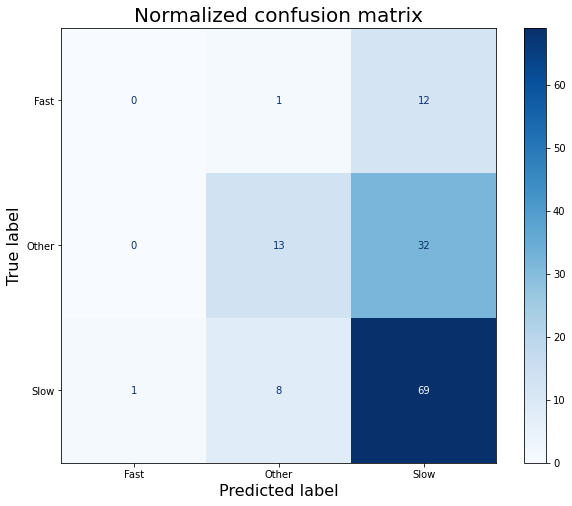

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.45      0.20      0.28        45
           2       0.60      0.88      0.72        78

    accuracy                           0.57       136
   macro avg       0.35      0.36      0.33       136
weighted avg       0.49      0.57      0.50       136

Normalized confusion matrix:
[[ 0  2 11]
 [ 1  9 35]
 [ 0  9 69]]


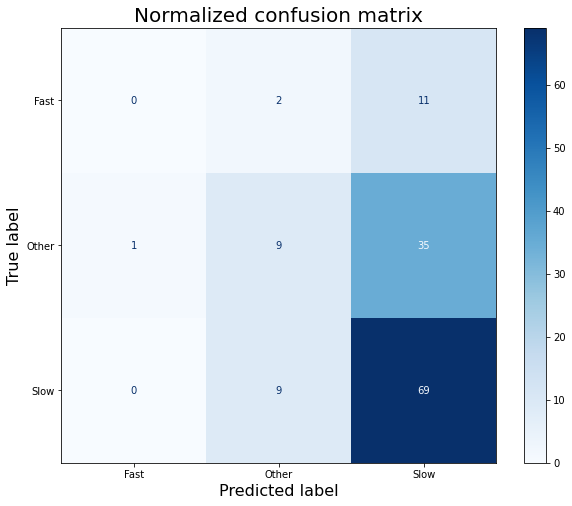

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.77      0.22      0.34        45
           2       0.61      0.95      0.74        78

    accuracy                           0.62       136
   macro avg       0.46      0.39      0.36       136
weighted avg       0.60      0.62      0.54       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0 10 35]
 [ 1  3 74]]


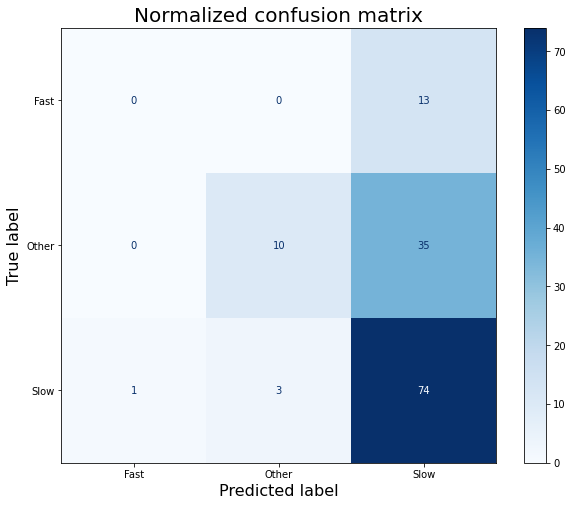

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.77      0.22      0.34        45
           2       0.61      0.95      0.74        78

    accuracy                           0.62       136
   macro avg       0.46      0.39      0.36       136
weighted avg       0.60      0.62      0.54       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0 10 35]
 [ 1  3 74]]


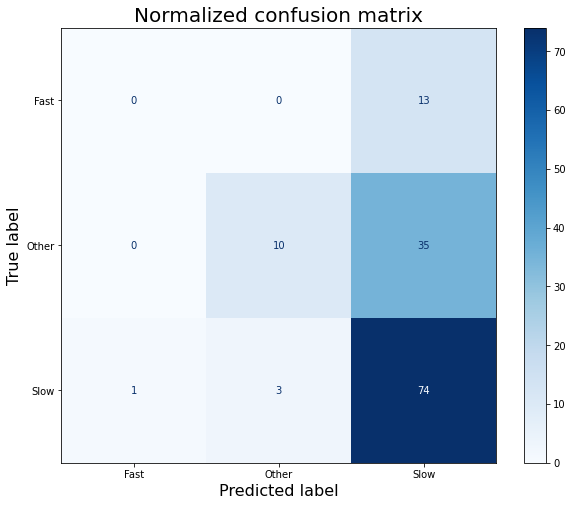

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        13
           1       0.60      0.13      0.22        45
           2       0.60      0.96      0.74        78

    accuracy                           0.60       136
   macro avg       0.73      0.39      0.37       136
weighted avg       0.64      0.60      0.51       136

Normalized confusion matrix:
[[ 1  1 11]
 [ 0  6 39]
 [ 0  3 75]]


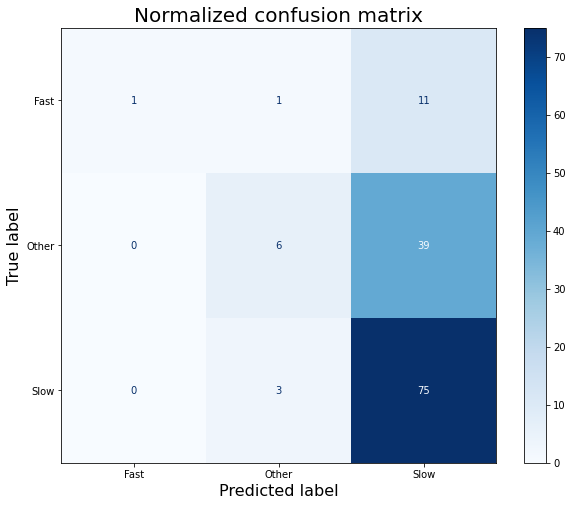

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.22      0.15      0.18        13
           1       0.31      0.29      0.30        45
           2       0.56      0.62      0.59        78

    accuracy                           0.46       136
   macro avg       0.37      0.35      0.36       136
weighted avg       0.45      0.46      0.45       136

Normalized confusion matrix:
[[ 2  4  7]
 [ 2 13 30]
 [ 5 25 48]]


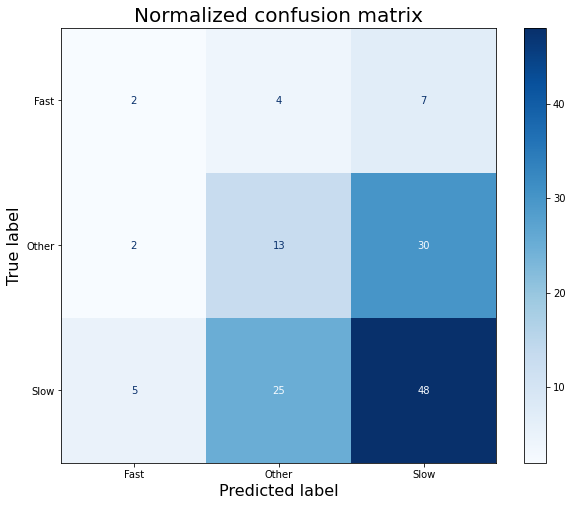

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.47      0.31      0.37        45
           2       0.61      0.83      0.71        78

    accuracy                           0.58       136
   macro avg       0.36      0.38      0.36       136
weighted avg       0.51      0.58      0.53       136

Normalized confusion matrix:
[[ 0  3 10]
 [ 0 14 31]
 [ 0 13 65]]


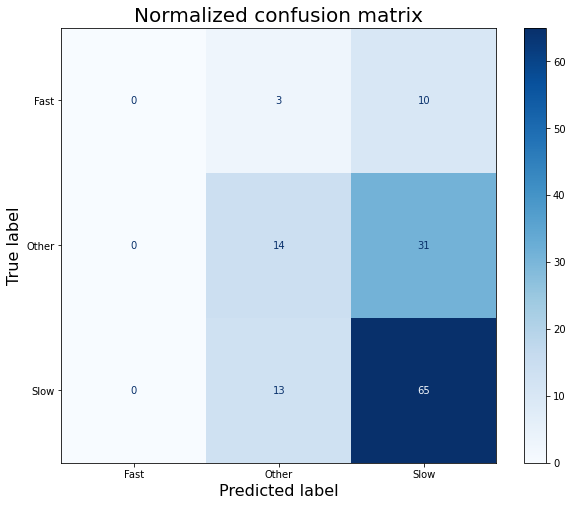

In [36]:
!unzip 2.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  3.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.44      0.16      0.24        43
           2       0.63      0.90      0.74        91

    accuracy                           0.61       146
   macro avg       0.36      0.35      0.33       146
weighted avg       0.52      0.61      0.53       146

Normalized confusion matrix:
[[ 0  0 12]
 [ 0  7 36]
 [ 0  9 82]]


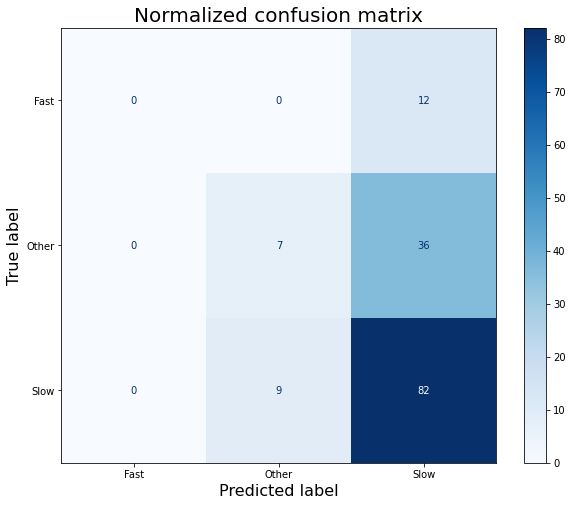

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.33      0.07      0.12        43
           2       0.63      0.95      0.75        91

    accuracy                           0.61       146
   macro avg       0.32      0.34      0.29       146
weighted avg       0.49      0.61      0.50       146

Normalized confusion matrix:
[[ 0  1 11]
 [ 0  3 40]
 [ 0  5 86]]


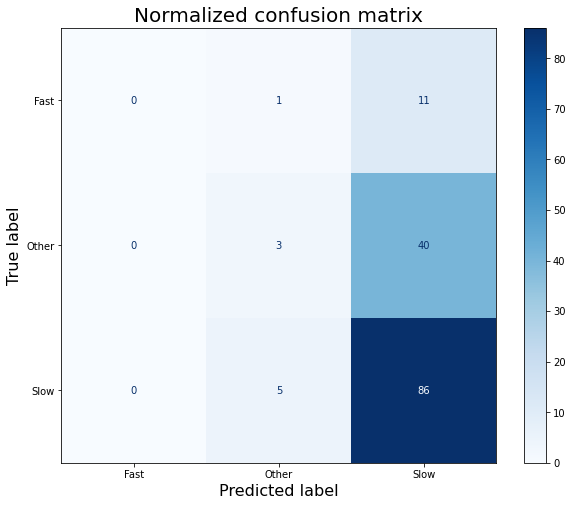

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.50      0.08      0.14        12
           1       0.46      0.26      0.33        43
           2       0.64      0.85      0.73        91

    accuracy                           0.61       146
   macro avg       0.53      0.40      0.40       146
weighted avg       0.58      0.61      0.56       146

Normalized confusion matrix:
[[ 1  0 11]
 [ 0 11 32]
 [ 1 13 77]]


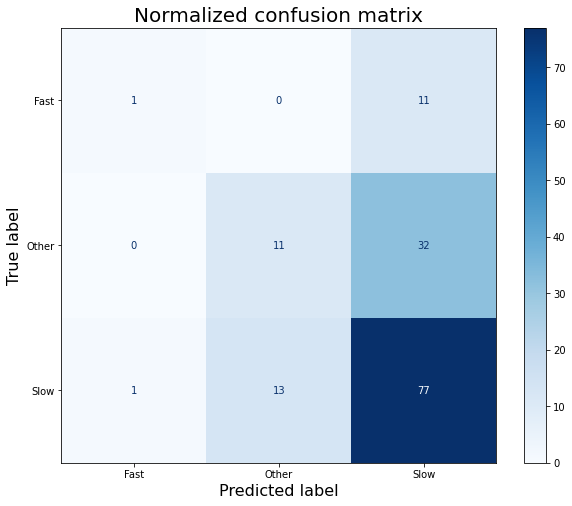

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.45      0.35      0.39        43
           2       0.65      0.80      0.72        91

    accuracy                           0.61       146
   macro avg       0.70      0.41      0.42       146
weighted avg       0.62      0.61      0.58       146

Normalized confusion matrix:
[[ 1  0 11]
 [ 0 15 28]
 [ 0 18 73]]


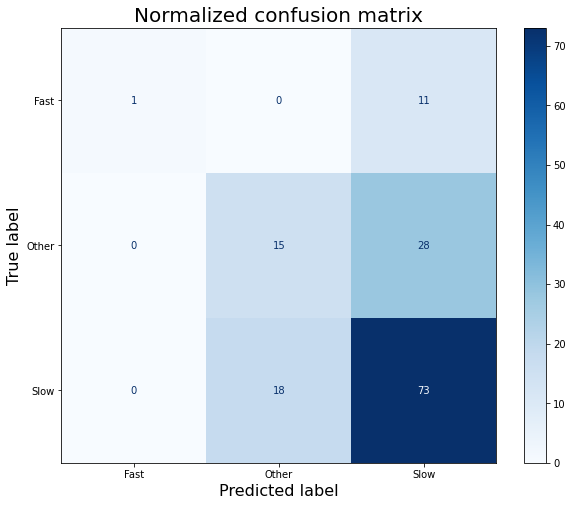

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.57      0.19      0.28        43
           2       0.65      0.92      0.76        91

    accuracy                           0.64       146
   macro avg       0.52      0.40      0.39       146
weighted avg       0.60      0.64      0.57       146

Normalized confusion matrix:
[[ 1  0 11]
 [ 1  8 34]
 [ 1  6 84]]


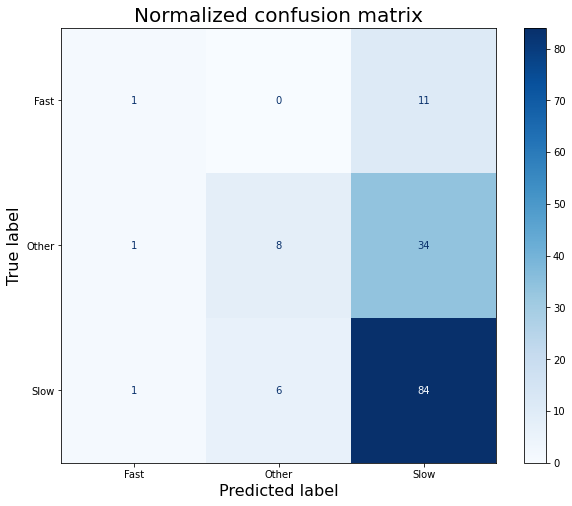

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.57      0.19      0.28        43
           2       0.65      0.92      0.76        91

    accuracy                           0.64       146
   macro avg       0.52      0.40      0.39       146
weighted avg       0.60      0.64      0.57       146

Normalized confusion matrix:
[[ 1  0 11]
 [ 1  8 34]
 [ 1  6 84]]


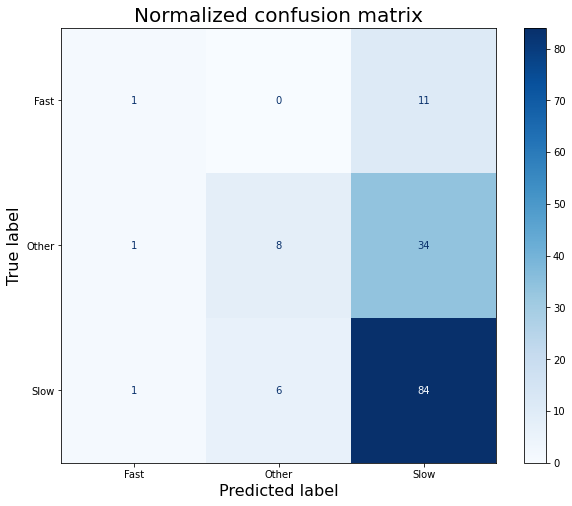

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.89      0.19      0.31        43
           2       0.66      0.99      0.79        91

    accuracy                           0.68       146
   macro avg       0.85      0.42      0.42       146
weighted avg       0.76      0.68      0.60       146

Normalized confusion matrix:
[[ 1  0 11]
 [ 0  8 35]
 [ 0  1 90]]


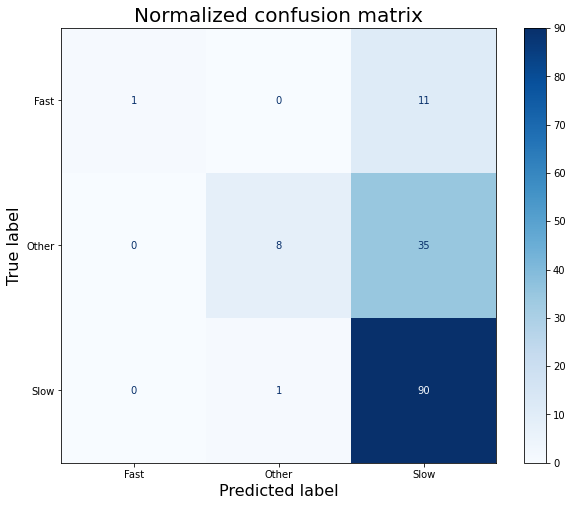

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.46      0.44      0.45        43
           2       0.70      0.73      0.71        91

    accuracy                           0.62       146
   macro avg       0.54      0.53      0.53       146
weighted avg       0.61      0.62      0.61       146

Normalized confusion matrix:
[[ 5  2  5]
 [ 1 19 23]
 [ 5 20 66]]


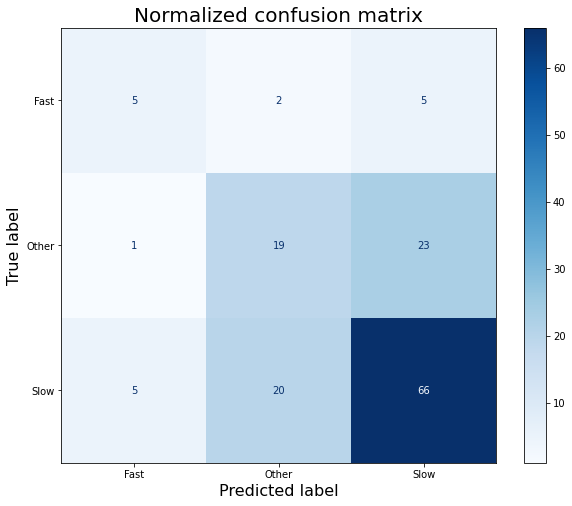

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.59      0.23      0.33        43
           2       0.65      0.91      0.76        91

    accuracy                           0.64       146
   macro avg       0.41      0.38      0.36       146
weighted avg       0.58      0.64      0.57       146

Normalized confusion matrix:
[[ 0  0 12]
 [ 0 10 33]
 [ 1  7 83]]


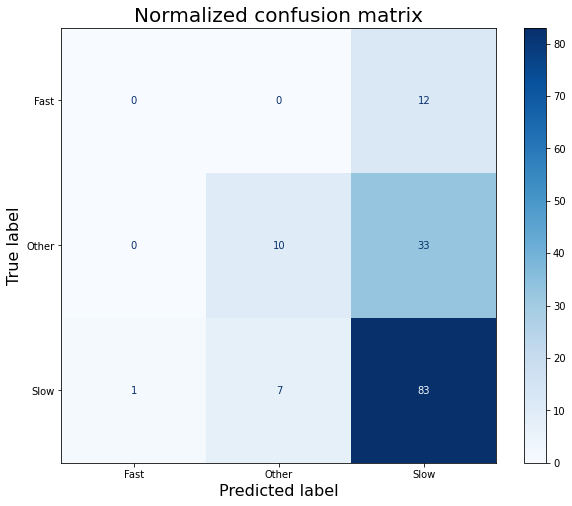

In [37]:
!unzip 3.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  4.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.22      0.05      0.08        42
           2       0.59      0.93      0.72        81

    accuracy                           0.57       136
   macro avg       0.27      0.32      0.27       136
weighted avg       0.42      0.57      0.45       136

Normalized confusion matrix:
[[ 0  1 12]
 [ 0  2 40]
 [ 0  6 75]]


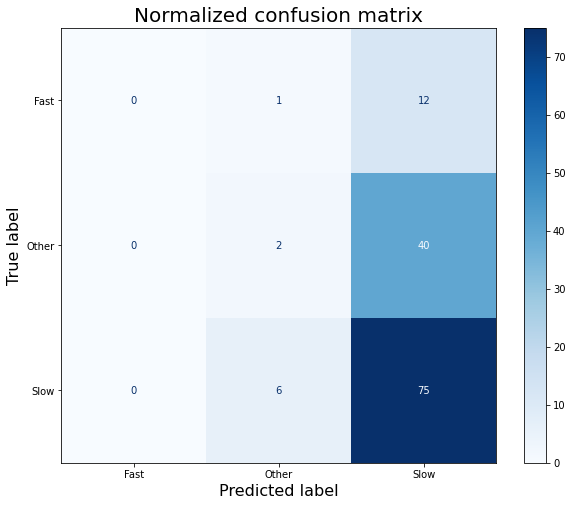

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.22      0.05      0.08        42
           2       0.58      0.91      0.71        81

    accuracy                           0.56       136
   macro avg       0.27      0.32      0.26       136
weighted avg       0.42      0.56      0.45       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0  2 40]
 [ 0  7 74]]


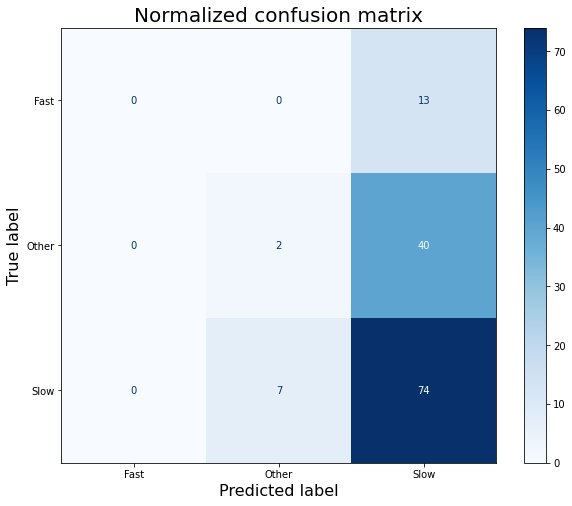

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.47      0.21      0.30        42
           2       0.60      0.86      0.71        81

    accuracy                           0.58       136
   macro avg       0.36      0.36      0.34       136
weighted avg       0.51      0.58      0.51       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0  9 33]
 [ 1 10 70]]


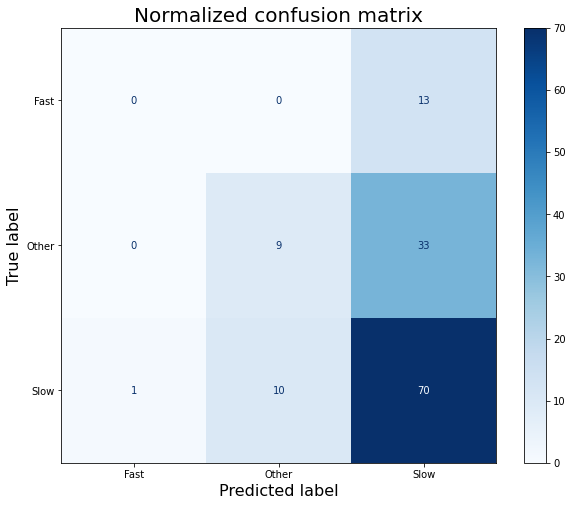

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.47      0.21      0.30        42
           2       0.62      0.89      0.73        81

    accuracy                           0.60       136
   macro avg       0.36      0.37      0.34       136
weighted avg       0.51      0.60      0.52       136

Normalized confusion matrix:
[[ 0  1 12]
 [ 0  9 33]
 [ 0  9 72]]


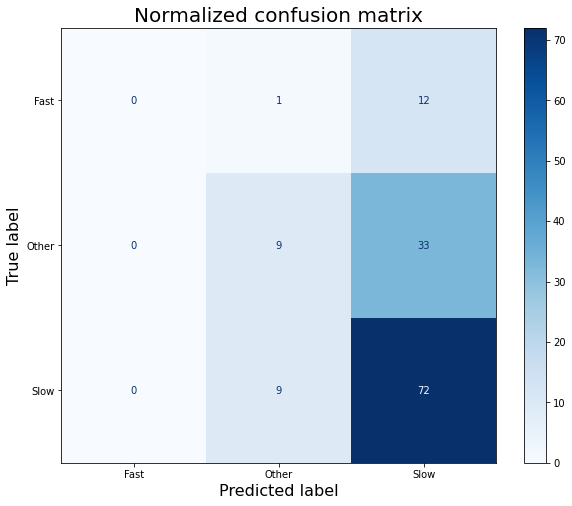

  0%|          | 0/60 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.36      0.10      0.15        42
           2       0.59      0.91      0.72        81

    accuracy                           0.57       136
   macro avg       0.32      0.34      0.29       136
weighted avg       0.46      0.57      0.47       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0  4 38]
 [ 0  7 74]]


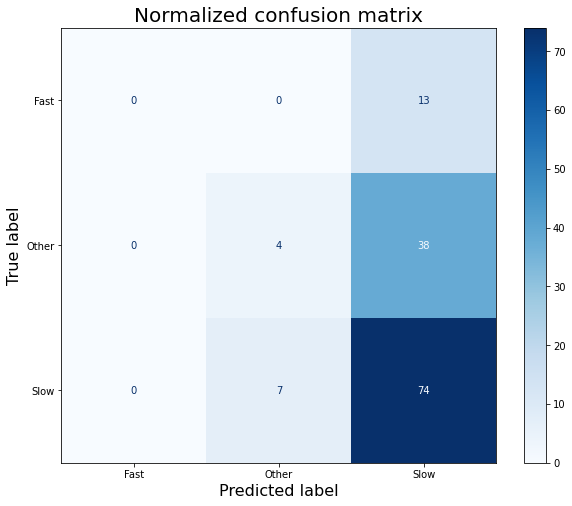

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.25      0.02      0.04        42
           2       0.59      0.96      0.73        81

    accuracy                           0.58       136
   macro avg       0.28      0.33      0.26       136
weighted avg       0.43      0.58      0.45       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0  1 41]
 [ 0  3 78]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


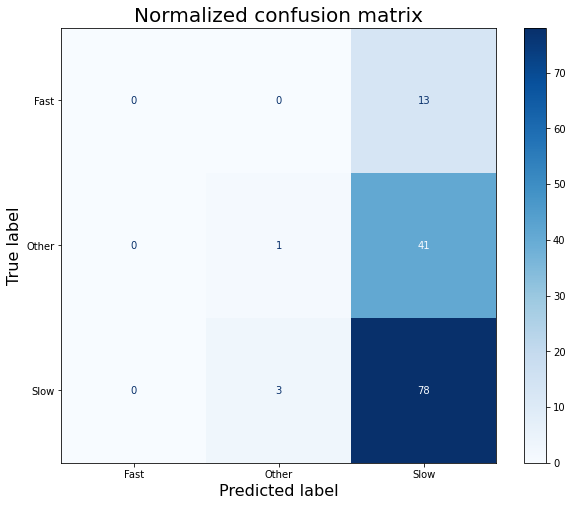

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.50      0.08      0.13        13
           1       1.00      0.05      0.09        42
           2       0.61      0.99      0.75        81

    accuracy                           0.61       136
   macro avg       0.70      0.37      0.33       136
weighted avg       0.72      0.61      0.49       136

Normalized confusion matrix:
[[ 1  0 12]
 [ 0  2 40]
 [ 1  0 80]]


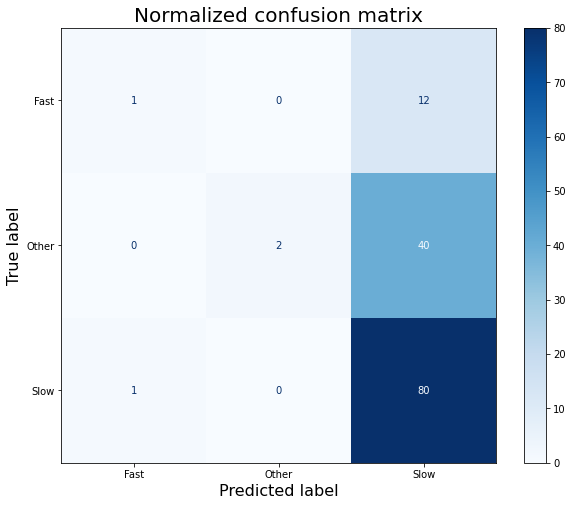

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.31      0.12      0.17        42
           2       0.60      0.86      0.71        81

    accuracy                           0.55       136
   macro avg       0.30      0.33      0.29       136
weighted avg       0.45      0.55      0.47       136

Normalized confusion matrix:
[[ 0  1 12]
 [ 2  5 35]
 [ 1 10 70]]


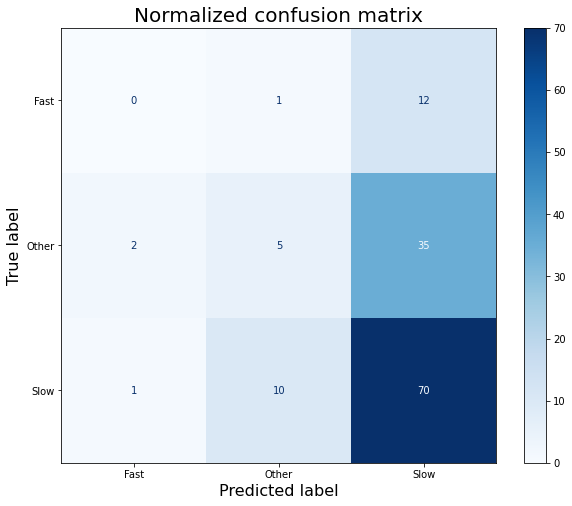

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.60      0.07      0.13        42
           2       0.60      0.98      0.75        81

    accuracy                           0.60       136
   macro avg       0.40      0.35      0.29       136
weighted avg       0.54      0.60      0.48       136

Normalized confusion matrix:
[[ 0  0 13]
 [ 0  3 39]
 [ 0  2 79]]


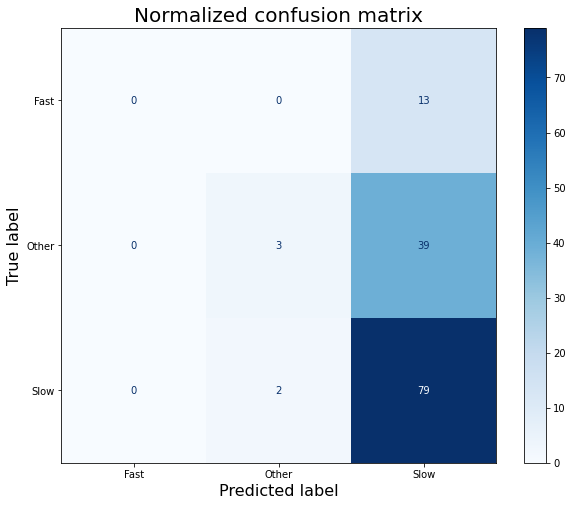

In [38]:
!unzip 4.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  5.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.36      0.10      0.16        40
           2       0.67      0.92      0.78        98

    accuracy                           0.64       146
   macro avg       0.35      0.34      0.31       146
weighted a

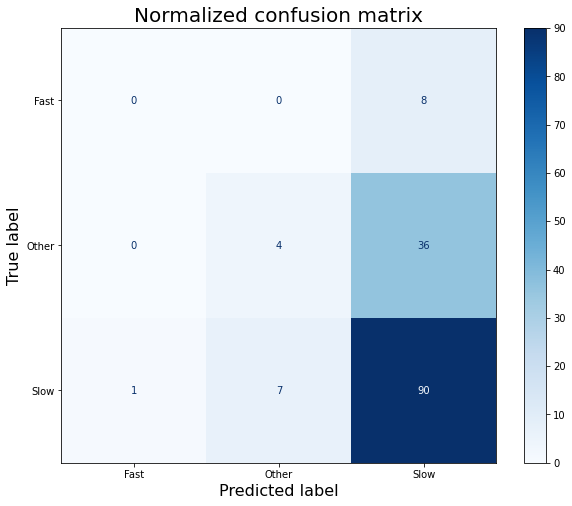

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.75      0.07      0.14        40
           2       0.68      0.99      0.81        98

    accuracy                           0.68       146
   macro avg       0.48      0.35      0.31       146
weighted avg       0.66      0.68      0.58       146

Normalized confusion matrix:
[[ 0  0  8]
 [ 0  3 37]
 [ 0  1 97]]


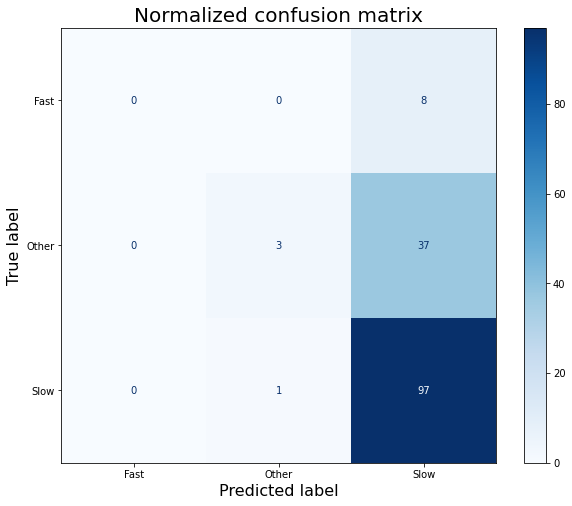

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.47      0.35      0.40        40
           2       0.72      0.85      0.78        98

    accuracy                           0.66       146
   macro avg       0.39      0.40      0.39       146
weighted avg       0.61      0.66      0.63       146

Normalized confusion matrix:
[[ 0  1  7]
 [ 0 14 26]
 [ 0 15 83]]


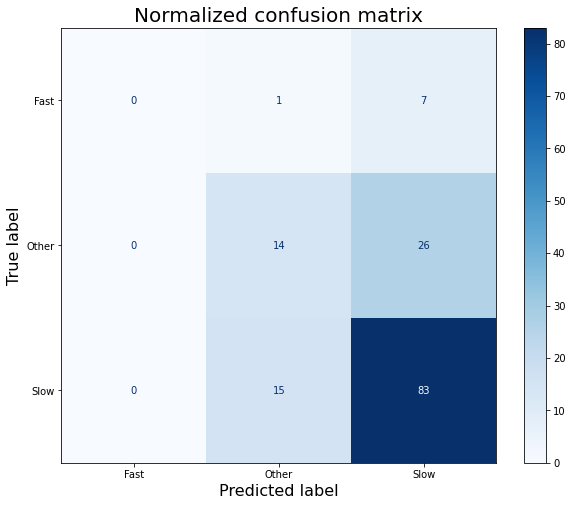

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.47      0.23      0.31        40
           2       0.69      0.90      0.78        98

    accuracy                           0.66       146
   macro avg       0.39      0.37      0.36       146
weighted avg       0.59      0.66      0.61       146

Normalized confusion matrix:
[[ 0  0  8]
 [ 0  9 31]
 [ 0 10 88]]


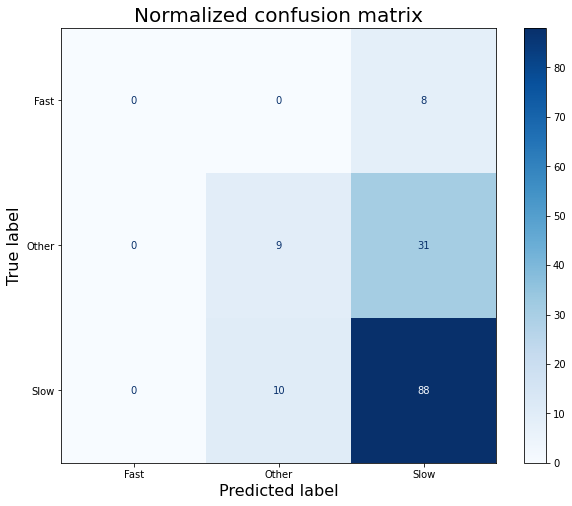

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.54      0.17      0.26        40
           2       0.71      0.93      0.80        98

    accuracy                           0.68       146
   macro avg       0.50      0.41      0.41       146
weighted avg       0.63      0.68      0.62       146

Normalized confusion matrix:
[[ 1  0  7]
 [ 2  7 31]
 [ 1  6 91]]


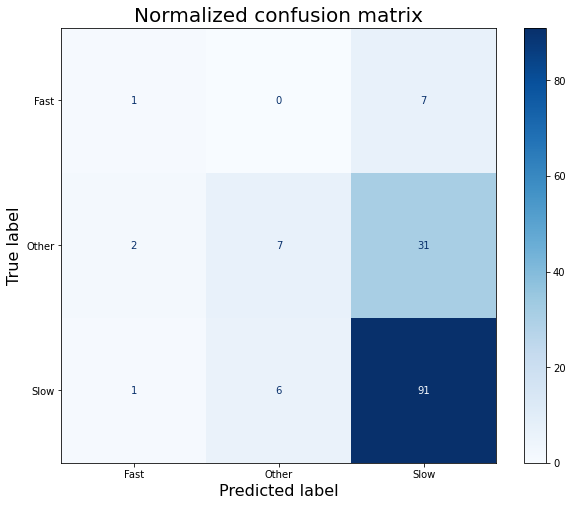

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.83      0.12      0.22        40
           2       0.70      0.98      0.81        98

    accuracy                           0.69       146
   macro avg       0.51      0.37      0.34       146
weighted avg       0.70      0.69      0.61       146

Normalized confusion matrix:
[[ 0  0  8]
 [ 1  5 34]
 [ 1  1 96]]


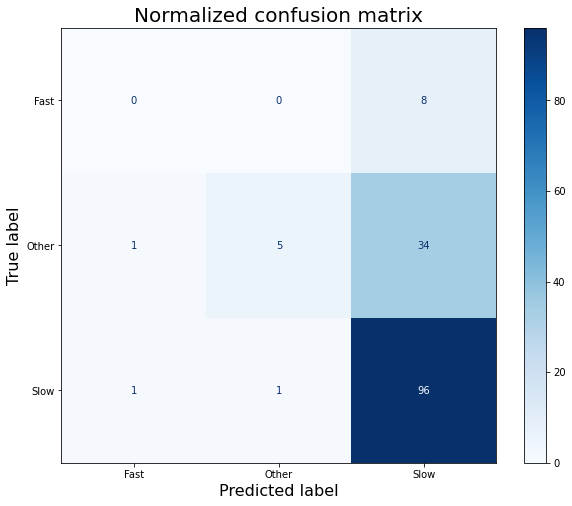

  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.80      0.10      0.18        40
           2       0.69      0.99      0.81        98

    accuracy                           0.69       146
   macro avg       0.50      0.36      0.33       146
weighted avg       0.68      0.69      0.59       146

Normalized confusion matrix:
[[ 0  0  8]
 [ 0  4 36]
 [ 0  1 97]]


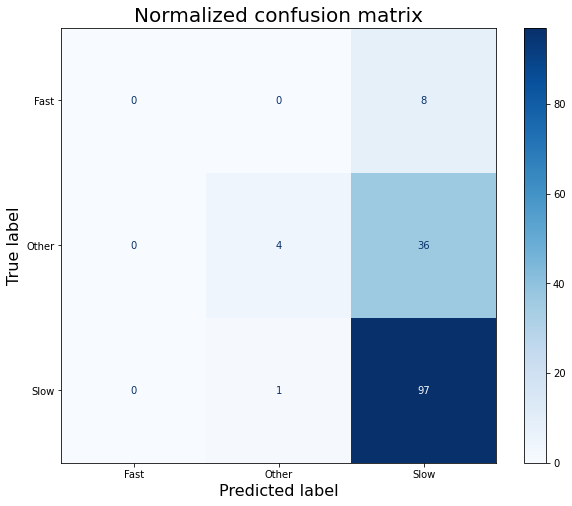

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.42      0.57      0.48        40
           2       0.73      0.65      0.69        98

    accuracy                           0.60       146
   macro avg       0.38      0.41      0.39       146
weighted avg       0.60      0.60      0.59       146

Normalized confusion matrix:
[[ 0  1  7]
 [ 0 23 17]
 [ 3 31 64]]


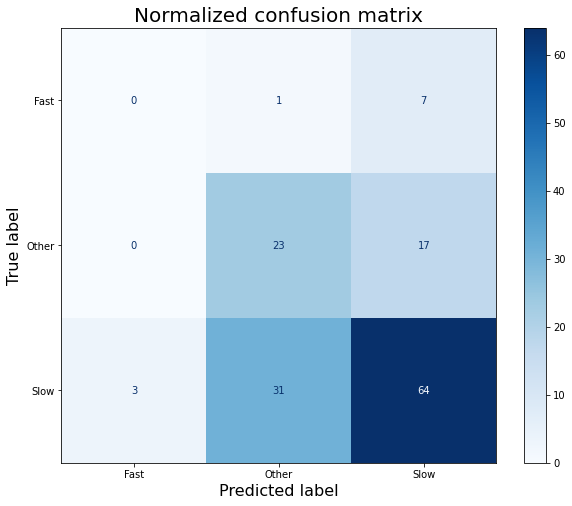

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.55      0.15      0.24        40
           2       0.69      0.94      0.80        98

    accuracy                           0.67       146
   macro avg       0.41      0.36      0.34       146
weighted avg       0.61      0.67      0.60       146

Normalized confusion matrix:
[[ 0  0  8]
 [ 1  6 33]
 [ 1  5 92]]


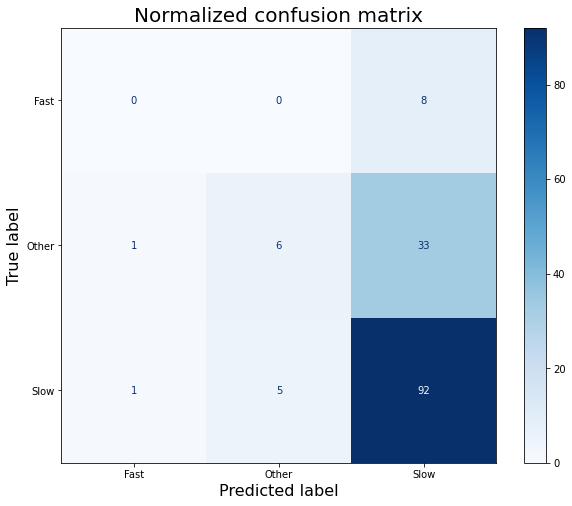

In [39]:
!unzip 5.zip
_, _ = one_loop(x=None, print_results=True)

# 25 percentile

## Data preprocessing

In [40]:
!unzip 1.zip
data_train_raw = pd.read_csv('content/data/data_train_full_new.csv')
data_test_raw = pd.read_csv('content/data/data_test_new.csv')

# y values
y_train_cat = data_train_raw['category'].to_numpy()
y_test_cat = data_test_raw['category'].to_numpy()
le = LabelEncoder()
le.fit(y_train_cat)
y_train = le.transform(y_train_cat)
y_test = le.transform(y_test_cat)

# One-hot encode categorical features
X_train = encode(data_train_raw.drop(columns=['ID', 'slope', 'r2', 'category']))
X_test_raw = encode(data_test_raw.drop(columns=['ID', 'slope', 'r2', 'category']))

# Fix missing values
col_list = list(X_train.columns.values)
X_test = X_test_raw.reindex(columns=col_list).fillna(0)
X_test = X_test[col_list]

data_train_list, data_val_list = [], []
for i in range(5):
    train_raw = pd.read_csv('content/data/data_cv_train_' + str(i+1) + '.csv')
    val_raw = pd.read_csv('content/data/data_cv_val_' + str(i+1) + '.csv')

    y_train_cat = train_raw['category'].to_numpy()
    y_val_cat = val_raw['category'].to_numpy()
    y_train = le.transform(y_train_cat)
    y_val = le.transform(y_val_cat)

    X_train = encode(train_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)
    X_val = encode(val_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)

    X_train = X_train[col_list]
    X_val = X_val[col_list]

    data_train_list.append((X_train, y_train))
    data_val_list.append((X_val, y_val))

Archive:  1.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  


In [41]:
data_train_raw.groupby(['category']).size()

category
Fast     101
Other    182
Slow     304
dtype: int64

In [42]:
data_test_raw.groupby(['category']).size()

category
Fast     23
Other    42
Slow     69
dtype: int64

## Hyperparameter tuning

In [ ]:
k_vals = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
knn_accuracies = []
knn_std = []

# Peform stratified 5-fold CV
for k in tqdm(k_vals):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    knn_accuracies.append(np.mean(scores))
    knn_std.append(np.std(scores))
    
# Best value and accuracy
knn_best_index = np.argmax(knn_accuracies)
knn_best_k = k_vals[knn_best_index]
knn_best_accuracy = knn_accuracies[knn_best_index]
knn_best_std = knn_std[knn_best_index]
print('Best k: ', knn_best_k)
print('Best cross-validation accuracy: %0.4f' % (knn_best_accuracy))
print('Standard deviation: %0.4f' % (knn_best_std))

  0%|          | 0/15 [00:00<?, ?it/s]

Best k:  30
Best cross-validation accuracy: 0.5486
Standard deviation: 0.0197


In [ ]:
# Regularisation values
lr_C_vals = np.logspace(-1, 5, num=7)
lr_accuracies = []
lr_std = []

# Peform stratified 5-fold CV
for c in tqdm(lr_C_vals):
    model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=c)
    scores = cv(model, data_train_list, data_val_list)
    lr_accuracies.append(np.mean(scores))
    lr_std.append(np.std(scores))
    
# Best value and accuracy
lr_best_index = np.argmax(lr_accuracies)
lr_best_c = lr_C_vals[lr_best_index]
lr_best_accuracy = lr_accuracies[lr_best_index]
lr_best_std = lr_std[lr_best_index]
print('Best c: ', lr_best_c)
print('Best cross-validation accuracy: %0.4f' % (lr_best_accuracy))
print('Standard deviation: %0.4f' % (lr_best_std))

  0%|          | 0/7 [00:00<?, ?it/s]

Best c:  0.1
Best cross-validation accuracy: 0.5128
Standard deviation: 0.0336


In [ ]:
rf_n_estimators_list= [100, 200, 300, 400, 500]
rf_accuracies = []
rf_std = []

# Peform stratified 5-fold CV
for n in tqdm(rf_n_estimators_list):
    model = RandomForestClassifier(n_estimators=n, criterion='gini', random_state=1, n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    rf_accuracies.append(np.mean(scores))
    rf_std.append(np.std(scores))
    
# Best value and accuracy
rf_best_index = np.argmax(rf_accuracies)
rf_best_n = rf_n_estimators_list[rf_best_index]
rf_best_accuracy = rf_accuracies[rf_best_index]
rf_best_std = rf_std[rf_best_index]
print('Best n_estimators: ', rf_best_n)
print('Best cross-validation accuracy: %0.4f' % (rf_best_accuracy))
print('Standard deviation: %0.4f' % (rf_best_std))

  0%|          | 0/5 [00:00<?, ?it/s]

Best n_estimators:  200
Best cross-validation accuracy: 0.5469
Standard deviation: 0.0490


In [ ]:
svc_C_vals = np.logspace(-1, 3, num=5)
svc_degree_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    
params = []
best_score = 0.0
best_score_std = 0.0
for i in svc_C_vals:
    for j in svc_degree_vals:
        params.append((i, j))
for i in tnrange(len(params)):
    model = SVC(C=params[i][0], kernel='poly', degree=params[i][1], random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/60 [00:00<?, ?it/s]

Best params:  (100.0, 6)
Best cross-validation accuracy: 0.5469
Standard deviation: 0.0214


In [ ]:
svc_C_vals = np.logspace(-1, 5, num=7)
svc_accuracies = []
svc_std = []

# Peform stratified 5-fold CV
for c in tqdm(svc_C_vals):
    model = SVC(C=c, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    svc_accuracies.append(np.mean(scores))
    svc_std.append(np.std(scores))
    
# Best value and accuracy
svc_best_index = np.argmax(svc_accuracies)
svc_best_c = svc_C_vals[svc_best_index]
svc_best_accuracy = svc_accuracies[svc_best_index]
svc_best_std = svc_std[svc_best_index]
print('Best C: ', svc_best_c)
print('Best cross-validation accuracy: %0.4f' % (svc_best_accuracy))
print('Standard deviation: %0.4f' % (svc_best_std))

  0%|          | 0/7 [00:00<?, ?it/s]

Best C:  1000.0
Best cross-validation accuracy: 0.5452
Standard deviation: 0.0294


In [ ]:
eta = [0.1, 0.3, 0.5]
max_depth = [1, 2, 3, 5, 10]
min_child_weight = [0.5, 1, 2, 3, 5]

params = []
best_score = 0.0
best_score_std = 0.0
for i in eta:
    for j in max_depth:
        for k in min_child_weight:
            params.append((i, j, k))
for i in tnrange(len(params)):
    model = XGBClassifier(eta=params[i][0], max_depth=params[i][1], min_child_weight=params[i][2], random_state=1, use_label_encoder=False, n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1], params[i][2])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/75 [00:00<?, ?it/s]

Best params:  (0.1, 1, 0.5)
Best cross-validation accuracy: 0.5468
Standard deviation: 0.0287


In [ ]:
adbst_n_estimators_list= [50, 100, 200, 300]
adbst_accuracies = []
adbst_std = []

# Peform stratified 5-fold CV
for n in tqdm(adbst_n_estimators_list):
    model = AdaBoostClassifier(n_estimators=n, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    adbst_accuracies.append(np.mean(scores))
    adbst_std.append(np.std(scores))
    
# Best value and accuracy
adbst_best_index = np.argmax(adbst_accuracies)
adbst_best_n = adbst_n_estimators_list[adbst_best_index]
adbst_best_accuracy = adbst_accuracies[adbst_best_index]
adbst_best_std = adbst_std[adbst_best_index]
print('Best n_estimators: ', adbst_best_n)
print('Best cross-validation accuracy: %0.4f' % (adbst_best_accuracy))
print('Standard deviation: %0.4f' % (adbst_best_std))

  0%|          | 0/4 [00:00<?, ?it/s]

Best n_estimators:  50
Best cross-validation accuracy: 0.5009
Standard deviation: 0.0477


In [ ]:
hidden_layer_sizes = [(100,), (200,), (500,), (1000,)]
learning_rate_init = [0.1, 0.05, 0.01, 0.005, 0.001]

params = []
best_score = 0.0
best_score_std = 0.0
for i in hidden_layer_sizes:
    for j in learning_rate_init:
        params.append((i, j))
for i in tnrange(len(params)):
    model = MLPClassifier(hidden_layer_sizes=params[i][0], learning_rate_init=params[i][1], max_iter=1000, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/20 [00:00<?, ?it/s]

Best params:  ((200,), 0.05)
Best cross-validation accuracy: 0.5349
Standard deviation: 0.0165


## Testing

In [ ]:
class_dict = {0: 'Fast',
              1: 'Other',
              2: 'Slow'}
class_names = list(le.inverse_transform([0, 1, 2]))
print(class_names)

['Fast', 'Other', 'Slow']

0.5298507462686567


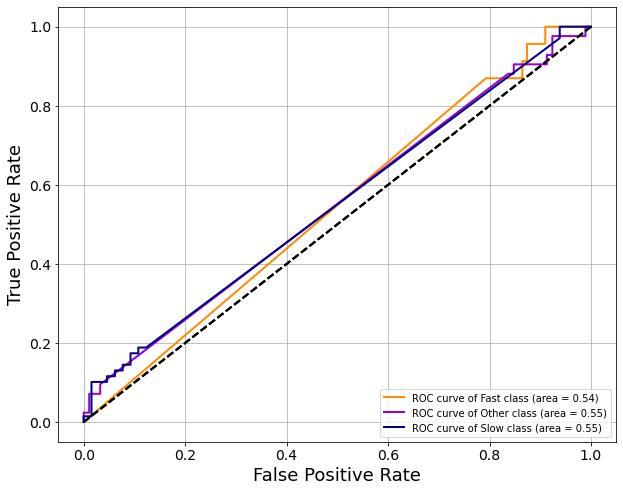

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.57      0.10      0.16        42
           2       0.53      0.97      0.68        69

    accuracy                           0.53       134
   macro avg       0.37      0.36      0.28       134
weighted avg       0.45      0.53      0.40       134

Normalized confusion matrix:
[[ 0  1 22]
 [ 0  4 38]
 [ 0  2 67]]


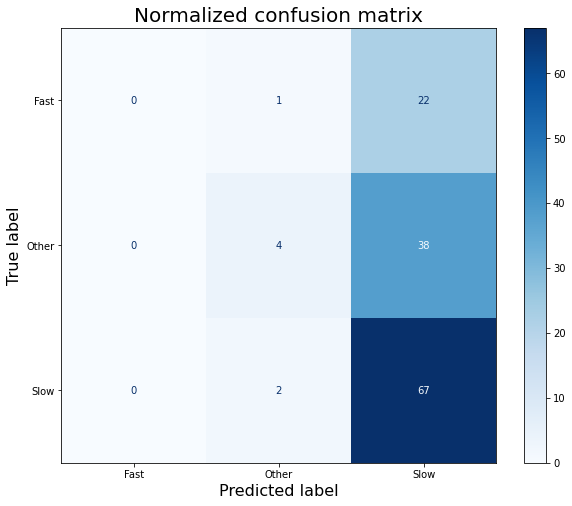

In [43]:
# Gaussian Process
model = GaussianProcessClassifier(random_state=1, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.48507462686567165


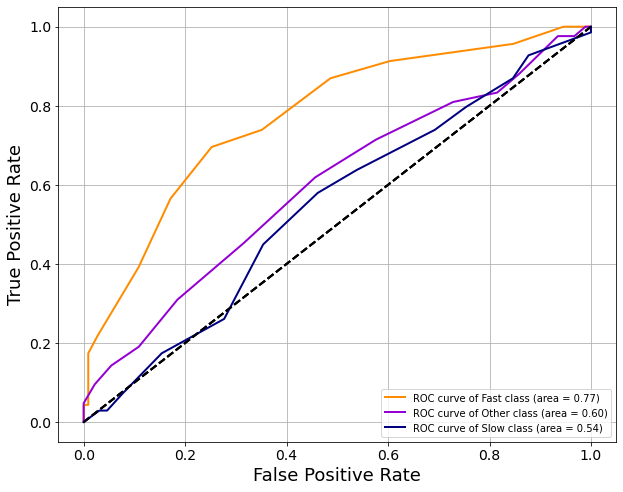

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.32      0.14      0.20        42
           2       0.51      0.86      0.64        69

    accuracy                           0.49       134
   macro avg       0.28      0.33      0.28       134
weighted avg       0.36      0.49      0.39       134

Normalized confusion matrix:
[[ 0  3 20]
 [ 0  6 36]
 [ 0 10 59]]


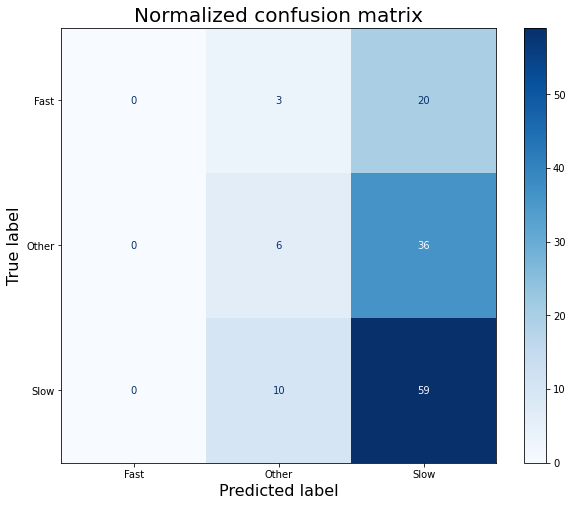

In [44]:
# KNN
model = KNeighborsClassifier(n_neighbors=30, algorithm='ball_tree', n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.582089552238806


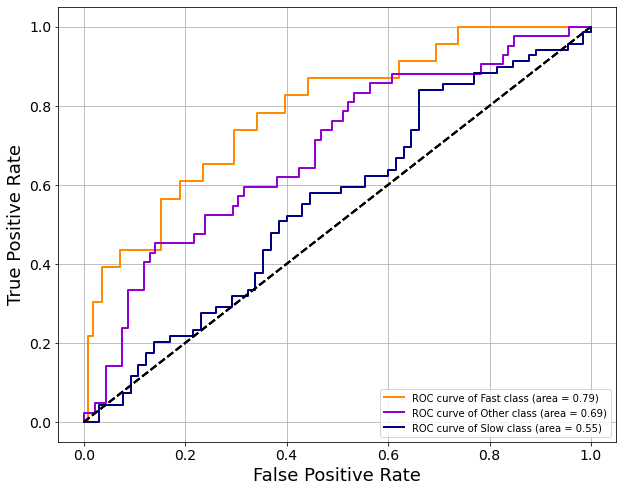

              precision    recall  f1-score   support

           0       0.75      0.26      0.39        23
           1       0.57      0.31      0.40        42
           2       0.57      0.86      0.69        69

    accuracy                           0.58       134
   macro avg       0.63      0.48      0.49       134
weighted avg       0.60      0.58      0.55       134

Normalized confusion matrix:
[[ 6  1 16]
 [ 1 13 28]
 [ 1  9 59]]


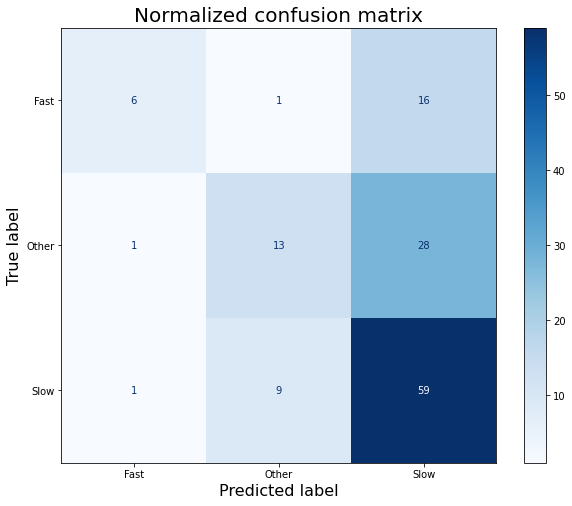

In [45]:
# Logistic Regression
model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=0.1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.5298507462686567


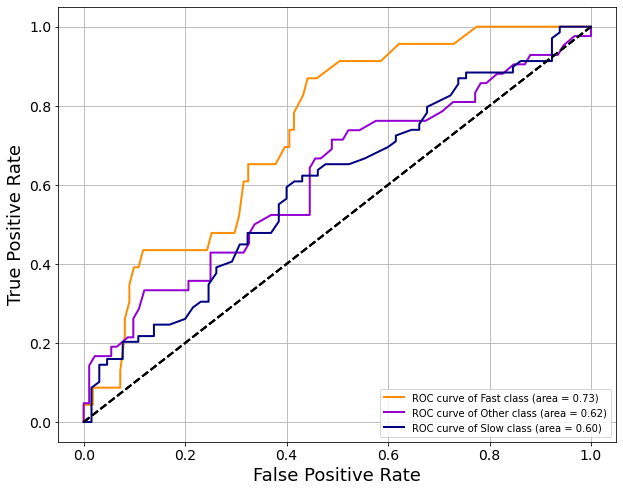

              precision    recall  f1-score   support

           0       0.33      0.04      0.08        23
           1       0.50      0.33      0.40        42
           2       0.54      0.81      0.65        69

    accuracy                           0.53       134
   macro avg       0.46      0.40      0.38       134
weighted avg       0.49      0.53      0.47       134

Normalized confusion matrix:
[[ 1  2 20]
 [ 1 14 27]
 [ 1 12 56]]


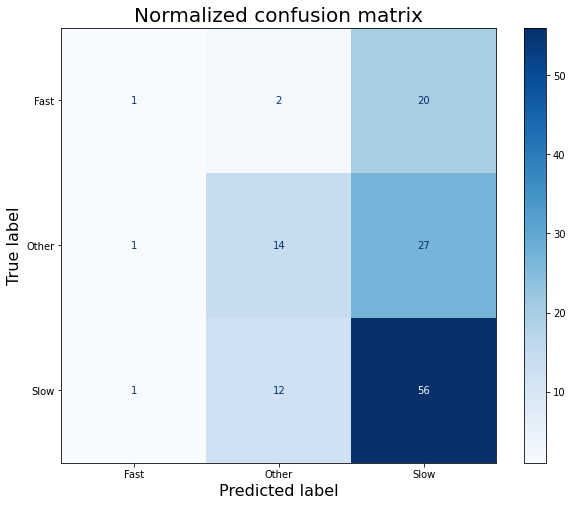

In [46]:
# Random Forest
model = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=1, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.5
              precision    recall  f1-score   support

           0       0.45      0.22      0.29        23
           1       0.00      0.00      0.00        42
           2       0.53      0.90      0.66        69

    accuracy                           0.50       134
   macro avg       0.33      0.37      0.32       134
weighted avg       0.35      0.50      0.39       134

Normalized confusion matrix:
[[ 5  1 17]
 [ 3  0 39]
 [ 3  4 62]]


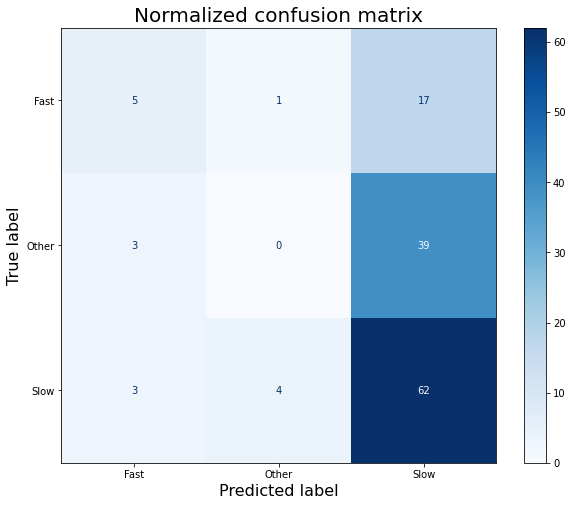

In [47]:
# SVC
model = SVC(C=100, kernel='poly', degree=6, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.5447761194029851
              precision    recall  f1-score   support

           0       0.40      0.17      0.24        23
           1       0.60      0.21      0.32        42
           2       0.55      0.87      0.67        69

    accuracy                           0.54       134
   macro avg       0.52      0.42      0.41       134
weighted avg       0.54      0.54      0.49       134

Normalized confusion matrix:
[[ 4  1 18]
 [ 2  9 31]
 [ 4  5 60]]


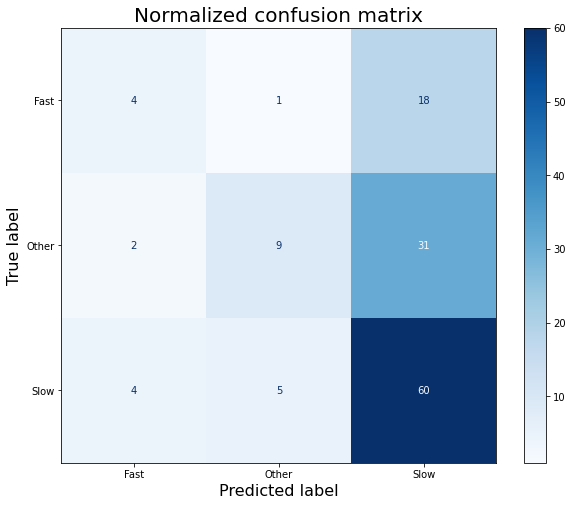

In [48]:
# SVC
model = SVC(C=1000, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.5671641791044776


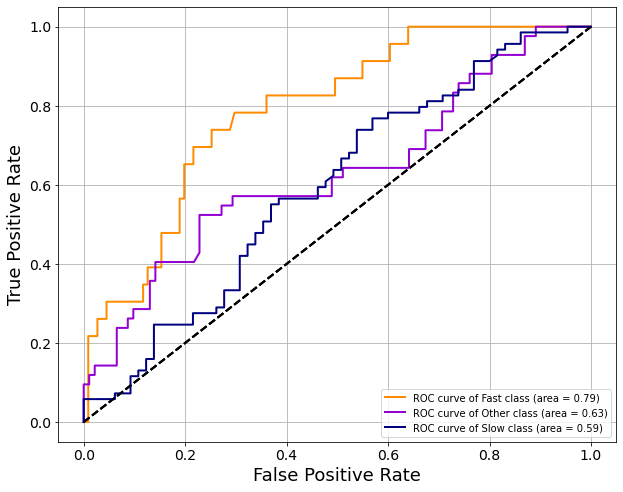

              precision    recall  f1-score   support

           0       0.83      0.22      0.34        23
           1       0.54      0.17      0.25        42
           2       0.56      0.93      0.70        69

    accuracy                           0.57       134
   macro avg       0.64      0.44      0.43       134
weighted avg       0.60      0.57      0.50       134

Normalized confusion matrix:
[[ 5  2 16]
 [ 0  7 35]
 [ 1  4 64]]


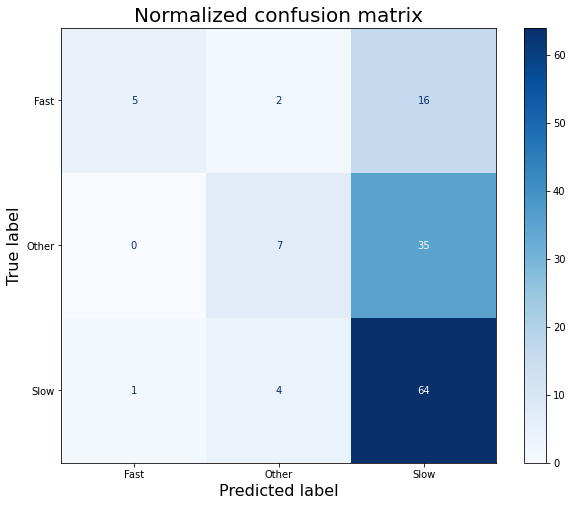

In [49]:
# XGBoost
model = XGBClassifier(max_depth=1, eta=0.1, min_child_weight=0.5, random_state=1, use_label_encoder=False, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.4925373134328358


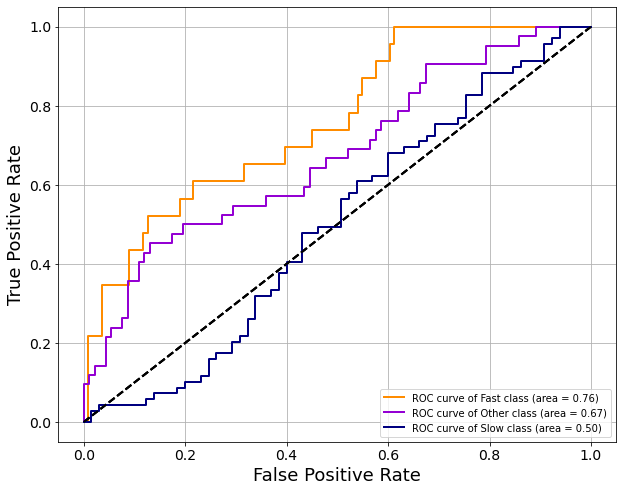

              precision    recall  f1-score   support

           0       0.43      0.26      0.32        23
           1       0.42      0.38      0.40        42
           2       0.54      0.64      0.58        69

    accuracy                           0.49       134
   macro avg       0.46      0.43      0.44       134
weighted avg       0.48      0.49      0.48       134

Normalized confusion matrix:
[[ 6  4 13]
 [ 1 16 25]
 [ 7 18 44]]


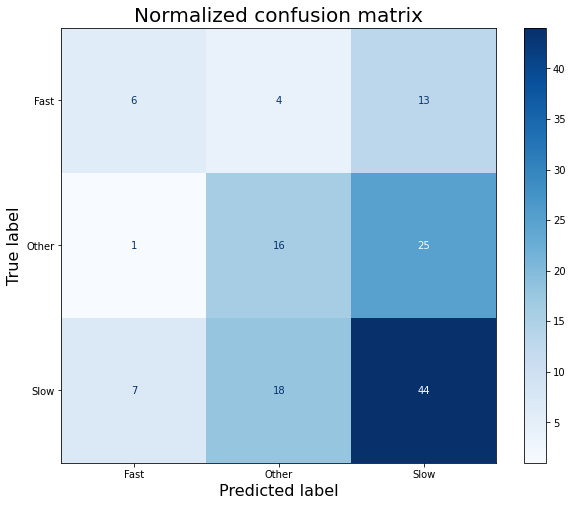

In [50]:
# Adaboost
model = AdaBoostClassifier(n_estimators=50, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.5522388059701493


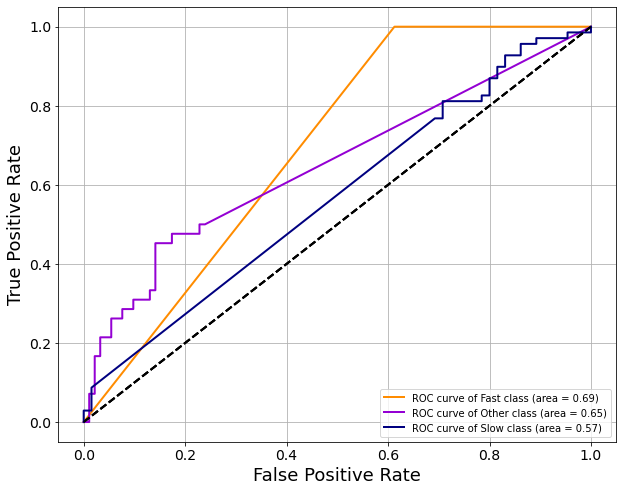

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.67      0.24      0.35        42
           2       0.54      0.93      0.68        69

    accuracy                           0.55       134
   macro avg       0.40      0.39      0.34       134
weighted avg       0.49      0.55      0.46       134

Normalized confusion matrix:
[[ 0  0 23]
 [ 0 10 32]
 [ 0  5 64]]


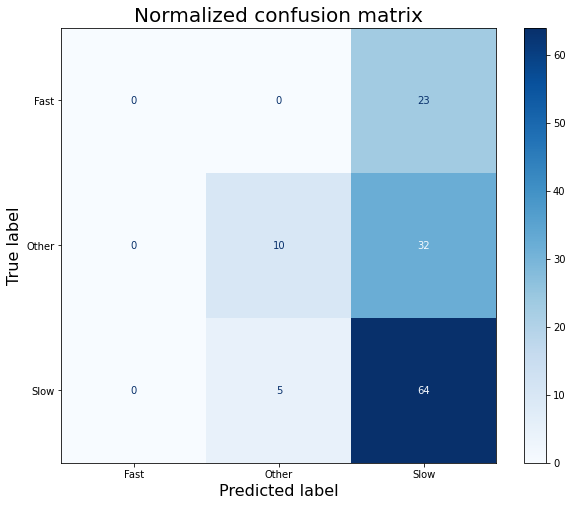

In [51]:
# Neural Network
model = MLPClassifier(hidden_layer_sizes=(200,), learning_rate_init=0.05, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

## Additional runs

Archive:  2.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.14      0.02      0.04        45
           2       0.50      0.94      0.65        68

    accuracy                           0.48       136
   macro avg       0.21      0.32      0.23       136
weighted a

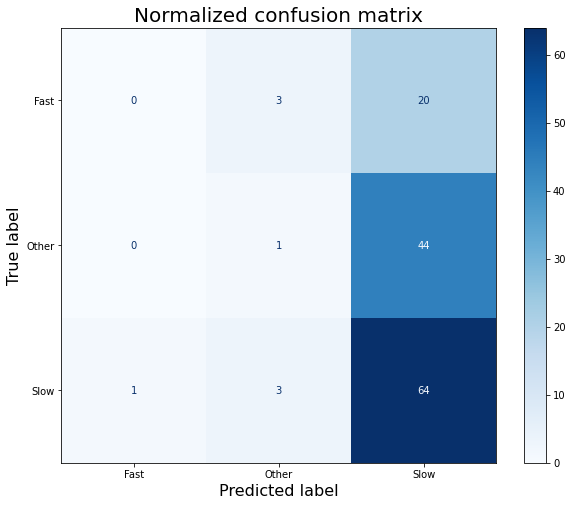

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.52      0.24      0.33        45
           2       0.51      0.85      0.64        68

    accuracy                           0.51       136
   macro avg       0.34      0.37      0.32       136
weighted avg       0.43      0.51      0.43       136

Normalized confusion matrix:
[[ 0  1 22]
 [ 0 11 34]
 [ 1  9 58]]


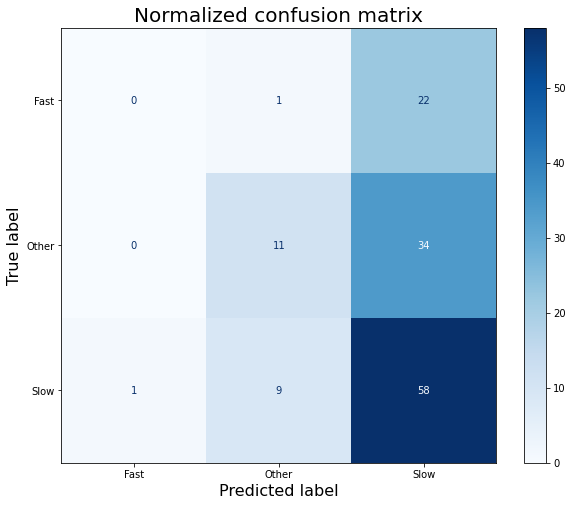

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.29      0.09      0.13        23
           1       0.56      0.31      0.40        45
           2       0.55      0.84      0.66        68

    accuracy                           0.54       136
   macro avg       0.46      0.41      0.40       136
weighted avg       0.51      0.54      0.49       136

Normalized confusion matrix:
[[ 2  1 20]
 [ 4 14 27]
 [ 1 10 57]]


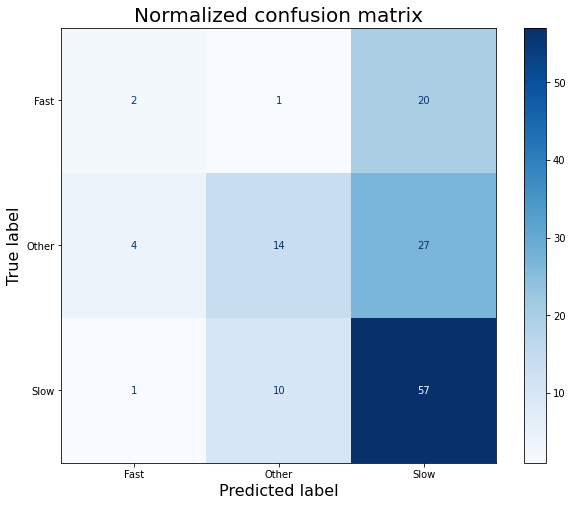

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.09      0.14        23
           1       0.48      0.33      0.39        45
           2       0.53      0.76      0.62        68

    accuracy                           0.51       136
   macro avg       0.45      0.39      0.39       136
weighted avg       0.48      0.51      0.47       136

Normalized confusion matrix:
[[ 2  3 18]
 [ 1 15 29]
 [ 3 13 52]]


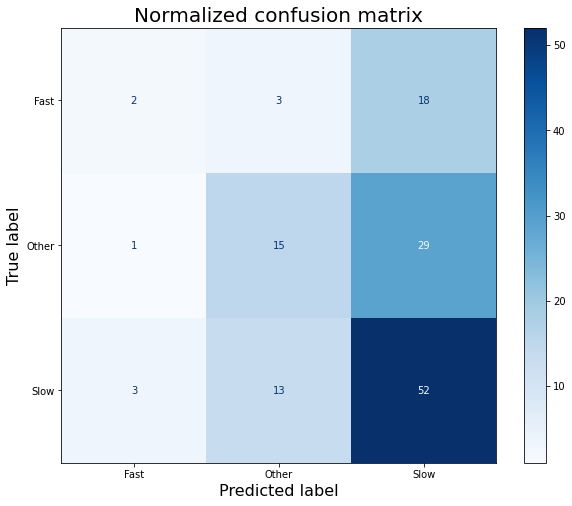

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.17      0.04      0.07        23
           1       0.62      0.29      0.39        45
           2       0.52      0.84      0.64        68

    accuracy                           0.52       136
   macro avg       0.44      0.39      0.37       136
weighted avg       0.49      0.52      0.46       136

Normalized confusion matrix:
[[ 1  1 21]
 [ 1 13 31]
 [ 4  7 57]]


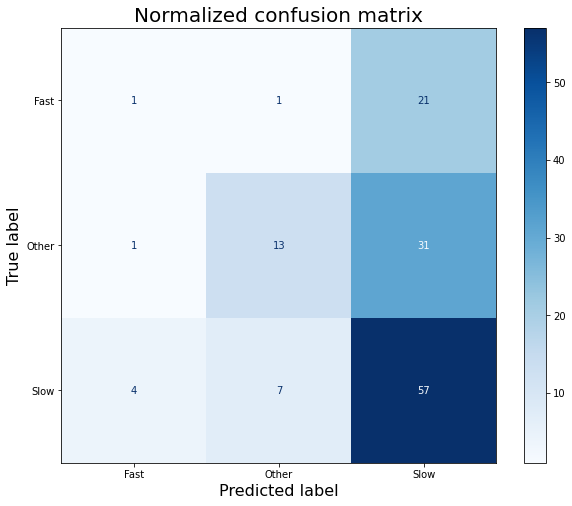

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.08      0.04      0.06        23
           1       0.58      0.33      0.42        45
           2       0.52      0.74      0.61        68

    accuracy                           0.49       136
   macro avg       0.39      0.37      0.36       136
weighted avg       0.46      0.49      0.45       136

Normalized confusion matrix:
[[ 1  2 20]
 [ 3 15 27]
 [ 9  9 50]]


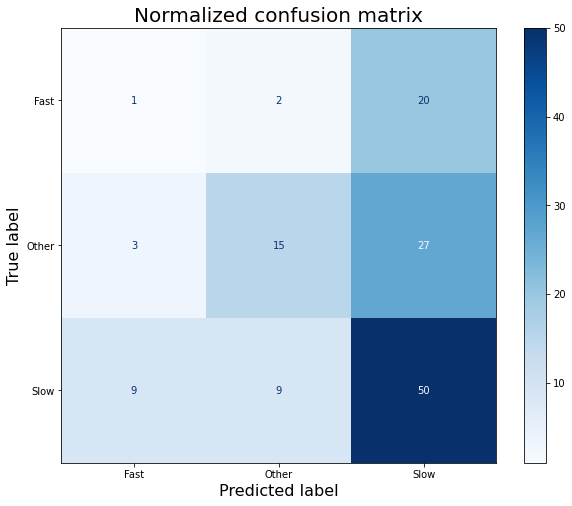

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.40      0.09      0.14        23
           1       0.45      0.11      0.18        45
           2       0.51      0.90      0.65        68

    accuracy                           0.50       136
   macro avg       0.45      0.37      0.32       136
weighted avg       0.47      0.50      0.41       136

Normalized confusion matrix:
[[ 2  1 20]
 [ 1  5 39]
 [ 2  5 61]]


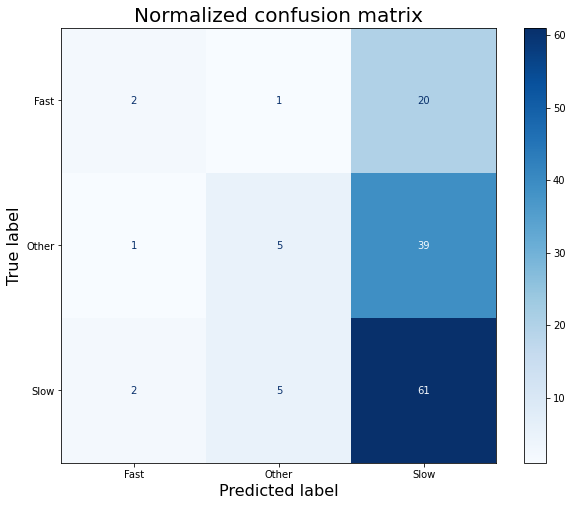

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.11      0.04      0.06        23
           1       0.36      0.22      0.27        45
           2       0.51      0.74      0.60        68

    accuracy                           0.45       136
   macro avg       0.32      0.33      0.31       136
weighted avg       0.39      0.45      0.40       136

Normalized confusion matrix:
[[ 1  5 17]
 [ 3 10 32]
 [ 5 13 50]]


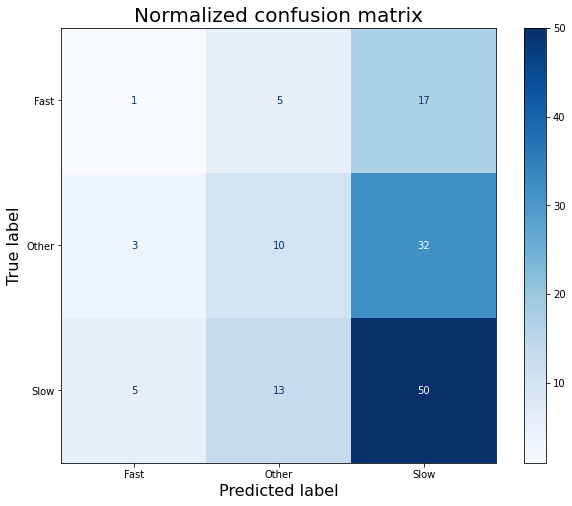

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.55      0.27      0.36        45
           2       0.51      0.82      0.63        68

    accuracy                           0.50       136
   macro avg       0.35      0.36      0.33       136
weighted avg       0.44      0.50      0.43       136

Normalized confusion matrix:
[[ 0  1 22]
 [ 1 12 32]
 [ 3  9 56]]


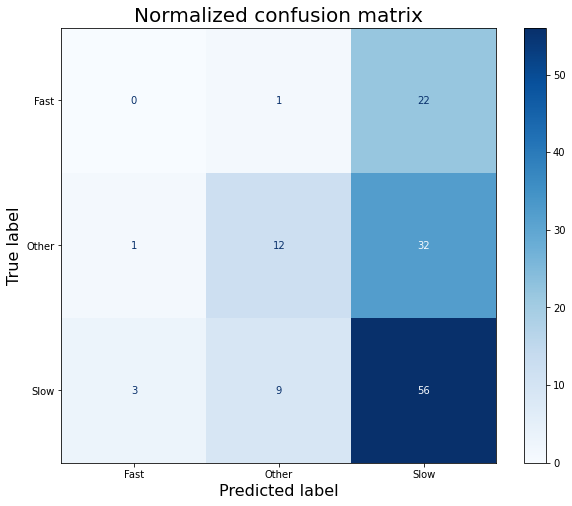

In [53]:
!unzip 2.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  3.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.44      0.16      0.24        43
           2       0.53      0.90      0.67        77

    accuracy                           0.52       146
   macro avg       0.32      0.35      0.30       146
weighted a

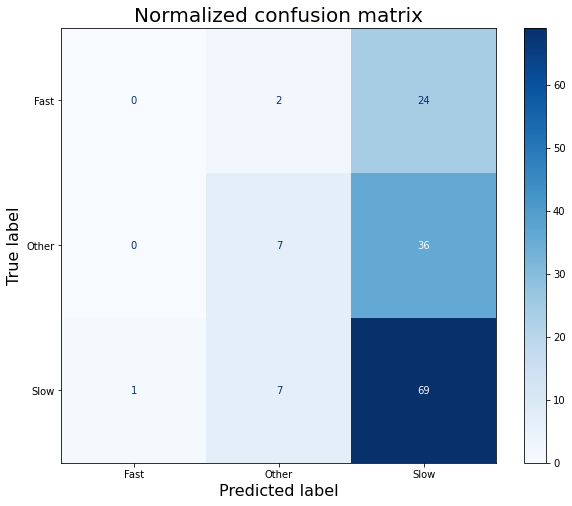

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.04      0.07        26
           1       0.64      0.16      0.26        43
           2       0.55      0.96      0.70        77

    accuracy                           0.56       146
   macro avg       0.73      0.39      0.34       146
weighted avg       0.66      0.56      0.46       146

Normalized confusion matrix:
[[ 1  1 24]
 [ 0  7 36]
 [ 0  3 74]]


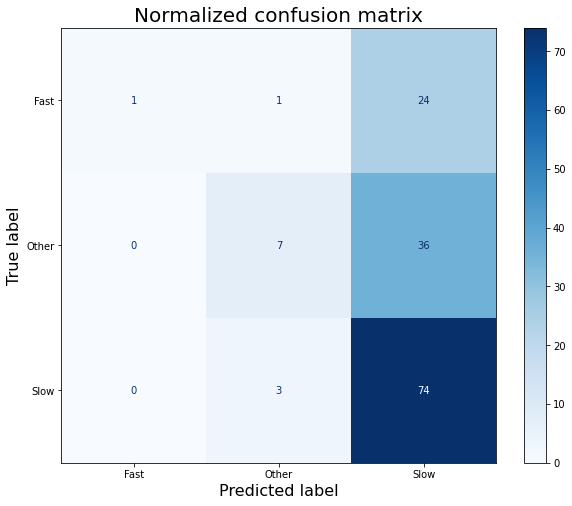

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.23      0.33        26
           1       0.46      0.28      0.35        43
           2       0.55      0.78      0.64        77

    accuracy                           0.53       146
   macro avg       0.54      0.43      0.44       146
weighted avg       0.53      0.53      0.50       146

Normalized confusion matrix:
[[ 6  0 20]
 [ 1 12 30]
 [ 3 14 60]]


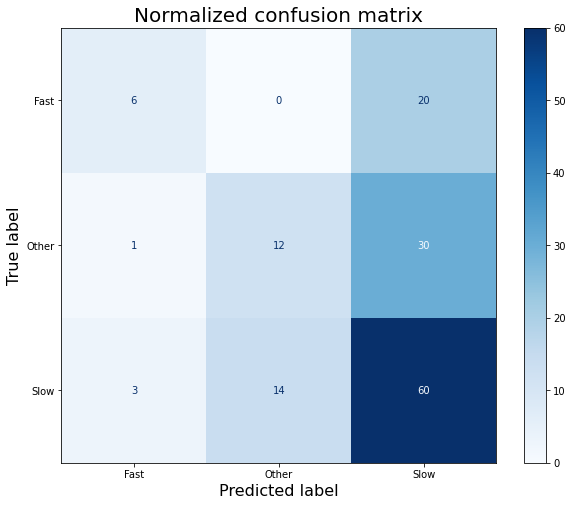

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.08      0.12        26
           1       0.42      0.37      0.40        43
           2       0.52      0.69      0.59        77

    accuracy                           0.49       146
   macro avg       0.42      0.38      0.37       146
weighted avg       0.46      0.49      0.45       146

Normalized confusion matrix:
[[ 2  2 22]
 [ 0 16 27]
 [ 4 20 53]]


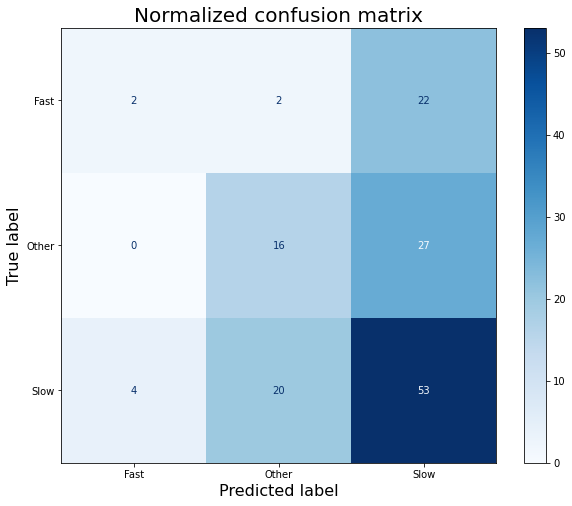

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.40      0.15      0.22        26
           1       0.47      0.21      0.29        43
           2       0.56      0.84      0.67        77

    accuracy                           0.53       146
   macro avg       0.48      0.40      0.39       146
weighted avg       0.50      0.53      0.48       146

Normalized confusion matrix:
[[ 4  2 20]
 [ 2  9 32]
 [ 4  8 65]]


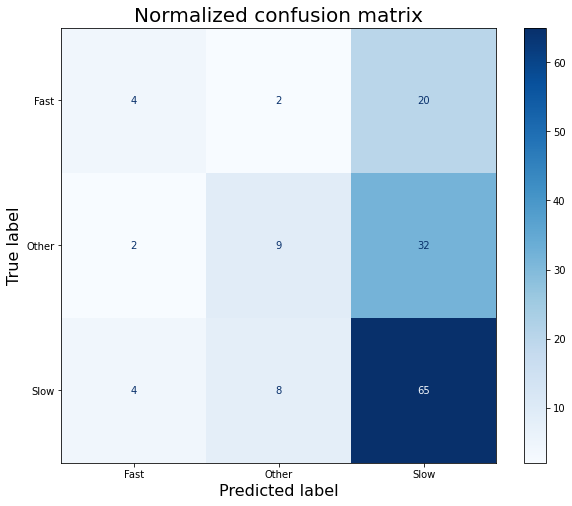

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.08      0.14        26
           1       0.67      0.14      0.23        43
           2       0.55      0.96      0.70        77

    accuracy                           0.56       146
   macro avg       0.74      0.39      0.36       146
weighted avg       0.66      0.56      0.46       146

Normalized confusion matrix:
[[ 2  0 24]
 [ 0  6 37]
 [ 0  3 74]]


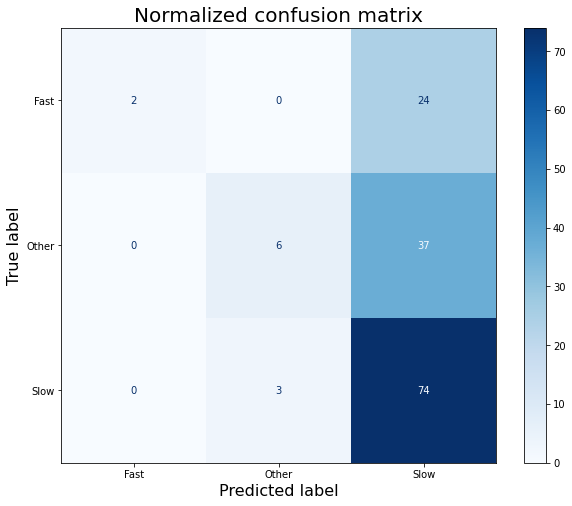

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.08      0.14        26
           1       0.73      0.19      0.30        43
           2       0.55      0.95      0.70        77

    accuracy                           0.57       146
   macro avg       0.65      0.40      0.38       146
weighted avg       0.62      0.57      0.48       146

Normalized confusion matrix:
[[ 2  0 24]
 [ 0  8 35]
 [ 1  3 73]]


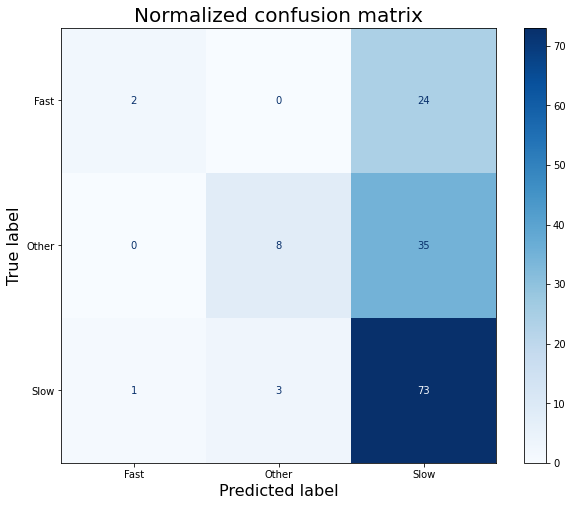

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.21      0.12      0.15        26
           1       0.32      0.28      0.30        43
           2       0.54      0.66      0.59        77

    accuracy                           0.45       146
   macro avg       0.36      0.35      0.35       146
weighted avg       0.42      0.45      0.43       146

Normalized confusion matrix:
[[ 3  8 15]
 [ 2 12 29]
 [ 9 17 51]]


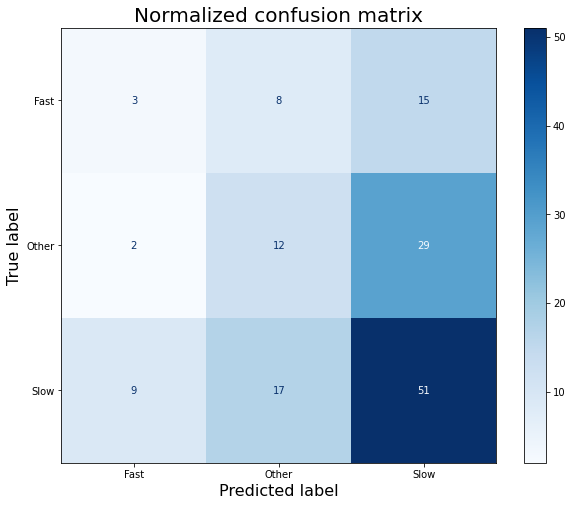

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.04      0.07        26
           1       0.75      0.07      0.13        43
           2       0.53      0.96      0.69        77

    accuracy                           0.53       146
   macro avg       0.54      0.36      0.29       146
weighted avg       0.56      0.53      0.41       146

Normalized confusion matrix:
[[ 1  0 25]
 [ 0  3 40]
 [ 2  1 74]]


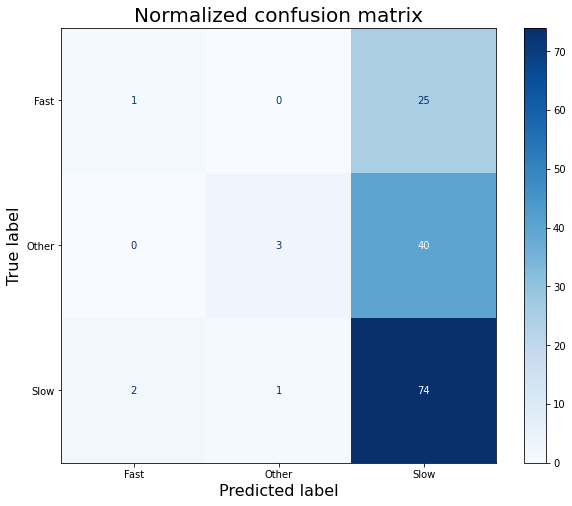

In [54]:
!unzip 3.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  4.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.22      0.05      0.08        42
           2       0.46      0.91      0.61        64

    accuracy                           0.44       136
   macro avg       0.23      0.32      0.23       136
weighted a

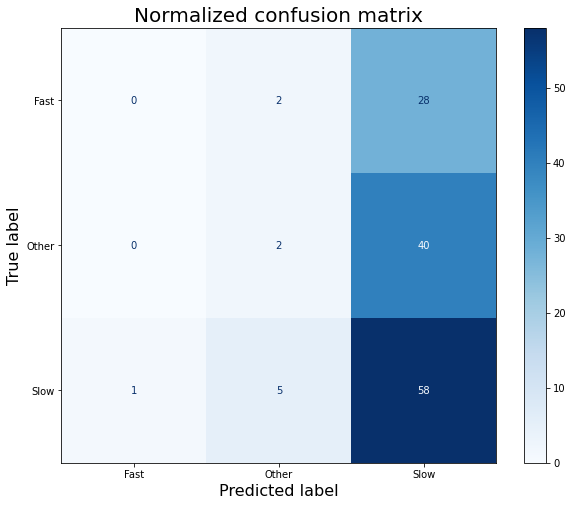

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.20      0.03      0.06        30
           1       0.27      0.07      0.11        42
           2       0.47      0.88      0.61        64

    accuracy                           0.44       136
   macro avg       0.31      0.33      0.26       136
weighted avg       0.35      0.44      0.33       136

Normalized confusion matrix:
[[ 1  1 28]
 [ 3  3 36]
 [ 1  7 56]]


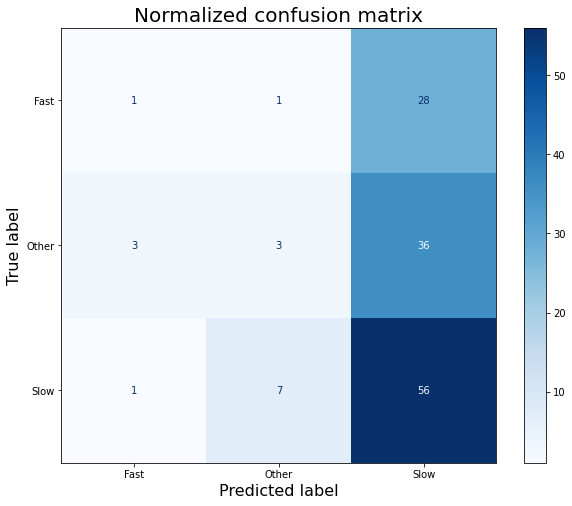

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.45      0.17      0.24        30
           1       0.52      0.33      0.41        42
           2       0.50      0.77      0.60        64

    accuracy                           0.50       136
   macro avg       0.49      0.42      0.42       136
weighted avg       0.50      0.50      0.46       136

Normalized confusion matrix:
[[ 5  1 24]
 [ 3 14 25]
 [ 3 12 49]]


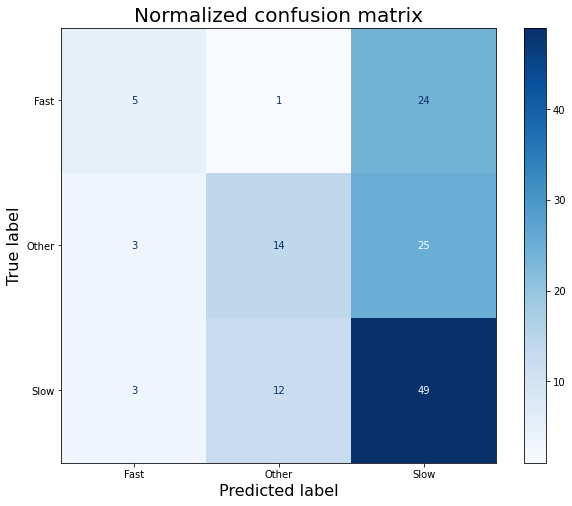

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.44      0.13      0.21        30
           1       0.34      0.24      0.28        42
           2       0.48      0.73      0.58        64

    accuracy                           0.45       136
   macro avg       0.42      0.37      0.36       136
weighted avg       0.43      0.45      0.41       136

Normalized confusion matrix:
[[ 4  5 21]
 [ 2 10 30]
 [ 3 14 47]]


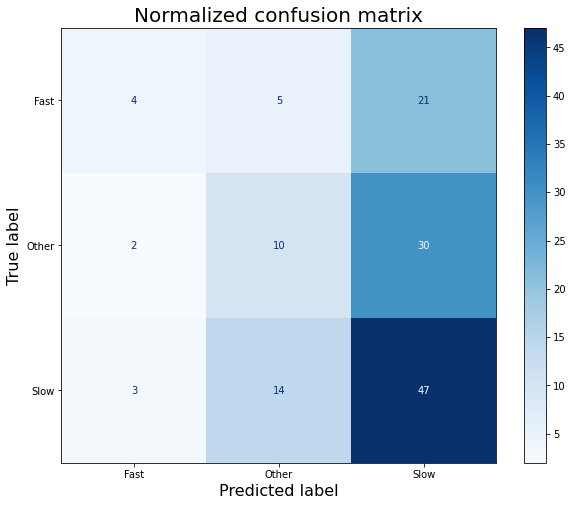

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.17      0.28        30
           1       0.44      0.17      0.24        42
           2       0.49      0.88      0.63        64

    accuracy                           0.50       136
   macro avg       0.59      0.40      0.38       136
weighted avg       0.55      0.50      0.43       136

Normalized confusion matrix:
[[ 5  1 24]
 [ 1  7 34]
 [ 0  8 56]]


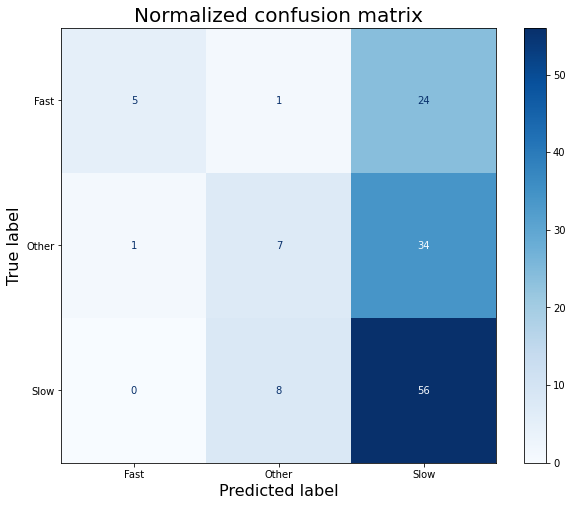

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.29      0.13      0.18        30
           1       0.35      0.19      0.25        42
           2       0.49      0.77      0.60        64

    accuracy                           0.45       136
   macro avg       0.38      0.36      0.34       136
weighted avg       0.40      0.45      0.40       136

Normalized confusion matrix:
[[ 4  4 22]
 [ 6  8 28]
 [ 4 11 49]]


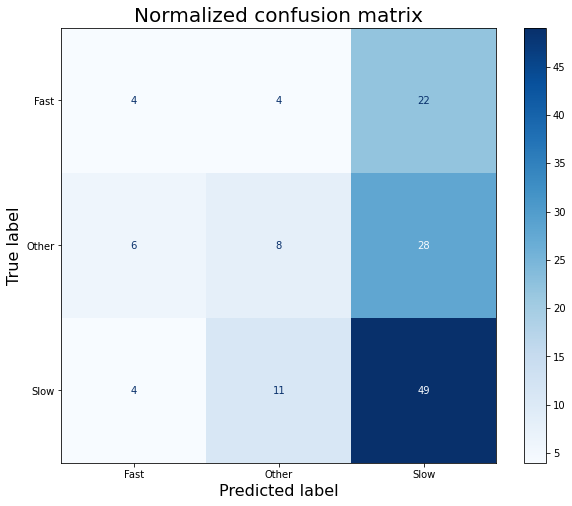

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.50      0.13      0.21        30
           1       0.46      0.14      0.22        42
           2       0.49      0.88      0.63        64

    accuracy                           0.49       136
   macro avg       0.48      0.38      0.35       136
weighted avg       0.48      0.49      0.41       136

Normalized confusion matrix:
[[ 4  0 26]
 [ 3  6 33]
 [ 1  7 56]]


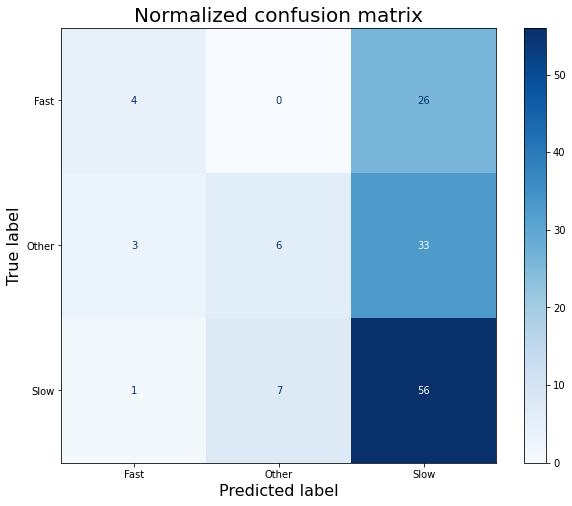

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.22      0.07      0.10        30
           1       0.41      0.26      0.32        42
           2       0.47      0.73      0.57        64

    accuracy                           0.44       136
   macro avg       0.37      0.35      0.33       136
weighted avg       0.40      0.44      0.39       136

Normalized confusion matrix:
[[ 2  4 24]
 [ 2 11 29]
 [ 5 12 47]]


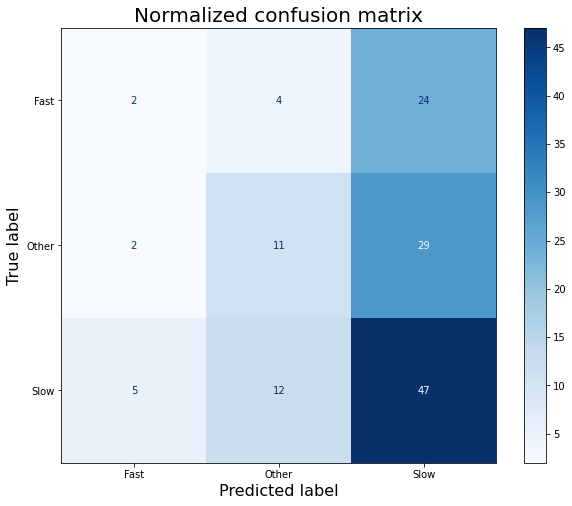

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.38      0.10      0.16        30
           1       0.67      0.05      0.09        42
           2       0.49      0.95      0.65        64

    accuracy                           0.49       136
   macro avg       0.51      0.37      0.30       136
weighted avg       0.52      0.49      0.37       136

Normalized confusion matrix:
[[ 3  0 27]
 [ 3  2 37]
 [ 2  1 61]]


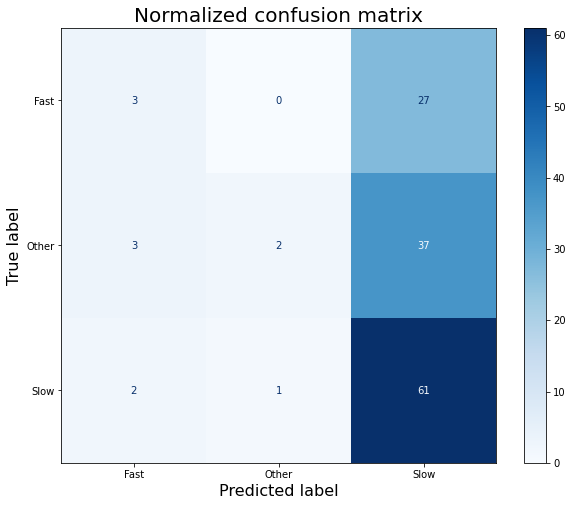

In [55]:
!unzip 4.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  5.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.20      0.04      0.07        24
           1       0.36      0.10      0.16        40
           2       0.55      0.87      0.67        82

    accuracy                           0.52       146
   macro avg       0.37      0.34      0.30       146
weighted a

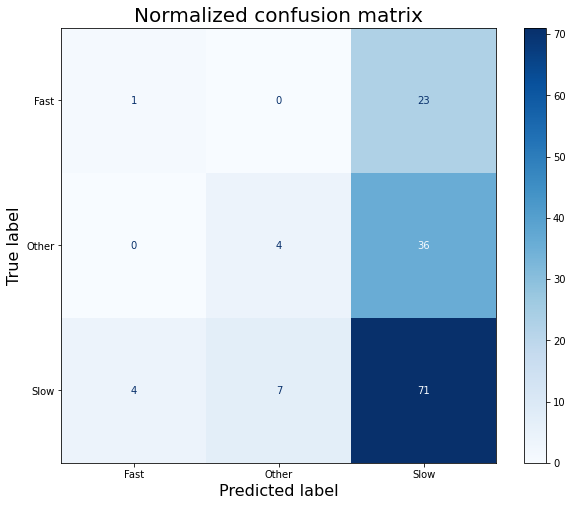

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.33      0.08      0.13        24
           1       0.52      0.38      0.43        40
           2       0.61      0.83      0.70        82

    accuracy                           0.58       146
   macro avg       0.49      0.43      0.42       146
weighted avg       0.54      0.58      0.54       146

Normalized confusion matrix:
[[ 2  4 18]
 [ 0 15 25]
 [ 4 10 68]]


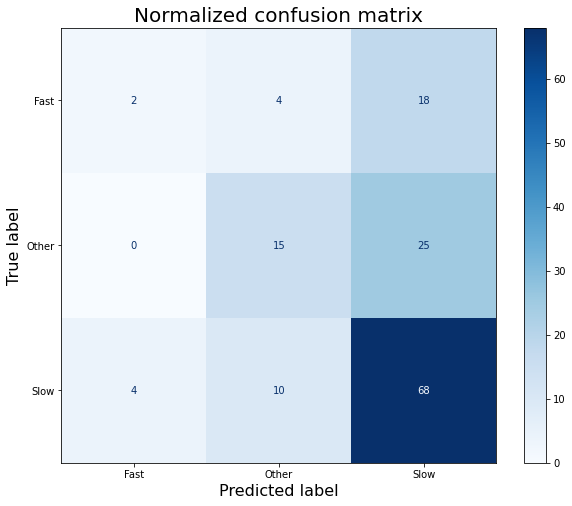

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.38      0.12      0.19        24
           1       0.47      0.40      0.43        40
           2       0.61      0.77      0.68        82

    accuracy                           0.56       146
   macro avg       0.48      0.43      0.43       146
weighted avg       0.53      0.56      0.53       146

Normalized confusion matrix:
[[ 3  1 20]
 [ 3 16 21]
 [ 2 17 63]]


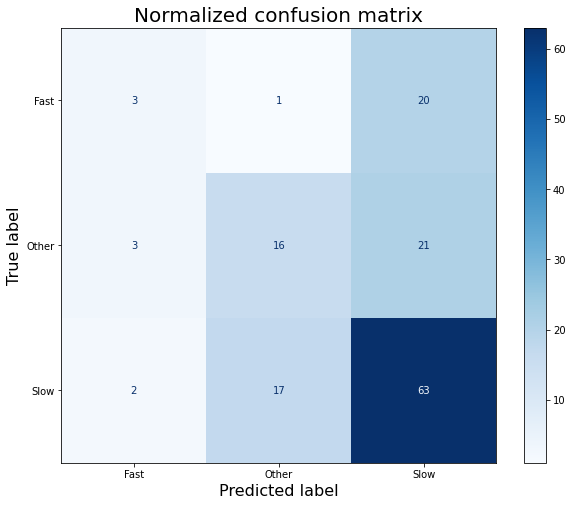

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.38      0.25      0.30        40
           2       0.56      0.79      0.65        82

    accuracy                           0.51       146
   macro avg       0.31      0.35      0.32       146
weighted avg       0.42      0.51      0.45       146

Normalized confusion matrix:
[[ 0  2 22]
 [ 0 10 30]
 [ 3 14 65]]


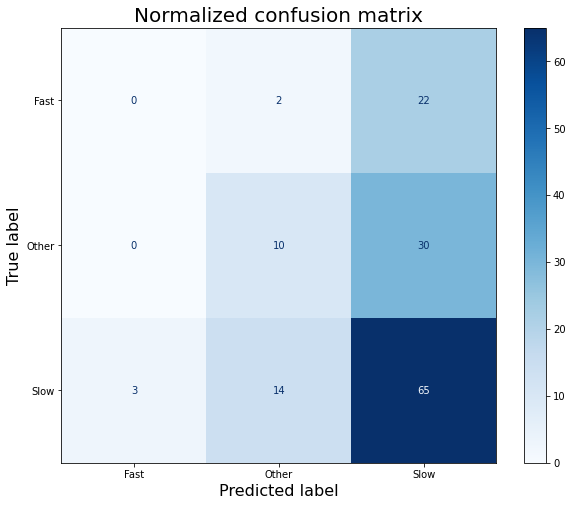

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.12      0.04      0.06        24
           1       0.41      0.17      0.25        40
           2       0.59      0.87      0.70        82

    accuracy                           0.54       146
   macro avg       0.37      0.36      0.34       146
weighted avg       0.46      0.54      0.47       146

Normalized confusion matrix:
[[ 1  4 19]
 [ 2  7 31]
 [ 5  6 71]]


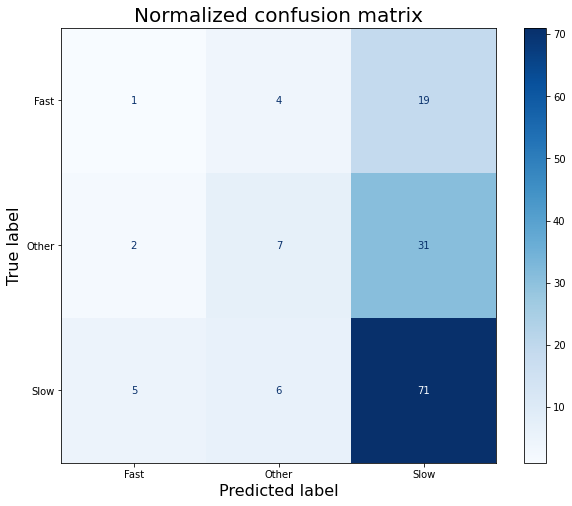

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.56      0.12      0.20        40
           2       0.58      0.94      0.72        82

    accuracy                           0.56       146
   macro avg       0.38      0.35      0.31       146
weighted avg       0.48      0.56      0.46       146

Normalized confusion matrix:
[[ 0  1 23]
 [ 2  5 33]
 [ 2  3 77]]


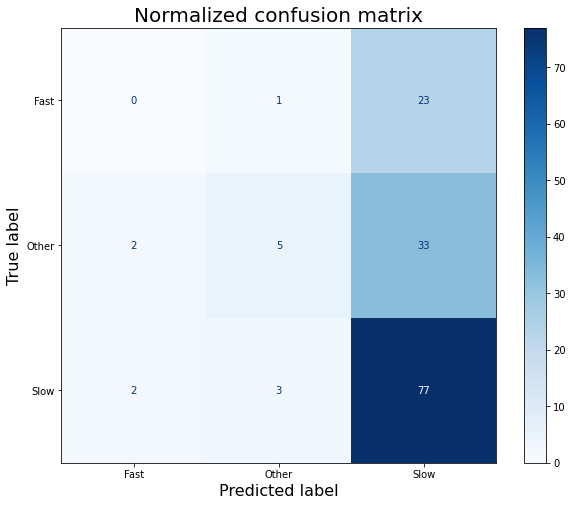

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        24
           1       0.44      0.17      0.25        40
           2       0.58      0.91      0.71        82

    accuracy                           0.57       146
   macro avg       0.67      0.38      0.35       146
weighted avg       0.61      0.57      0.48       146

Normalized confusion matrix:
[[ 1  2 21]
 [ 0  7 33]
 [ 0  7 75]]


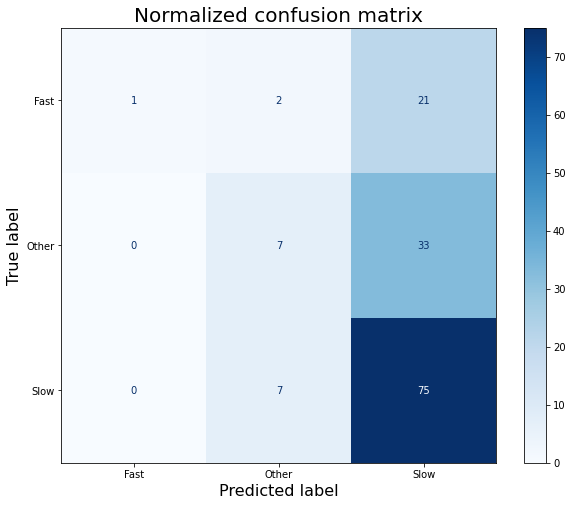

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.31      0.17      0.22        24
           1       0.32      0.28      0.30        40
           2       0.55      0.66      0.60        82

    accuracy                           0.47       146
   macro avg       0.39      0.37      0.37       146
weighted avg       0.45      0.47      0.45       146

Normalized confusion matrix:
[[ 4  2 18]
 [ 2 11 27]
 [ 7 21 54]]


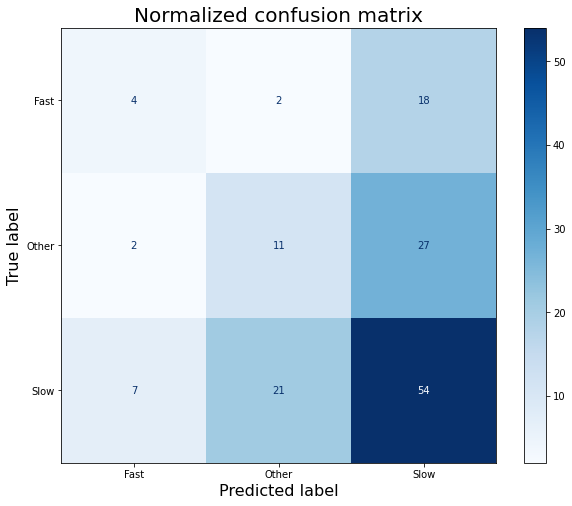

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.53      0.20      0.29        40
           2       0.60      0.91      0.73        82

    accuracy                           0.57       146
   macro avg       0.38      0.37      0.34       146
weighted avg       0.49      0.57      0.49       146

Normalized confusion matrix:
[[ 0  2 22]
 [ 5  8 27]
 [ 2  5 75]]


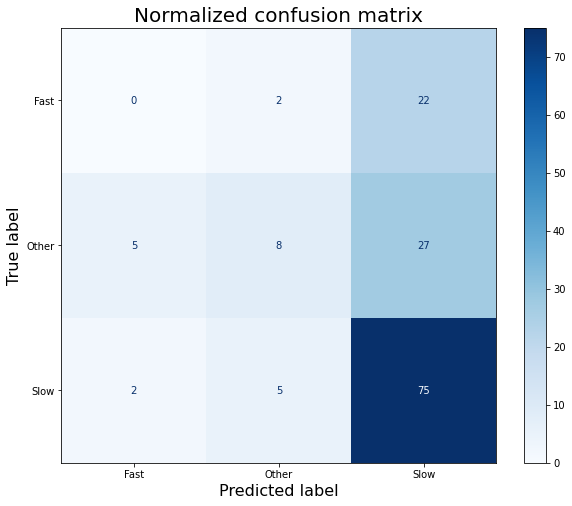

In [57]:
!unzip 5.zip
_, _ = one_loop(x=None, print_results=True)

# 50 percentile

## Data preprocessing

In [58]:
!unzip 1.zip
data_train_raw = pd.read_csv('content/data/data_train_full_new.csv')
data_test_raw = pd.read_csv('content/data/data_test_new.csv')

# y values
y_train_cat = data_train_raw['category'].to_numpy()
y_test_cat = data_test_raw['category'].to_numpy()
le = LabelEncoder()
le.fit(y_train_cat)
y_train = le.transform(y_train_cat)
y_test = le.transform(y_test_cat)

# One-hot encode categorical features
X_train = encode(data_train_raw.drop(columns=['ID', 'slope', 'r2', 'category']))
X_test_raw = encode(data_test_raw.drop(columns=['ID', 'slope', 'r2', 'category']))

# Fix missing values
col_list = list(X_train.columns.values)
X_test = X_test_raw.reindex(columns=col_list).fillna(0)
X_test = X_test[col_list]

data_train_list, data_val_list = [], []
for i in range(5):
    train_raw = pd.read_csv('content/data/data_cv_train_' + str(i+1) + '.csv')
    val_raw = pd.read_csv('content/data/data_cv_val_' + str(i+1) + '.csv')

    y_train_cat = train_raw['category'].to_numpy()
    y_val_cat = val_raw['category'].to_numpy()
    y_train = le.transform(y_train_cat)
    y_val = le.transform(y_val_cat)

    X_train = encode(train_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)
    X_val = encode(val_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)

    X_train = X_train[col_list]
    X_val = X_val[col_list]

    data_train_list.append((X_train, y_train))
    data_val_list.append((X_val, y_val))

Archive:  1.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  


In [ ]:
data_train_raw.groupby(['category']).size()

category
Fast     202
Other    182
Slow     203
dtype: int64

In [ ]:
data_test_raw.groupby(['category']).size()

category
Fast     41
Other    42
Slow     51
dtype: int64

## Hyperparameter tuning

In [ ]:
k_vals = [1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
knn_accuracies = []
knn_std = []

# Peform stratified 5-fold CV
for k in tqdm(k_vals):
    model = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    knn_accuracies.append(np.mean(scores))
    knn_std.append(np.std(scores))
    
# Best value and accuracy
knn_best_index = np.argmax(knn_accuracies)
knn_best_k = k_vals[knn_best_index]
knn_best_accuracy = knn_accuracies[knn_best_index]
knn_best_std = knn_std[knn_best_index]
print('Best k: ', knn_best_k)
print('Best cross-validation accuracy: %0.4f' % (knn_best_accuracy))
print('Standard deviation: %0.4f' % (knn_best_std))

  0%|          | 0/15 [00:00<?, ?it/s]

Best k:  5
Best cross-validation accuracy: 0.4344
Standard deviation: 0.0238


In [ ]:
# Regularisation values
lr_C_vals = np.logspace(-1, 5, num=7)
lr_accuracies = []
lr_std = []

# Peform stratified 5-fold CV
for c in tqdm(lr_C_vals):
    model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=c)
    scores = cv(model, data_train_list, data_val_list)
    lr_accuracies.append(np.mean(scores))
    lr_std.append(np.std(scores))
    
# Best value and accuracy
lr_best_index = np.argmax(lr_accuracies)
lr_best_c = lr_C_vals[lr_best_index]
lr_best_accuracy = lr_accuracies[lr_best_index]
lr_best_std = lr_std[lr_best_index]
print('Best c: ', lr_best_c)
print('Best cross-validation accuracy: %0.4f' % (lr_best_accuracy))
print('Standard deviation: %0.4f' % (lr_best_std))

  0%|          | 0/7 [00:00<?, ?it/s]

Best c:  1.0
Best cross-validation accuracy: 0.4462
Standard deviation: 0.0255


In [ ]:
rf_n_estimators_list= [100, 200, 300, 400, 500]
rf_accuracies = []
rf_std = []

# Peform stratified 5-fold CV
for n in tqdm(rf_n_estimators_list):
    model = RandomForestClassifier(n_estimators=n, criterion='gini', random_state=1, n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    rf_accuracies.append(np.mean(scores))
    rf_std.append(np.std(scores))
    
# Best value and accuracy
rf_best_index = np.argmax(rf_accuracies)
rf_best_n = rf_n_estimators_list[rf_best_index]
rf_best_accuracy = rf_accuracies[rf_best_index]
rf_best_std = rf_std[rf_best_index]
print('Best n_estimators: ', rf_best_n)
print('Best cross-validation accuracy: %0.4f' % (rf_best_accuracy))
print('Standard deviation: %0.4f' % (rf_best_std))

  0%|          | 0/5 [00:00<?, ?it/s]

Best n_estimators:  400
Best cross-validation accuracy: 0.4599
Standard deviation: 0.0325


In [ ]:
svc_C_vals = np.logspace(-1, 3, num=5)
svc_degree_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
    
params = []
best_score = 0.0
best_score_std = 0.0
for i in svc_C_vals:
    for j in svc_degree_vals:
        params.append((i, j))
for i in tnrange(len(params)):
    model = SVC(C=params[i][0], kernel='poly', degree=params[i][1], random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/60 [00:00<?, ?it/s]

Best params:  (1000.0, 20)
Best cross-validation accuracy: 0.4481
Standard deviation: 0.0443


In [ ]:
svc_C_vals = np.logspace(-1, 5, num=7)
svc_accuracies = []
svc_std = []

# Peform stratified 5-fold CV
for c in tqdm(svc_C_vals):
    model = SVC(C=c, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    svc_accuracies.append(np.mean(scores))
    svc_std.append(np.std(scores))
    
# Best value and accuracy
svc_best_index = np.argmax(svc_accuracies)
svc_best_c = svc_C_vals[svc_best_index]
svc_best_accuracy = svc_accuracies[svc_best_index]
svc_best_std = svc_std[svc_best_index]
print('Best C: ', svc_best_c)
print('Best cross-validation accuracy: %0.4f' % (svc_best_accuracy))
print('Standard deviation: %0.4f' % (svc_best_std))

  0%|          | 0/7 [00:00<?, ?it/s]

Best C:  100000.0
Best cross-validation accuracy: 0.4361
Standard deviation: 0.0347


In [ ]:
eta = [0.1, 0.3, 0.5]
max_depth = [1, 2, 3, 5, 10]
min_child_weight = [0.5, 1, 2, 3, 5]

params = []
best_score = 0.0
best_score_std = 0.0
for i in eta:
    for j in max_depth:
        for k in min_child_weight:
            params.append((i, j, k))
for i in tnrange(len(params)):
    model = XGBClassifier(eta=params[i][0], max_depth=params[i][1], min_child_weight=params[i][2], random_state=1, use_label_encoder=False, n_jobs=-1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1], params[i][2])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/75 [00:00<?, ?it/s]

Best params:  (0.1, 5, 1)
Best cross-validation accuracy: 0.4549
Standard deviation: 0.0331


In [ ]:
adbst_n_estimators_list= [50, 100, 200, 300]
adbst_accuracies = []
adbst_std = []

# Peform stratified 5-fold CV
for n in tqdm(adbst_n_estimators_list):
    model = AdaBoostClassifier(n_estimators=n, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    adbst_accuracies.append(np.mean(scores))
    adbst_std.append(np.std(scores))
    
# Best value and accuracy
adbst_best_index = np.argmax(adbst_accuracies)
adbst_best_n = adbst_n_estimators_list[adbst_best_index]
adbst_best_accuracy = adbst_accuracies[adbst_best_index]
adbst_best_std = adbst_std[adbst_best_index]
print('Best n_estimators: ', adbst_best_n)
print('Best cross-validation accuracy: %0.4f' % (adbst_best_accuracy))
print('Standard deviation: %0.4f' % (adbst_best_std))

  0%|          | 0/3 [00:00<?, ?it/s]

Best n_estimators:  50
Best cross-validation accuracy: 0.4173
Standard deviation: 0.0198


In [ ]:
hidden_layer_sizes = [(100,), (200,), (500,), (1000)]
learning_rate_init = [0.1, 0.05, 0.01, 0.005, 0.001]

params = []
best_score = 0.0
best_score_std = 0.0
for i in hidden_layer_sizes:
    for j in learning_rate_init:
        params.append((i, j))
for i in tnrange(len(params)):
    model = MLPClassifier(hidden_layer_sizes=params[i][0], learning_rate_init=params[i][1], max_iter=1000, random_state=1)
    scores = cv(model, data_train_list, data_val_list)
    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_score_std = np.std(scores)
        best_params = (params[i][0], params[i][1])

print('Best params: ', best_params)
print('Best cross-validation accuracy: %0.4f' % (best_score))
print('Standard deviation: %0.4f' % (best_score_std))

  0%|          | 0/20 [00:00<?, ?it/s]

Best params:  (1000, 0.005)
Best cross-validation accuracy: 0.4463
Standard deviation: 0.0314


## Testing

In [ ]:
class_dict = {0: 'Fast',
              1: 'Other',
              2: 'Slow'}
class_names = list(le.inverse_transform([0, 1, 2]))
print(class_names)

['Fast', 'Other', 'Slow']

0.3880597014925373


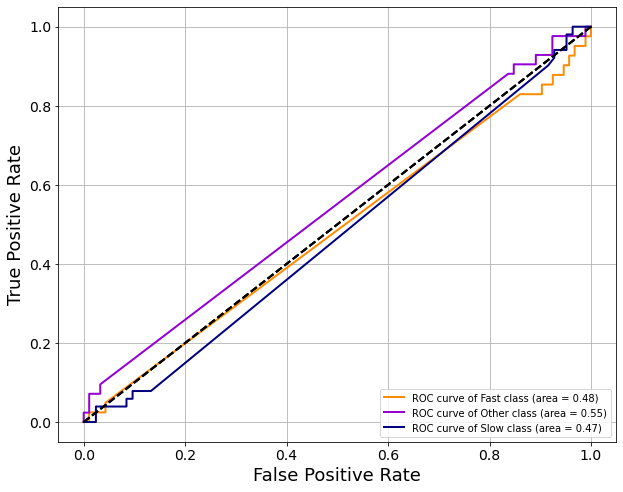

              precision    recall  f1-score   support

           0       0.33      0.05      0.09        41
           1       0.57      0.10      0.16        42
           2       0.38      0.90      0.53        51

    accuracy                           0.39       134
   macro avg       0.43      0.35      0.26       134
weighted avg       0.43      0.39      0.28       134

Normalized confusion matrix:
[[ 2  1 38]
 [ 1  4 37]
 [ 3  2 46]]


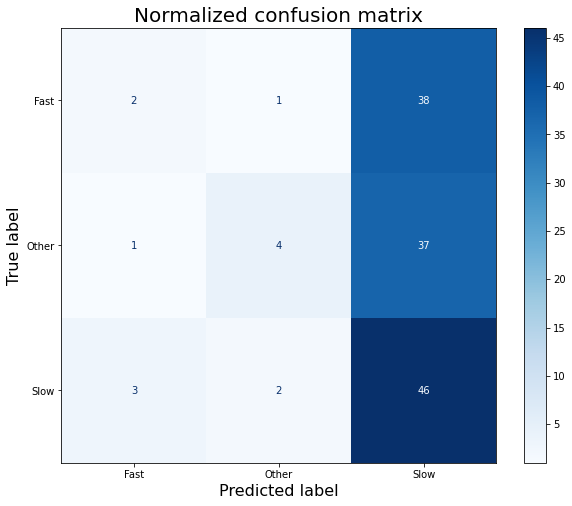

In [59]:
# Gaussian Process
model = GaussianProcessClassifier(random_state=1, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.3656716417910448


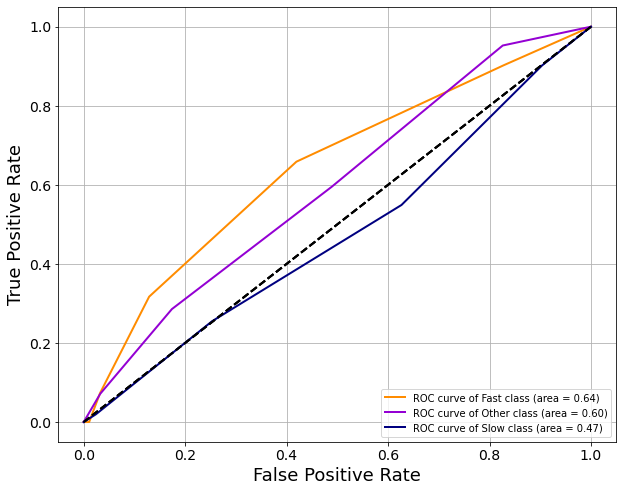

              precision    recall  f1-score   support

           0       0.38      0.49      0.43        41
           1       0.34      0.38      0.36        42
           2       0.38      0.25      0.31        51

    accuracy                           0.37       134
   macro avg       0.37      0.37      0.36       134
weighted avg       0.37      0.37      0.36       134

Normalized confusion matrix:
[[20 12  9]
 [14 16 12]
 [19 19 13]]


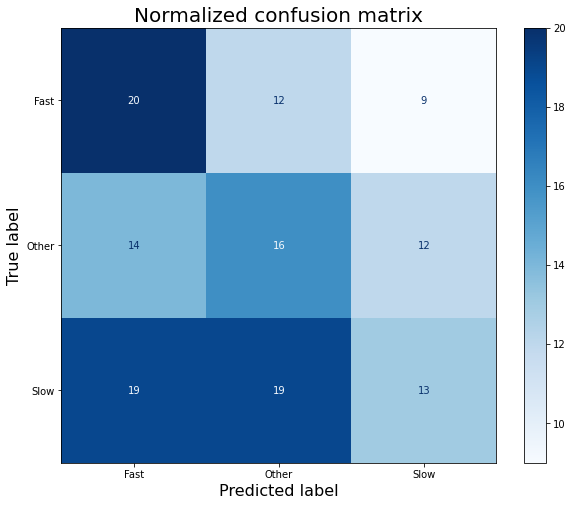

In [60]:
# KNN
model = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.47761194029850745


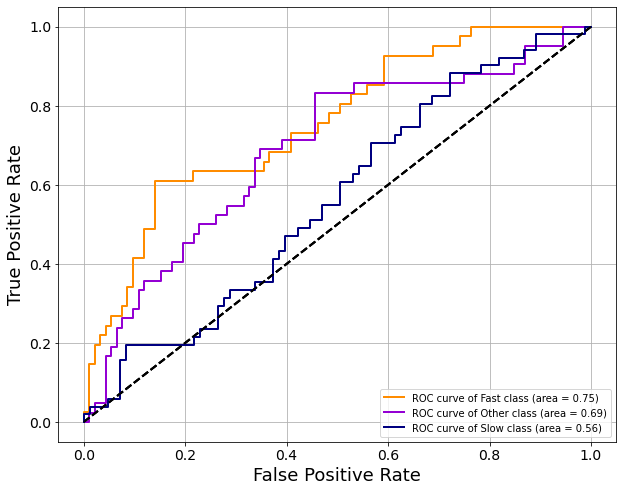

              precision    recall  f1-score   support

           0       0.50      0.63      0.56        41
           1       0.47      0.45      0.46        42
           2       0.45      0.37      0.41        51

    accuracy                           0.48       134
   macro avg       0.48      0.49      0.48       134
weighted avg       0.47      0.48      0.47       134

Normalized confusion matrix:
[[26  5 10]
 [10 19 13]
 [16 16 19]]


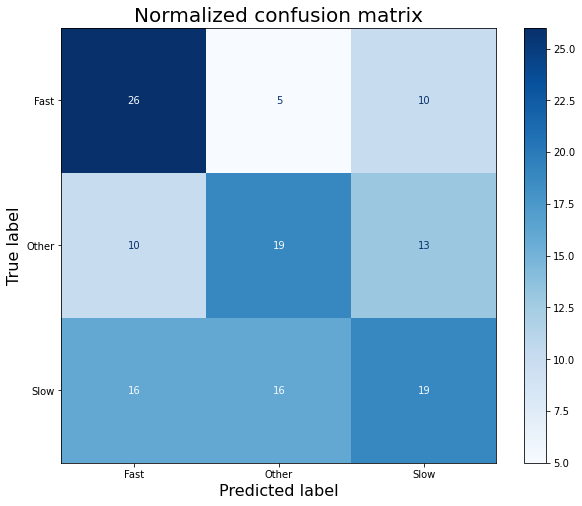

In [61]:
# Logistic Regression
model = LogisticRegression(multi_class='multinomial', max_iter=10000, C=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.5


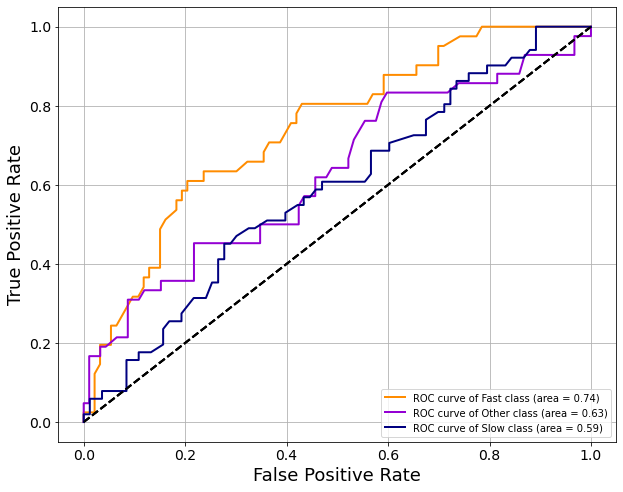

              precision    recall  f1-score   support

           0       0.56      0.54      0.55        41
           1       0.51      0.43      0.47        42
           2       0.45      0.53      0.49        51

    accuracy                           0.50       134
   macro avg       0.51      0.50      0.50       134
weighted avg       0.51      0.50      0.50       134

Normalized confusion matrix:
[[22  4 15]
 [ 6 18 18]
 [11 13 27]]


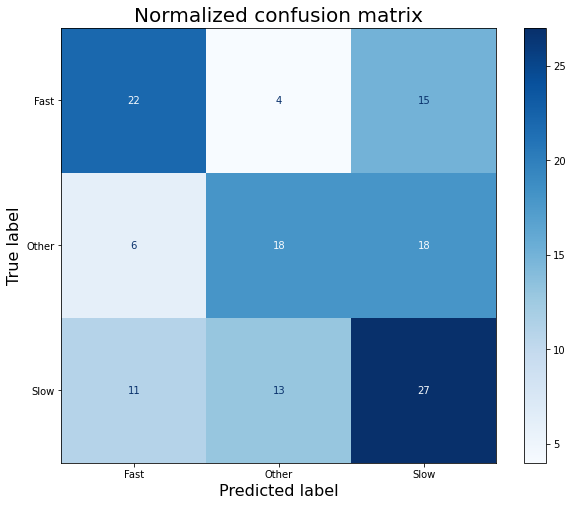

In [62]:
# Random Forest
model = RandomForestClassifier(n_estimators=400, criterion='gini', random_state=1, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.44029850746268656
              precision    recall  f1-score   support

           0       0.45      0.41      0.43        41
           1       0.44      0.26      0.33        42
           2       0.44      0.61      0.51        51

    accuracy                           0.44       134
   macro avg       0.44      0.43      0.42       134
weighted avg       0.44      0.44      0.43       134

Normalized confusion matrix:
[[17  5 19]
 [10 11 21]
 [11  9 31]]


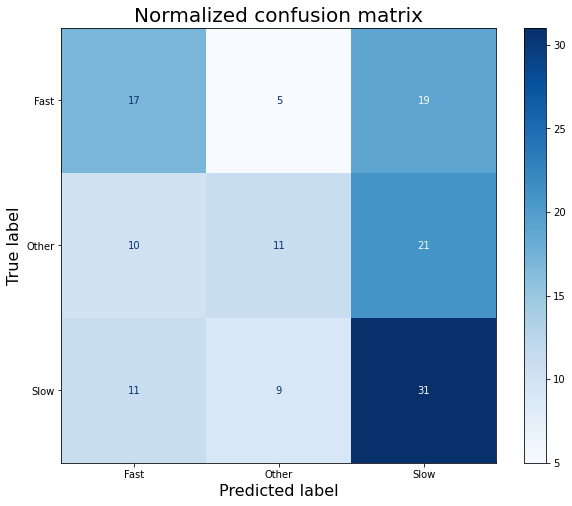

In [63]:
# SVC
model = SVC(C=1000, kernel='poly', degree=20, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.39552238805970147
              precision    recall  f1-score   support

           0       0.42      0.49      0.45        41
           1       0.41      0.31      0.35        42
           2       0.37      0.39      0.38        51

    accuracy                           0.40       134
   macro avg       0.40      0.40      0.39       134
weighted avg       0.40      0.40      0.39       134

Normalized confusion matrix:
[[20  4 17]
 [12 13 17]
 [16 15 20]]


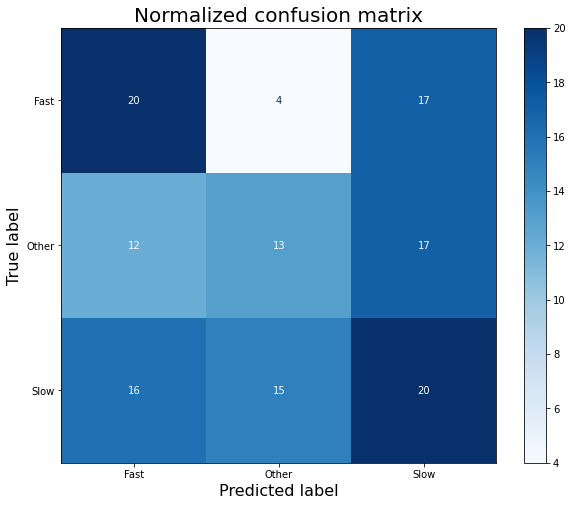

In [64]:
# SVC
model = SVC(C=100000, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.4626865671641791


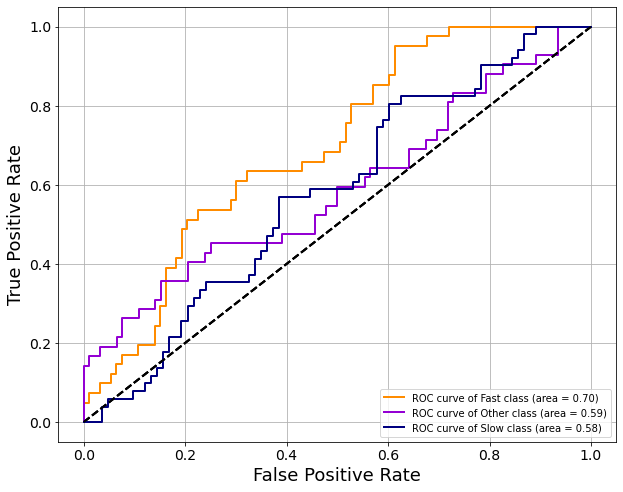

              precision    recall  f1-score   support

           0       0.46      0.46      0.46        41
           1       0.44      0.40      0.42        42
           2       0.48      0.51      0.50        51

    accuracy                           0.46       134
   macro avg       0.46      0.46      0.46       134
weighted avg       0.46      0.46      0.46       134

Normalized confusion matrix:
[[19  9 13]
 [10 17 15]
 [12 13 26]]


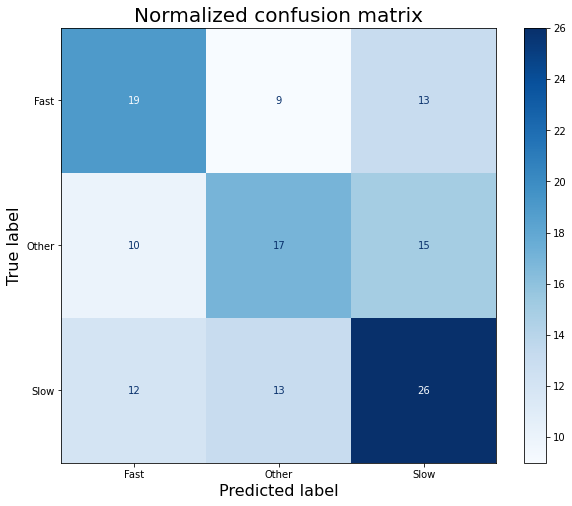

In [65]:
# XGBoost
model = XGBClassifier(max_depth=5, eta=0.1, min_child_weight=1, random_state=1, use_label_encoder=False, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.44029850746268656


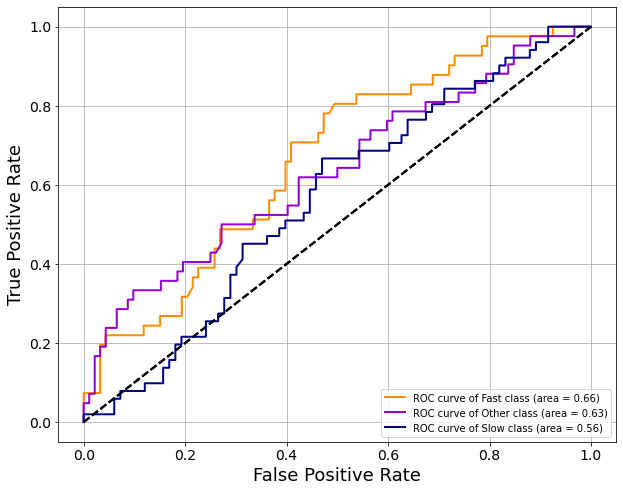

              precision    recall  f1-score   support

           0       0.44      0.56      0.49        41
           1       0.36      0.24      0.29        42
           2       0.48      0.51      0.50        51

    accuracy                           0.44       134
   macro avg       0.43      0.44      0.43       134
weighted avg       0.43      0.44      0.43       134

Normalized confusion matrix:
[[23 10  8]
 [12 10 20]
 [17  8 26]]


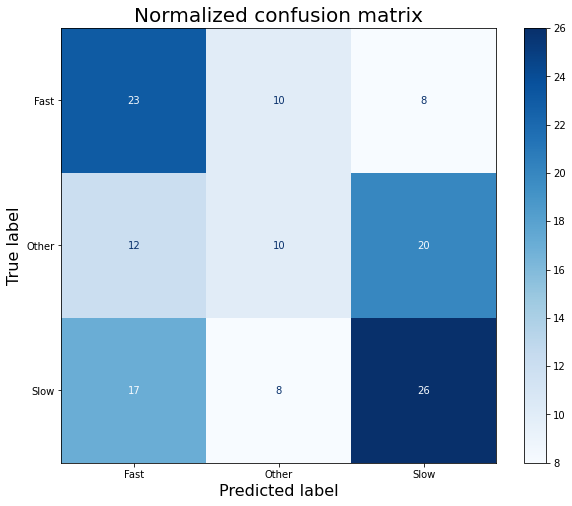

In [66]:
# Adaboost
model = AdaBoostClassifier(n_estimators=50, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

0.3880597014925373


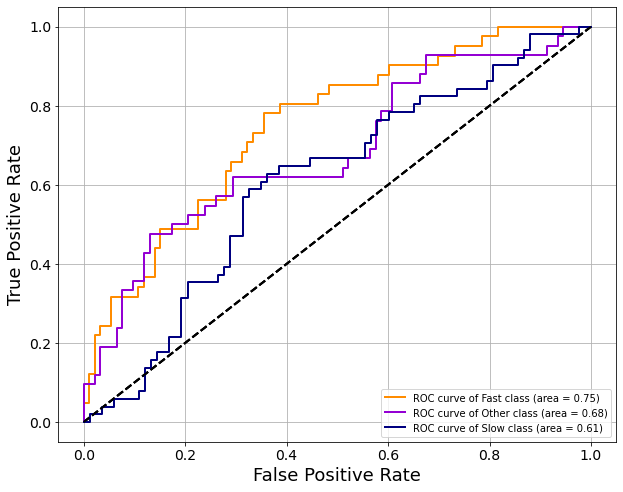

              precision    recall  f1-score   support

           0       0.36      0.98      0.53        41
           1       0.67      0.14      0.24        42
           2       0.40      0.12      0.18        51

    accuracy                           0.39       134
   macro avg       0.48      0.41      0.32       134
weighted avg       0.47      0.39      0.31       134

Normalized confusion matrix:
[[40  0  1]
 [28  6  8]
 [42  3  6]]


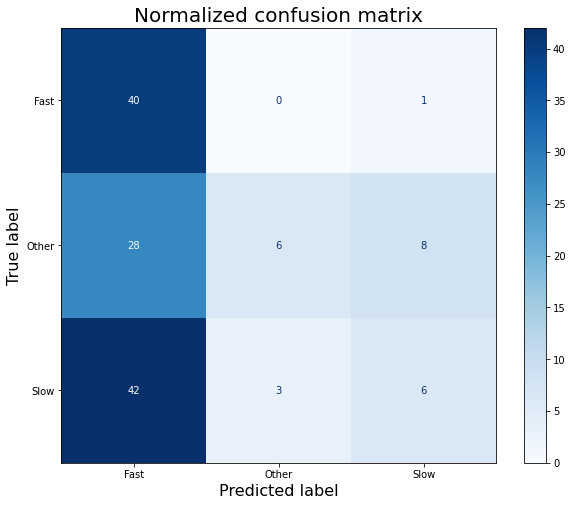

In [67]:
# Neural Network
model = MLPClassifier(hidden_layer_sizes=(1000,), learning_rate_init=0.005, random_state=1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test)
print(acc)
model_pred_probs = model.predict_proba(X_test)
produce_roc(model_pred_probs)
model.fit(X_train, y_train)
print(classification_report(y_test, y_pred))
fig, axs = plt.subplots(figsize=(10, 8))
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=axs)
axs.set_title('Normalized confusion matrix', fontsize=20)
axs.set_xlabel('Predicted label', fontsize=16)
axs.set_ylabel('True label', fontsize=16)
print('Normalized confusion matrix:')
print(disp.confusion_matrix)
plt.show()

## Additional runs

Archive:  2.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.20      0.02      0.04        47
           1       0.14      0.02      0.04        45
           2       0.31      0.86      0.45        44

    accuracy                           0.29       136
   macro avg       0.22      0.30      0.18       136
weighted a

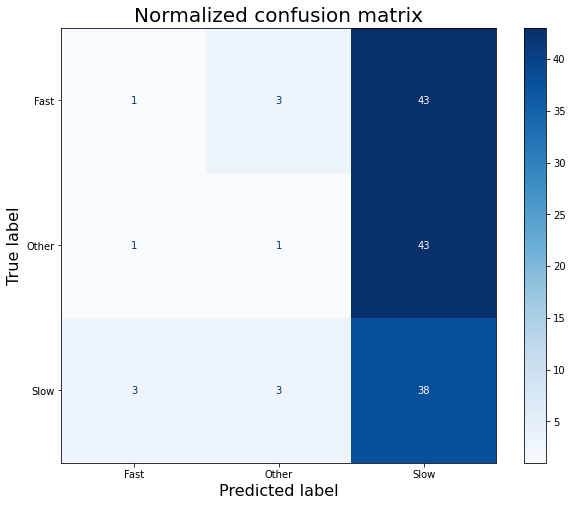

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.52      0.47      0.49        47
           1       0.43      0.44      0.44        45
           2       0.33      0.36      0.35        44

    accuracy                           0.43       136
   macro avg       0.43      0.43      0.43       136
weighted avg       0.43      0.43      0.43       136

Normalized confusion matrix:
[[22  9 16]
 [ 9 20 16]
 [11 17 16]]


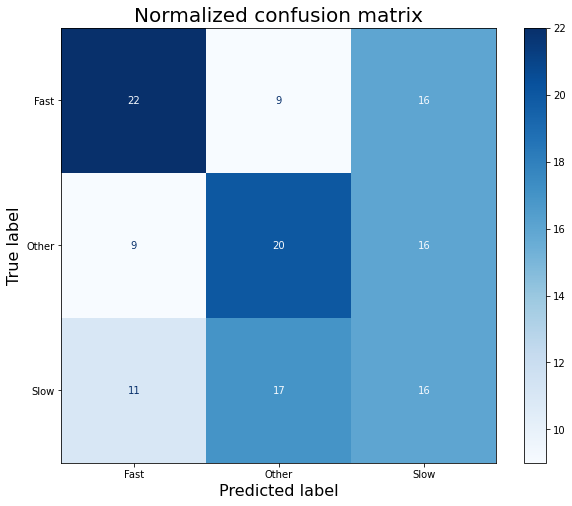

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.49      0.51      0.50        47
           1       0.45      0.40      0.42        45
           2       0.30      0.32      0.31        44

    accuracy                           0.41       136
   macro avg       0.41      0.41      0.41       136
weighted avg       0.41      0.41      0.41       136

Normalized confusion matrix:
[[24  6 17]
 [11 18 16]
 [14 16 14]]


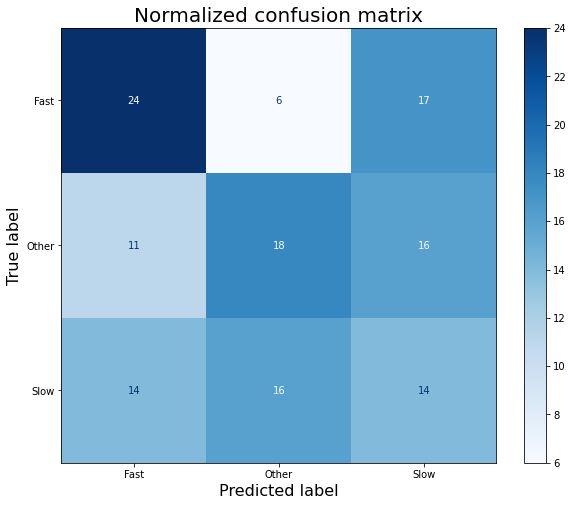

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.59      0.55      0.57        47
           1       0.47      0.38      0.42        45
           2       0.36      0.45      0.40        44

    accuracy                           0.46       136
   macro avg       0.47      0.46      0.46       136
weighted avg       0.48      0.46      0.47       136

Normalized confusion matrix:
[[26  5 16]
 [ 8 17 20]
 [10 14 20]]


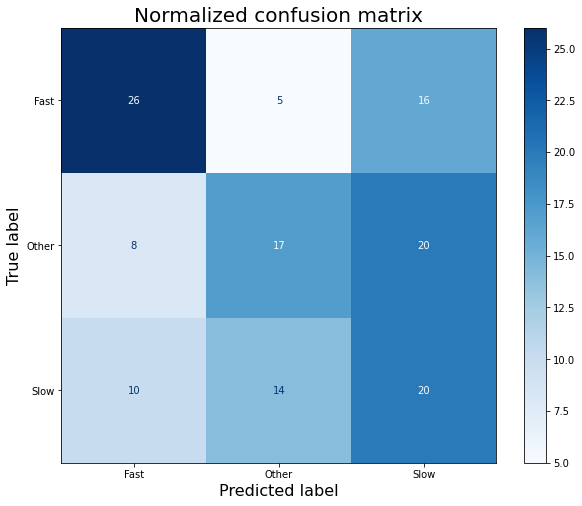

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.64      0.62        47
           1       0.52      0.33      0.41        45
           2       0.37      0.48      0.42        44

    accuracy                           0.49       136
   macro avg       0.50      0.48      0.48       136
weighted avg       0.50      0.49      0.48       136

Normalized confusion matrix:
[[30  3 14]
 [ 8 15 22]
 [12 11 21]]


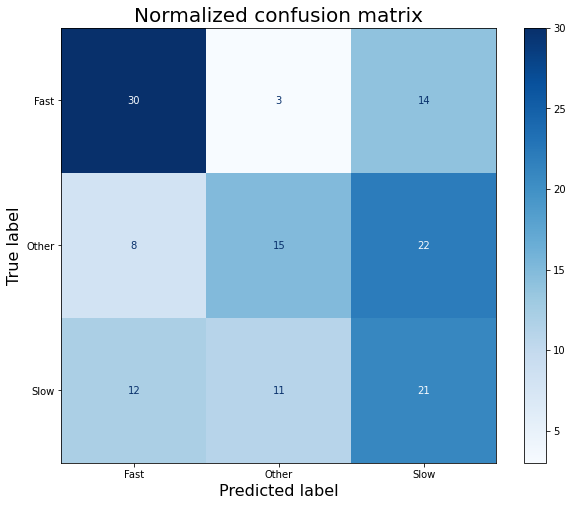

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.64      0.62        47
           1       0.52      0.33      0.41        45
           2       0.37      0.48      0.42        44

    accuracy                           0.49       136
   macro avg       0.50      0.48      0.48       136
weighted avg       0.50      0.49      0.48       136

Normalized confusion matrix:
[[30  3 14]
 [ 8 15 22]
 [12 11 21]]


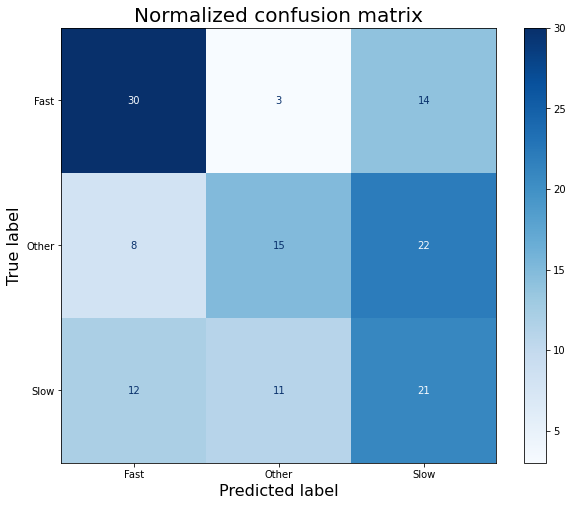

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.56      0.51      0.53        47
           1       0.47      0.38      0.42        45
           2       0.32      0.41      0.36        44

    accuracy                           0.43       136
   macro avg       0.45      0.43      0.44       136
weighted avg       0.45      0.43      0.44       136

Normalized confusion matrix:
[[24  3 20]
 [ 9 17 19]
 [10 16 18]]


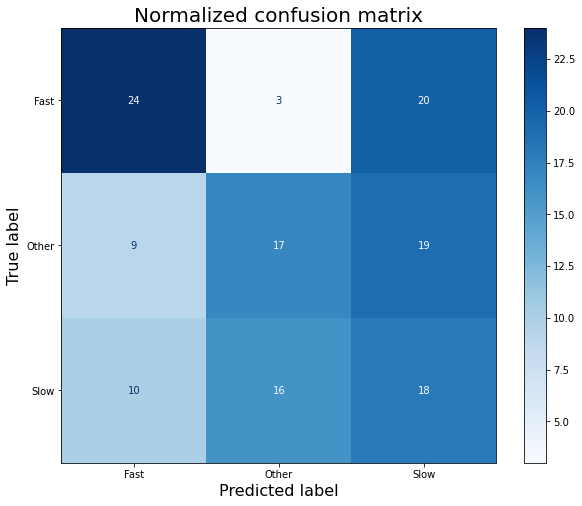

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.54      0.40      0.46        47
           1       0.39      0.33      0.36        45
           2       0.35      0.50      0.41        44

    accuracy                           0.41       136
   macro avg       0.43      0.41      0.41       136
weighted avg       0.43      0.41      0.41       136

Normalized confusion matrix:
[[19  9 19]
 [ 8 15 22]
 [ 8 14 22]]


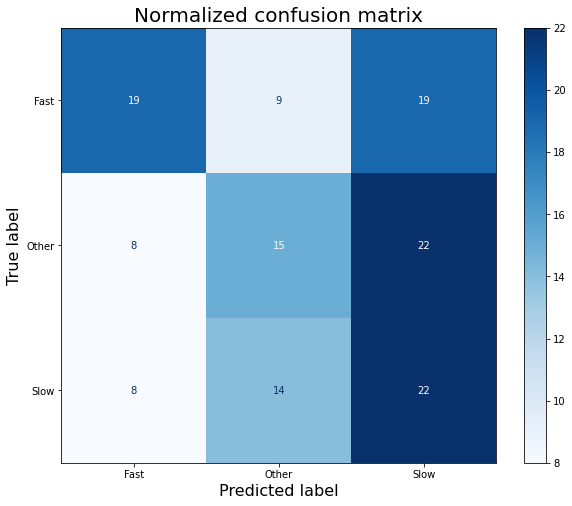

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.51      0.49      0.50        47
           1       0.41      0.47      0.44        45
           2       0.30      0.27      0.29        44

    accuracy                           0.41       136
   macro avg       0.41      0.41      0.41       136
weighted avg       0.41      0.41      0.41       136

Normalized confusion matrix:
[[23  9 15]
 [11 21 13]
 [11 21 12]]


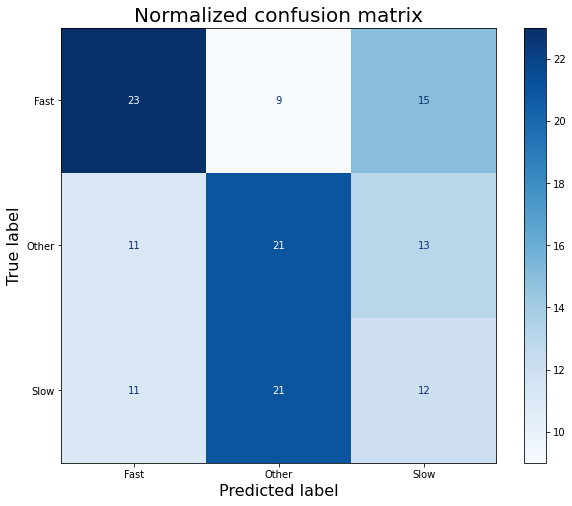

In [68]:
!unzip 2.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  3.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.25      0.02      0.04        53
           1       0.44      0.16      0.24        43
           2       0.34      0.86      0.49        50

    accuracy                           0.35       146
   macro avg       0.34      0.35      0.25       146
weighted a

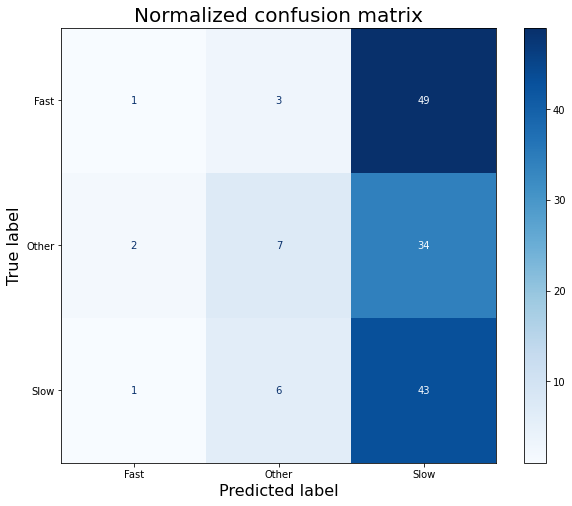

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.49      0.64      0.56        53
           1       0.39      0.56      0.46        43
           2       0.33      0.10      0.15        50

    accuracy                           0.43       146
   macro avg       0.40      0.43      0.39       146
weighted avg       0.41      0.43      0.39       146

Normalized confusion matrix:
[[34 15  4]
 [13 24  6]
 [22 23  5]]


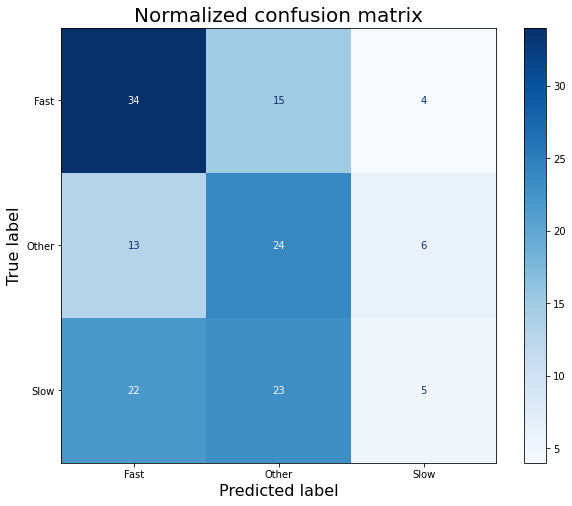

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        53
           1       0.42      0.35      0.38        43
           2       0.36      0.38      0.37        50

    accuracy                           0.45       146
   macro avg       0.45      0.44      0.44       146
weighted avg       0.45      0.45      0.45       146

Normalized confusion matrix:
[[32  5 16]
 [10 15 18]
 [15 16 19]]


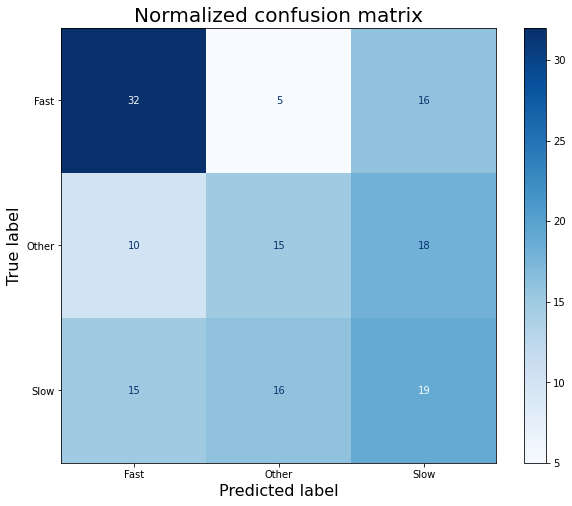

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.58      0.57      0.57        53
           1       0.40      0.40      0.40        43
           2       0.41      0.42      0.42        50

    accuracy                           0.47       146
   macro avg       0.46      0.46      0.46       146
weighted avg       0.47      0.47      0.47       146

Normalized confusion matrix:
[[30  7 16]
 [12 17 14]
 [10 19 21]]


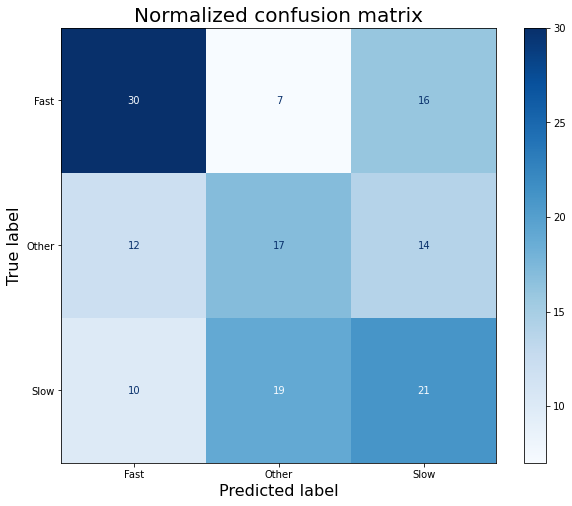

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.52      0.60      0.56        53
           1       0.39      0.28      0.32        43
           2       0.38      0.40      0.39        50

    accuracy                           0.44       146
   macro avg       0.43      0.43      0.42       146
weighted avg       0.43      0.44      0.43       146

Normalized confusion matrix:
[[32  8 13]
 [11 12 20]
 [19 11 20]]


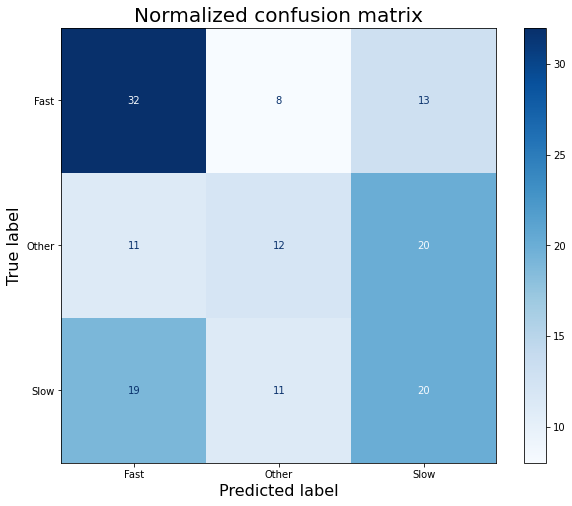

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.52      0.62      0.56        53
           1       0.54      0.33      0.41        43
           2       0.39      0.44      0.42        50

    accuracy                           0.47       146
   macro avg       0.48      0.46      0.46       146
weighted avg       0.48      0.47      0.47       146

Normalized confusion matrix:
[[33  4 16]
 [11 14 18]
 [20  8 22]]


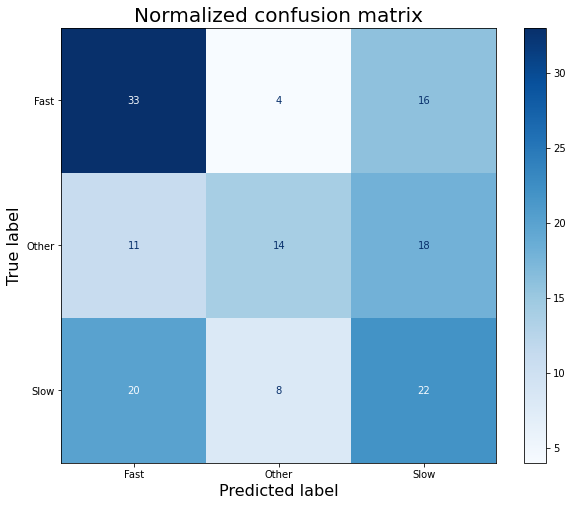

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.51      0.45      0.48        53
           1       0.38      0.44      0.41        43
           2       0.37      0.36      0.36        50

    accuracy                           0.42       146
   macro avg       0.42      0.42      0.42       146
weighted avg       0.42      0.42      0.42       146

Normalized confusion matrix:
[[24 14 15]
 [ 8 19 16]
 [15 17 18]]


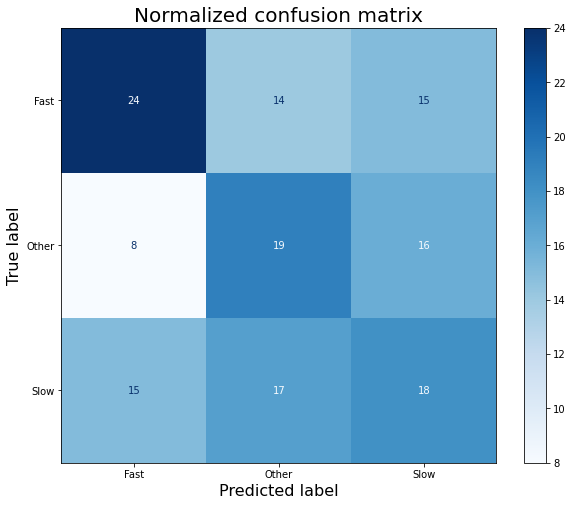

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.46      0.47      0.47        53
           1       0.40      0.40      0.40        43
           2       0.39      0.38      0.38        50

    accuracy                           0.42       146
   macro avg       0.42      0.42      0.42       146
weighted avg       0.42      0.42      0.42       146

Normalized confusion matrix:
[[25 13 15]
 [11 17 15]
 [18 13 19]]


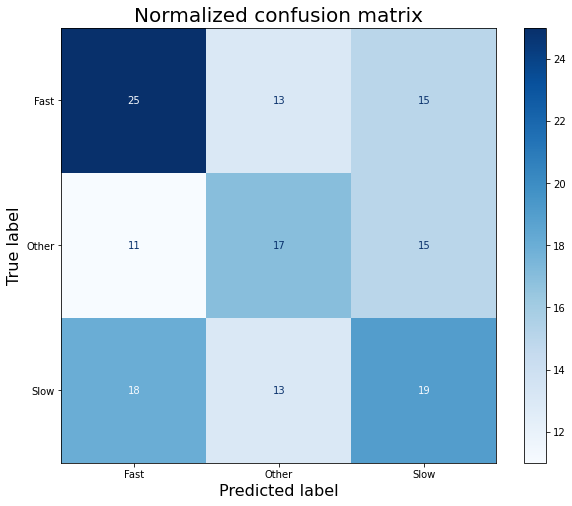

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.19      0.29        53
           1       0.52      0.30      0.38        43
           2       0.35      0.74      0.47        50

    accuracy                           0.41       146
   macro avg       0.51      0.41      0.38       146
weighted avg       0.51      0.41      0.38       146

Normalized confusion matrix:
[[10  2 41]
 [ 2 13 28]
 [ 3 10 37]]


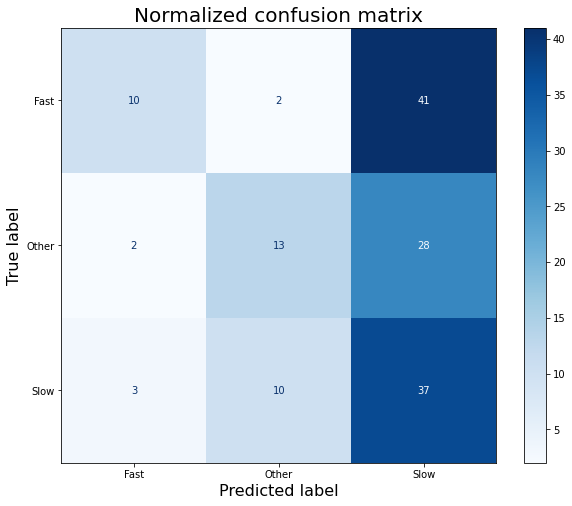

In [69]:
!unzip 3.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  4.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.20      0.04      0.07        45
           1       0.22      0.05      0.08        42
           2       0.35      0.84      0.49        49

    accuracy                           0.33       136
   macro avg       0.26      0.31      0.22       136
weighted a

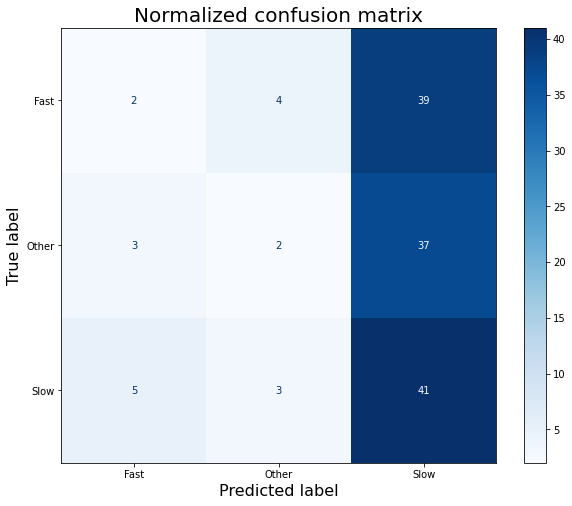

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.42      0.47      0.44        45
           1       0.28      0.12      0.17        42
           2       0.32      0.45      0.38        49

    accuracy                           0.35       136
   macro avg       0.34      0.34      0.33       136
weighted avg       0.34      0.35      0.33       136

Normalized confusion matrix:
[[21  4 20]
 [11  5 26]
 [18  9 22]]


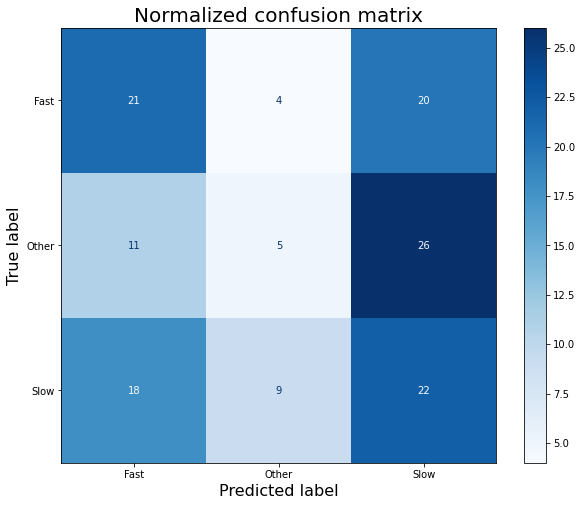

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.44      0.58      0.50        45
           1       0.42      0.38      0.40        42
           2       0.44      0.35      0.39        49

    accuracy                           0.43       136
   macro avg       0.43      0.44      0.43       136
weighted avg       0.43      0.43      0.43       136

Normalized confusion matrix:
[[26  7 12]
 [16 16 10]
 [17 15 17]]


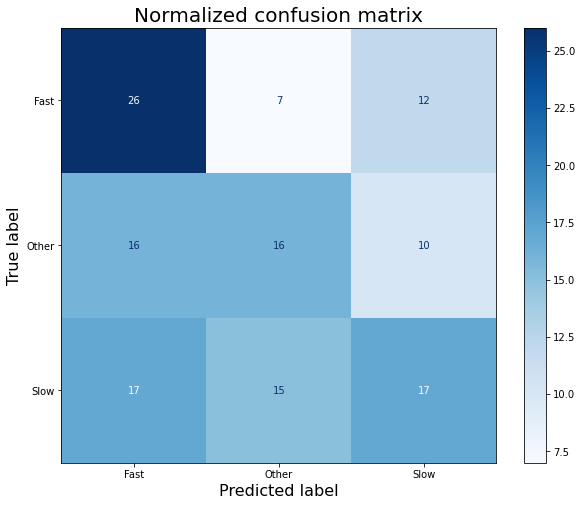

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.45      0.47      0.46        45
           1       0.45      0.40      0.43        42
           2       0.39      0.41      0.40        49

    accuracy                           0.43       136
   macro avg       0.43      0.43      0.43       136
weighted avg       0.43      0.43      0.43       136

Normalized confusion matrix:
[[21  8 16]
 [10 17 15]
 [16 13 20]]


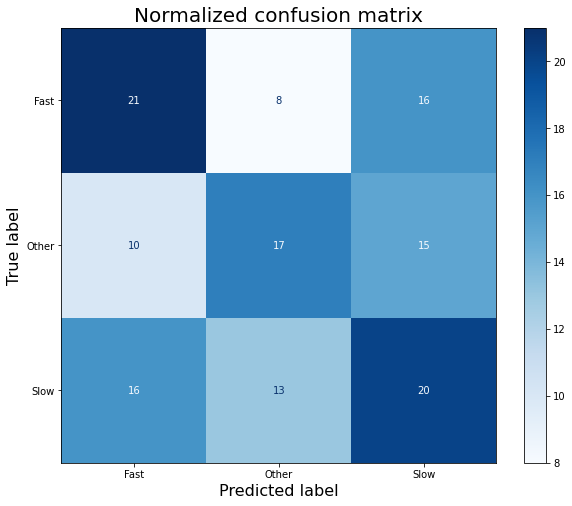

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.39      0.53      0.45        45
           1       0.37      0.24      0.29        42
           2       0.38      0.37      0.37        49

    accuracy                           0.38       136
   macro avg       0.38      0.38      0.37       136
weighted avg       0.38      0.38      0.37       136

Normalized confusion matrix:
[[24  7 14]
 [16 10 16]
 [21 10 18]]


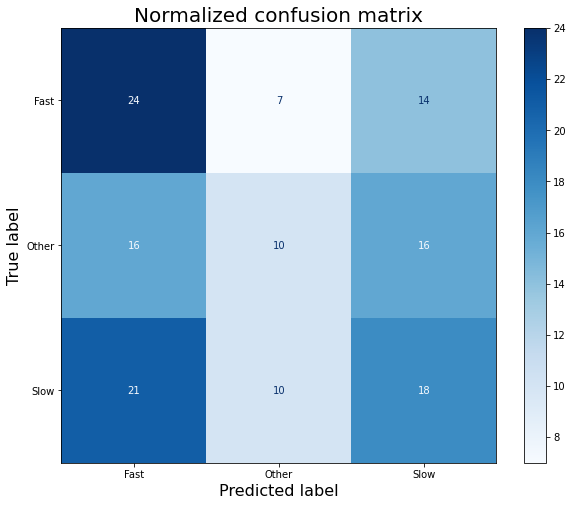

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.39      0.53      0.45        45
           1       0.37      0.24      0.29        42
           2       0.38      0.37      0.37        49

    accuracy                           0.38       136
   macro avg       0.38      0.38      0.37       136
weighted avg       0.38      0.38      0.37       136

Normalized confusion matrix:
[[24  7 14]
 [16 10 16]
 [21 10 18]]


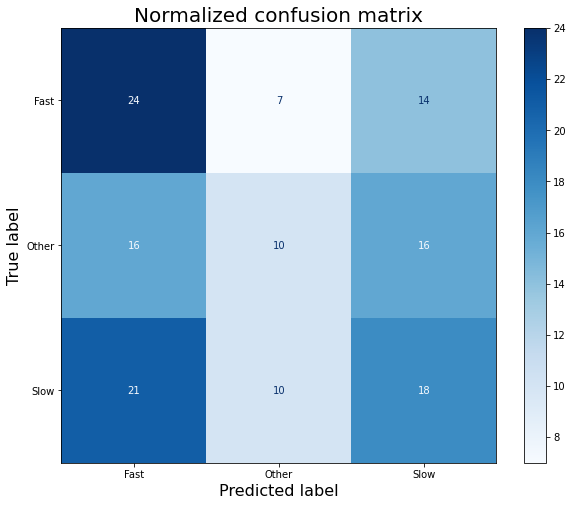

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.43      0.51      0.46        45
           1       0.48      0.38      0.43        42
           2       0.35      0.35      0.35        49

    accuracy                           0.41       136
   macro avg       0.42      0.41      0.41       136
weighted avg       0.42      0.41      0.41       136

Normalized confusion matrix:
[[23  4 18]
 [12 16 14]
 [19 13 17]]


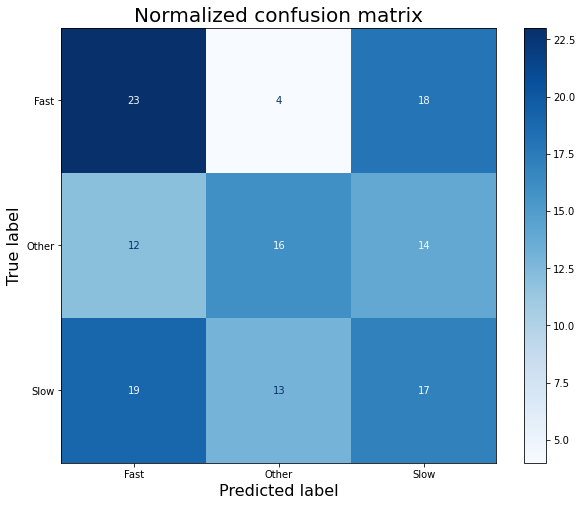

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.43      0.44      0.44        45
           1       0.21      0.17      0.19        42
           2       0.42      0.49      0.45        49

    accuracy                           0.38       136
   macro avg       0.36      0.37      0.36       136
weighted avg       0.36      0.38      0.37       136

Normalized confusion matrix:
[[20 10 15]
 [17  7 18]
 [ 9 16 24]]


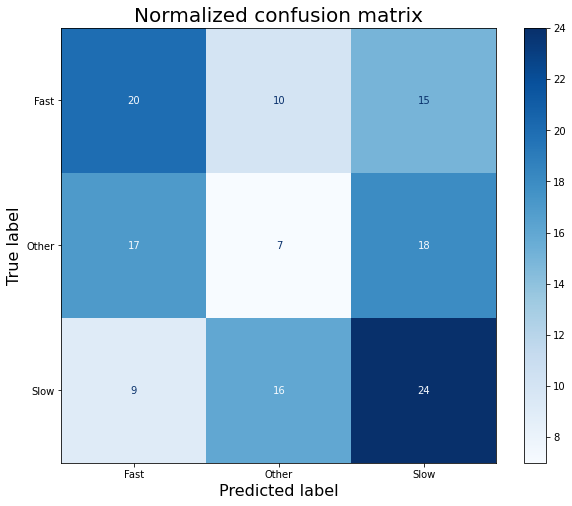

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.36      0.51      0.42        45
           1       0.43      0.45      0.44        42
           2       0.39      0.22      0.29        49

    accuracy                           0.39       136
   macro avg       0.39      0.40      0.38       136
weighted avg       0.39      0.39      0.38       136

Normalized confusion matrix:
[[23 11 11]
 [17 19  6]
 [24 14 11]]


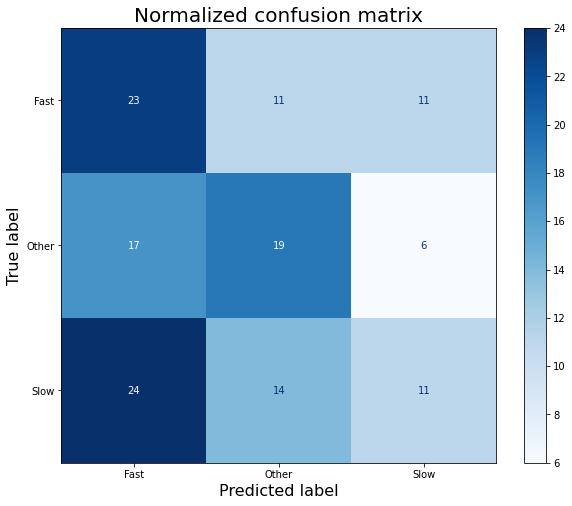

In [70]:
!unzip 4.zip
_, _ = one_loop(x=None, print_results=True)

Archive:  5.zip
replace content/data/data_cv_val_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/data/data_cv_val_2.csv  
  inflating: content/data/data_test_new.csv  
  inflating: content/data/data_cv_train_5.csv  
  inflating: content/data/data_cv_val_3.csv  
  inflating: content/data/data_train_full_new.csv  
  inflating: content/data/data_cv_train_3.csv  
  inflating: content/data/data_cv_train_1.csv  
  inflating: content/data/data_cv_val_5.csv  
  inflating: content/data/data_cv_val_1.csv  
  inflating: content/data/data_cv_train_4.csv  
  inflating: content/data/data_cv_val_4.csv  
  inflating: content/data/data_cv_train_2.csv  
              precision    recall  f1-score   support

           0       0.38      0.06      0.11        48
           1       0.36      0.10      0.16        40
           2       0.38      0.83      0.52        58

    accuracy                           0.38       146
   macro avg       0.37      0.33      0.26       146
weighted a

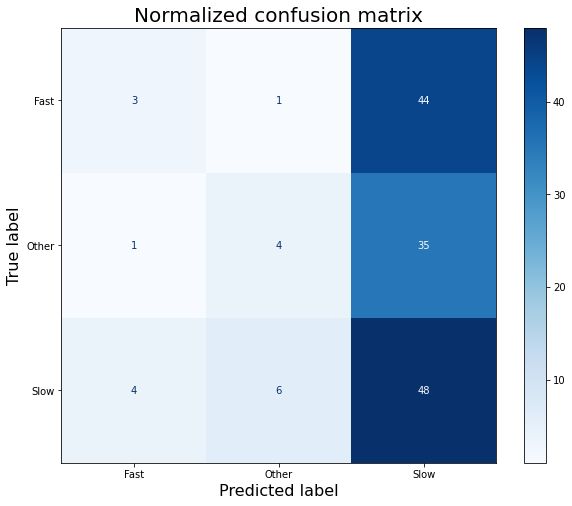

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.47      0.38      0.42        48
           1       0.37      0.42      0.40        40
           2       0.44      0.47      0.45        58

    accuracy                           0.42       146
   macro avg       0.43      0.42      0.42       146
weighted avg       0.43      0.42      0.42       146

Normalized confusion matrix:
[[18 14 16]
 [ 4 17 19]
 [16 15 27]]


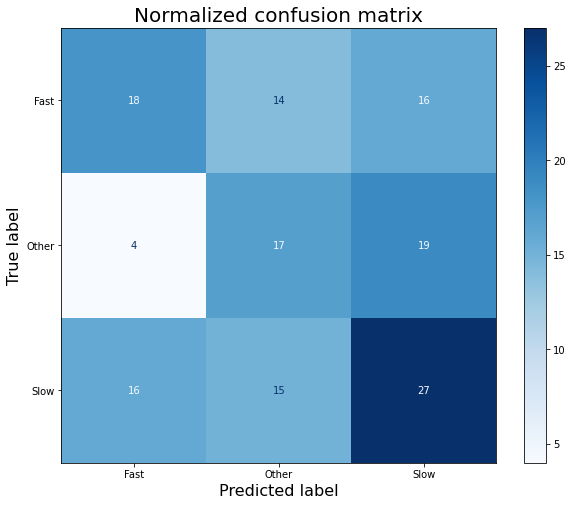

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.45      0.46      0.45        48
           1       0.44      0.55      0.49        40
           2       0.43      0.34      0.38        58

    accuracy                           0.44       146
   macro avg       0.44      0.45      0.44       146
weighted avg       0.44      0.44      0.43       146

Normalized confusion matrix:
[[22  9 17]
 [ 8 22 10]
 [19 19 20]]


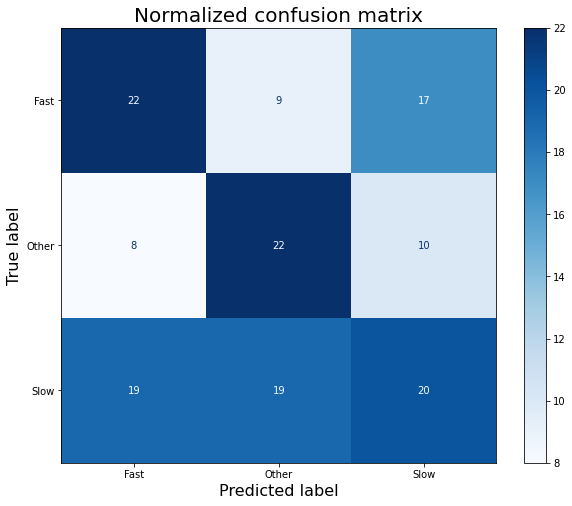

  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.50      0.46      0.48        48
           1       0.37      0.38      0.37        40
           2       0.41      0.43      0.42        58

    accuracy                           0.42       146
   macro avg       0.43      0.42      0.42       146
weighted avg       0.43      0.42      0.43       146

Normalized confusion matrix:
[[22  9 17]
 [ 6 15 19]
 [16 17 25]]


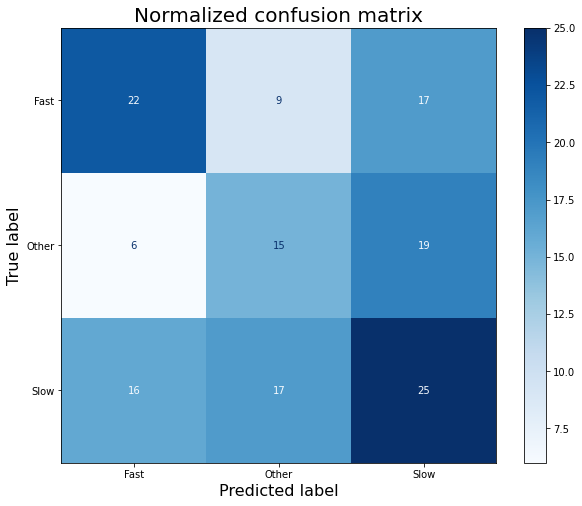

  0%|          | 0/60 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.41      0.52      0.46        48
           1       0.44      0.42      0.43        40
           2       0.41      0.33      0.37        58

    accuracy                           0.42       146
   macro avg       0.42      0.42      0.42       146
weighted avg       0.42      0.42      0.41       146

Normalized confusion matrix:
[[25  9 14]
 [10 17 13]
 [26 13 19]]


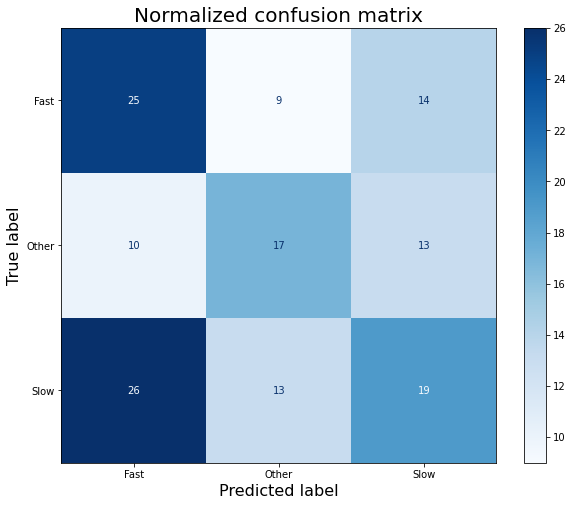

  0%|          | 0/7 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.41      0.52      0.46        48
           1       0.44      0.42      0.43        40
           2       0.41      0.33      0.37        58

    accuracy                           0.42       146
   macro avg       0.42      0.42      0.42       146
weighted avg       0.42      0.42      0.41       146

Normalized confusion matrix:
[[25  9 14]
 [10 17 13]
 [26 13 19]]


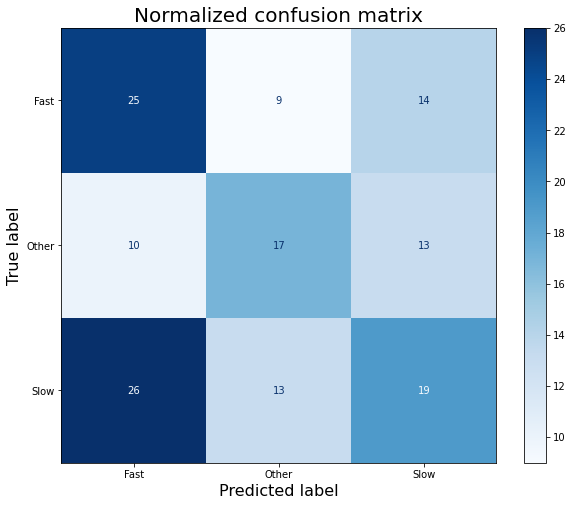

  0%|          | 0/75 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.61      0.52      0.56        48
           1       0.37      0.50      0.43        40
           2       0.45      0.40      0.42        58

    accuracy                           0.47       146
   macro avg       0.48      0.47      0.47       146
weighted avg       0.48      0.47      0.47       146

Normalized confusion matrix:
[[25 12 11]
 [ 3 20 17]
 [13 22 23]]


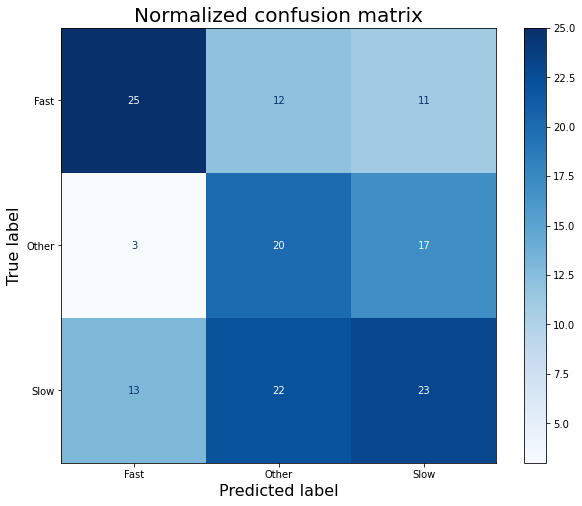

  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.59      0.42      0.49        48
           1       0.35      0.57      0.44        40
           2       0.47      0.38      0.42        58

    accuracy                           0.45       146
   macro avg       0.47      0.46      0.45       146
weighted avg       0.48      0.45      0.45       146

Normalized confusion matrix:
[[20 14 14]
 [ 6 23 11]
 [ 8 28 22]]


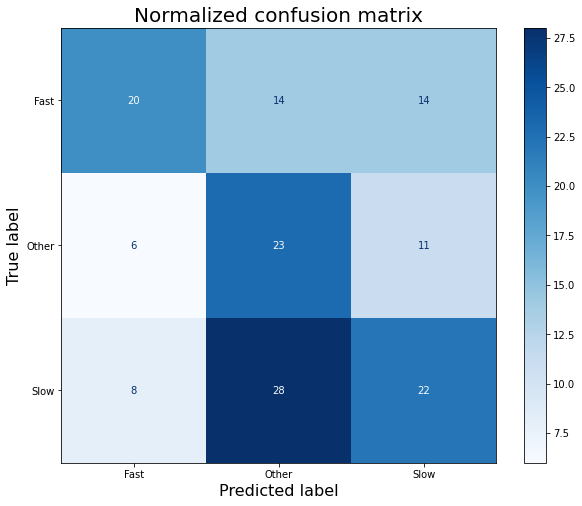

  0%|          | 0/20 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.48      0.46      0.47        48
           1       0.33      0.78      0.46        40
           2       0.60      0.05      0.10        58

    accuracy                           0.38       146
   macro avg       0.47      0.43      0.34       146
weighted avg       0.48      0.38      0.32       146

Normalized confusion matrix:
[[22 26  0]
 [ 7 31  2]
 [17 38  3]]


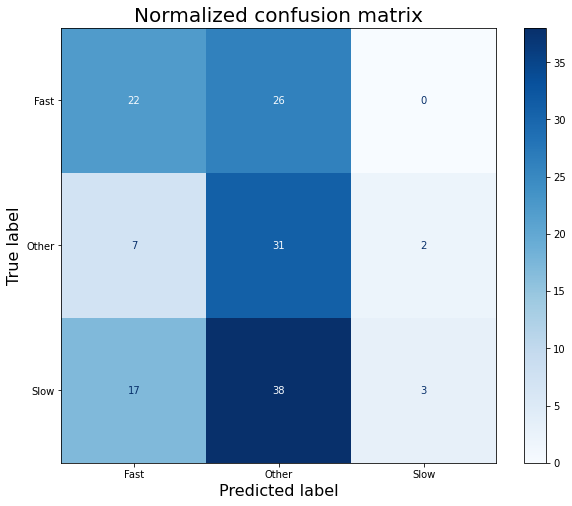

In [71]:
!unzip 5.zip
_, _ = one_loop(x=None, print_results=True)

## Model explanation

In [ ]:
model = RandomForestClassifier(n_estimators=400, criterion='gini', random_state=1, n_jobs=-1).fit(X_train, y_train)
eli5.explain_weights_sklearn(model, top=30, feature_names=col_list)

Explanation(estimator="RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,\n                       criterion='gini', max_depth=None, max_features='auto',\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_split=2,\n                       min_weight_fraction_leaf=0.0, n_estimators=400,\n                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,\n                       warm_start=False)", description='\nRandom forest feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='egfr', weight=0.1727311068742395, std=0.03646823035872038, value=None), FeatureWeight(feature='bp.sys', weight=0.13320209102435285, std=0.030871654727009225, value=None), FeatureWeight(feature='age', weight=0.12598920482764592, std=0.03037586122996615, value=None), FeatureWeight(feature='bun', weight=0.12144486168960605, std=0.02863797717043159, value=None), FeatureWeight(feature='weight', weight=0.12022895854766544, std=0.027678878962644645, value=None), FeatureWeight(feature='height', weight=0.07648307773147683, std=0.02236270250595374, value=None), FeatureWeight(feature='disease_DN', weight=0.020322647086751314, std=0.010499759645324135, value=None), FeatureWeight(feature='disease_HTN', weight=0.01945578344824114, std=0.010106919959882988, value=None), FeatureWeight(feature='smoker_Unknown', weight=0.016352673957430806, std=0.009214029940960886, value=None), FeatureWeight(feature='disease_GMN', weight=0.016064945196902818, std=0.009311797514645143, value=None), FeatureWeight(feature='gender_Male', weight=0.014976012646003192, std=0.009962934325617276, value=None), FeatureWeight(feature='gender_Female', weight=0.014962252138826388, std=0.010421938531004399, value=None), FeatureWeight(feature='disease_Other', weight=0.014698203590016492, std=0.009177277464135231, value=None), FeatureWeight(feature='smoker_Past-Smoker', weight=0.014490756886902278, std=0.00886669048133588, value=None), FeatureWeight(feature='patient_died', weight=0.013158680175312692, std=0.007961930087473382, value=None), FeatureWeight(feature='ethnicity_Caucasian', weight=0.013005563757755736, std=0.008622617685283772, value=None), FeatureWeight(feature='smoker_Non-Smoker', weight=0.012773524457156703, std=0.009083068912217664, value=None), FeatureWeight(feature='disease_Transplant', weight=0.012159330508960205, std=0.00959452960643447, value=None), FeatureWeight(feature='kidney_transplant', weight=0.011787490342257921, std=0.009400779576387986, value=None), FeatureWeight(feature='smoker_Smoker', weight=0.011029760935382504, std=0.007928710558767278, value=None), FeatureWeight(feature='ethnicity_Unknown', weight=0.010932533407786486, std=0.008589107264220595, value=None), FeatureWeight(feature='site_Patras', weight=0.01013555664688185, std=0.008160172977252411, value=None), FeatureWeight(feature='site_Sheffield', weight=0.009746968945782468, std=0.0073897880842705745, value=None), FeatureWeight(feature='ethnicity_Asian', weight=0.0036304086873269288, std=0.004346855832909786, value=None), FeatureWeight(feature='disease_Vascular', weight=0.003456102995565763, std=0.004289860528701162, value=None), FeatureWeight(feature='ethnicity_Others', weight=0.0021027985145123797, std=0.003257680691187393, value=None), FeatureWeight(feature='disease_Obstructive', weight=0.001871509137719924, std=0.0030630298687656723, value=None), FeatureWeight(feature='ethnicity_Black', weight=0.001718222624157237, std=0.0033292136434096547, value=None), FeatureWeight(feature='gender_Unknown', weight=0.0010889732173801677, std=0.002317713495580421, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

# Repeat

In [ ]:
final_array_50, pred_list_50 = full_process('/content')

In [ ]:
print('Means: ', np.mean(final_array_50, axis=0))
print('Std: ', np.std(final_array_50, axis=0))

Means:  [0.32348297 0.40016202 0.43663215 0.45951649 0.3987884  0.44102428
 0.44491667 0.41946148 0.45522032]
Std:  [0.07687081 0.05144081 0.01829653 0.03505869 0.08331081 0.03985104
 0.02278505 0.03674785 0.07067287]


In [ ]:
final_array_25, pred_list_25 = full_process('/content')

In [ ]:
print('Means: ', np.mean(final_array_25, axis=0))
print('Std: ', np.std(final_array_25, axis=0))

In [ ]:
final_array_10, pred_list_10 = full_process('/content')

In [ ]:
print('Means: ', np.mean(final_array_10, axis=0))
print('Std: ', np.std(final_array_10, axis=0))